# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [262]:
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# %pip install zstandard
# import zstandard
# drive.mount('/content/drive')
# %mkdir -p "/tmp/sepsis"
# %cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
# %cd "/tmp/sepsis"

In [7]:
# %cp "/content/drive/My Drive/sepsis/training_setA.csv" "/tmp/sepsis"

**Read data file**

In [263]:
full_df = pd.read_csv("training_setA.csv")

In [9]:
# dctx = zstandard.ZstdDecompressor()
# with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
#     dctx.copy_stream(ifh, ofh)

# my_tar = tarfile.open('training.tar')
# my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
# my_tar.close()
# %cd "training/training_setA"

In [10]:
# # load all data sets (roughly 20000 for set A)
# wd = Path(".")
# full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
# #full_df = pd.concat(full_df_from_disk)

## Preprocess Data File
Only if data was read in via .psv files

In [264]:
full_df.head()

time    HR  O2Sat   Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  ...  \
0     0   NaN    NaN    NaN    NaN    NaN  NaN   NaN    NaN         NaN  ...   
1     1  52.0   98.0    NaN  134.0  72.67  NaN  20.0    NaN         NaN  ...   
2     2   NaN    NaN    NaN  143.0  80.33  NaN   NaN    NaN         NaN  ...   
3     3  60.0   99.0  36.22  154.0  83.33  NaN  16.0    NaN         NaN  ...   
4     4  51.0   98.0    NaN  155.0  98.33  NaN  20.0    NaN         NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  76.16       0    1.0    0.0        -0.02       1   
1         NaN      266.0  76.16       0    1.0    0.0        -0.02       2   
2         NaN        NaN  76.16       0    1.0    0.0        -0.02       3   
3         NaN        NaN  76.16       0    1.0    0.0        -0.02       4   
4         NaN        NaN  76.16       0    1.0    0.0        -0.02       5   

   SepsisLabel  patient_id  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  

[5 rows x 43 columns]

In [12]:
full_df.columns

Index(['time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

Reset index, creating time variable

In [13]:
# full_df = full_df.reset_index(names=["time"])

Add patient id variable

In [14]:
# groups = full_df['time'].diff().lt(0).cumsum()

In [15]:
# full_df['patient_id'] = groups

Optional: save as csv

In [16]:
# full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

In [17]:
# first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

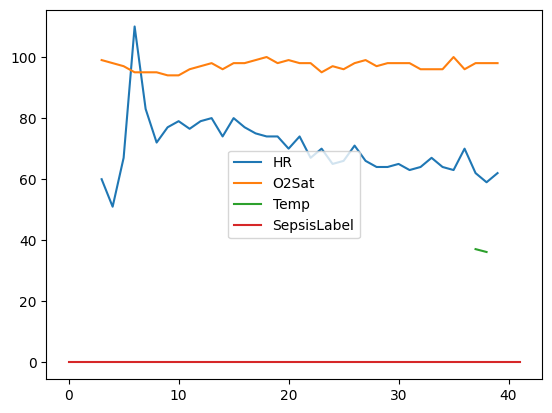

In [265]:
first_patient = full_df.loc[full_df["patient_id"]==0,["HR", "O2Sat", "Temp", "SepsisLabel"]]
first_patient.plot()

Subsample (first n samples)

In [19]:
# # load the first 10 data sets
# wd = Path(".")
# sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
# sample_df = pd.concat(sample_df)

In [20]:
# sample_df[["HR"]].plot()

In [21]:
# # load the first 1000 data sets
# # what is the mean total time in the ICU (ICULOS)?
# # ICULOS = intensive care unit length of stay
# wd = Path(".")
# big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
# ICULOS_times = np.array([])
# for df in big_df:
#   ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
# print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
# plt.hist(ICULOS_times/24, bins=30)
# plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [266]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")
     


Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

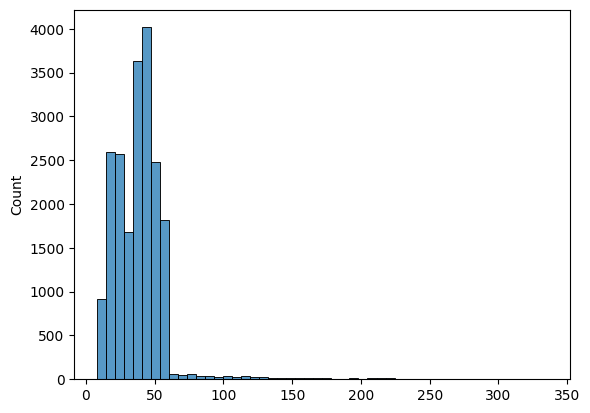

In [267]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

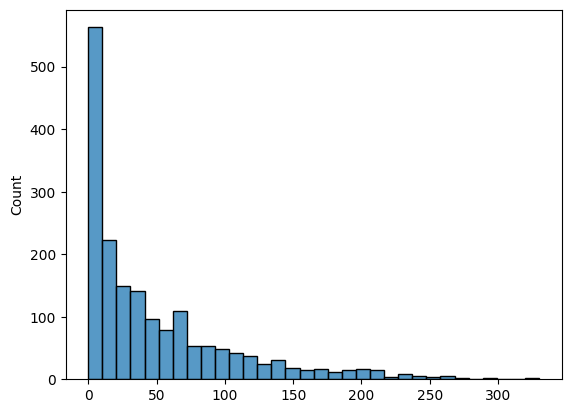

In [268]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])
  
sns.histplot(sepsis_time, kde=False);


In [25]:
# for column in full_df.columns:
    # Generate histogram for the current column
    # plt.figure()  # Create a new figure for each column
    # full_df[column].plot(kind='hist', bins=30)
    # plt.title(f'Histogram of {column}')
    # plt.xlabel(column)
    # plt.ylabel('Frequency')
    # plt.show()  # Display the histogram

In [26]:
#sns.pairplot(full_df)

### Missing Value Inspectation

In [27]:
# interpolate full df
# interpolation_limits = [1, 3, 5]

# full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [269]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. Susequently, all columns with less than 5% overall data will be dropped.

In [270]:
threshold = 0.95  # Set the threshold for missing data

# Calculate the number of non-null values in each column
non_null_counts = full_df.notnull().sum()

# Calculate the percentage of missing full_df in each column
missing_percentages = 1 - (non_null_counts / len(full_df))

# Identify columns with missing data exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with excessive missing data
full_df = full_df.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("Dropped columns (less that 5% availble data):", columns_to_drop)

Dropped columns (less that 5% availble data): Index(['EtCO2', 'SaO2', 'AST', 'Alkalinephos', 'Calcium', 'Bilirubin_direct',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'PTT', 'Fibrinogen'],
      dtype='object')


In [30]:
# # recalculate with the smaller data frame.
# value_availability = full_df.count().sort_values()/full_df.shape[0]
# display(value_availability)

# fig, ax = plt.subplots()

# value_availability_interpolated = [
#     d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
# ]

# res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

# res.plot.barh(figsize=(10,10), ax=ax)
# ax.legend(["percentage of available data (original data)", 
#            *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

### Interpolate

Linear interpolation

In [31]:
# Forward- and backward fill missing values at the start of each patient's data
full_df_filled = full_df.groupby('patient_id', group_keys=False).apply(lambda group: group.ffill())
full_df_filled = full_df_filled.groupby('patient_id', group_keys=False).apply(lambda group: group.bfill())

In [32]:
print(full_df.shape)
print(full_df_filled.shape)

(790215, 32)
(790215, 32)


In [33]:
full_df_filled.head()

time    HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BaseExcess  HCO3  ...  \
0     0  52.0   98.0  36.22  134.0  72.67  NaN  20.0         NaN  24.0  ...   
1     1  52.0   98.0  36.22  134.0  72.67  NaN  20.0         NaN  24.0  ...   
2     2  52.0   98.0  36.22  143.0  80.33  NaN  20.0         NaN  24.0  ...   
3     3  60.0   99.0  36.22  154.0  83.33  NaN  16.0         NaN  24.0  ...   
4     4  51.0   98.0  36.22  155.0  98.33  NaN  20.0         NaN  24.0  ...   

    WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0  14.8      266.0  76.16       0    1.0    0.0        -0.02       1   
1  14.8      266.0  76.16       0    1.0    0.0        -0.02       2   
2  14.8      266.0  76.16       0    1.0    0.0        -0.02       3   
3  14.8      266.0  76.16       0    1.0    0.0        -0.02       4   
4  14.8      266.0  76.16       0    1.0    0.0        -0.02       5   

   SepsisLabel  patient_id  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  

[5 rows x 32 columns]

In [34]:
# Interpolate missing values within each patient's data using linear interpolation
df_int = full_df_filled.groupby('patient_id', group_keys=False).apply(lambda x: x.interpolate(method='linear'))

# To Do: Proper interpolation

In [35]:
df_int.head()

time    HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BaseExcess  HCO3  ...  \
0     0  52.0   98.0  36.22  134.0  72.67  NaN  20.0         NaN  24.0  ...   
1     1  52.0   98.0  36.22  134.0  72.67  NaN  20.0         NaN  24.0  ...   
2     2  52.0   98.0  36.22  143.0  80.33  NaN  20.0         NaN  24.0  ...   
3     3  60.0   99.0  36.22  154.0  83.33  NaN  16.0         NaN  24.0  ...   
4     4  51.0   98.0  36.22  155.0  98.33  NaN  20.0         NaN  24.0  ...   

    WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0  14.8      266.0  76.16       0    1.0    0.0        -0.02       1   
1  14.8      266.0  76.16       0    1.0    0.0        -0.02       2   
2  14.8      266.0  76.16       0    1.0    0.0        -0.02       3   
3  14.8      266.0  76.16       0    1.0    0.0        -0.02       4   
4  14.8      266.0  76.16       0    1.0    0.0        -0.02       5   

   SepsisLabel  patient_id  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  

[5 rows x 32 columns]

In [36]:
df_int.columns

Index(['time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct',
       'Hgb', 'WBC', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

In [37]:
vars = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct',
       'Hgb', 'WBC', 'Platelets', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS']
# Calculate the mean for the variables over all patients
mean_values = df_int[vars].mean()

# Iterate over the variables and fill missing values with the corresponding mean
for variable in vars:
    full_df_int[variable] = df_int[variable].fillna(mean_values[variable])


In [38]:
df_int.head()

time    HR  O2Sat   Temp    SBP    MAP        DBP  Resp  BaseExcess  HCO3  \
0     0  52.0   98.0  36.22  134.0  72.67  60.773805  20.0    0.020709  24.0   
1     1  52.0   98.0  36.22  134.0  72.67  60.773805  20.0    0.020709  24.0   
2     2  52.0   98.0  36.22  143.0  80.33  60.773805  20.0    0.020709  24.0   
3     3  60.0   99.0  36.22  154.0  83.33  60.773805  16.0    0.020709  24.0   
4     4  51.0   98.0  36.22  155.0  98.33  60.773805  20.0    0.020709  24.0   

   ...   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0  ...  14.8      266.0  76.16       0    1.0    0.0        -0.02       1   
1  ...  14.8      266.0  76.16       0    1.0    0.0        -0.02       2   
2  ...  14.8      266.0  76.16       0    1.0    0.0        -0.02       3   
3  ...  14.8      266.0  76.16       0    1.0    0.0        -0.02       4   
4  ...  14.8      266.0  76.16       0    1.0    0.0        -0.02       5   

   SepsisLabel  patient_id  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  

[5 rows x 32 columns]

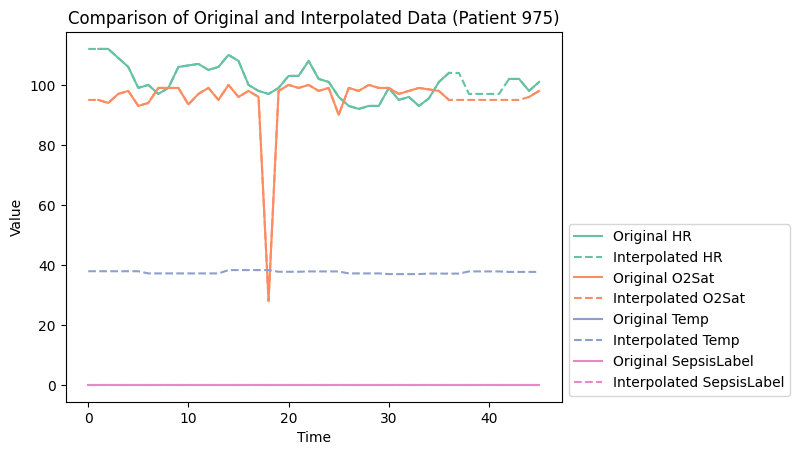

In [39]:
# Choose a specific patient for plotting (e.g., patient_id = 0)
patient_id = 975

# Specify the columns to plot
columns_to_plot = ["HR", "O2Sat", "Temp", "SepsisLabel"]

# Generate a color palette based on the number of variables
color_palette = sns.color_palette('Set2', len(columns_to_plot))

# Filter the original and interpolated data for the selected patient
original_patient_data = full_df[full_df['patient_id'] == patient_id]
interpolated_patient_data = full_df_int[full_df_int['patient_id'] == patient_id]

# Set up the figure and subplot
fig, ax = plt.subplots()

# Iterate over the columns and plot the original and interpolated data
for variable, color in zip(columns_to_plot, color_palette):
    # Plot the original data
    ax.plot(original_patient_data['time'], original_patient_data[variable], label=f'Original {variable}', color=color)

    # Plot the interpolated data
    ax.plot(interpolated_patient_data['time'], interpolated_patient_data[variable], label=f'Interpolated {variable}', linestyle='--', color=color)


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title(f'Comparison of Original and Interpolated Data (Patient {patient_id})')

# Add legend
ax.legend(bbox_to_anchor=(1, 0.5), loc="upper left")

# Show the plot
plt.show()

## Time Series Prediction Models

### Create test and train set

In [110]:
n = 80  # Number of patients to select

# Get unique patient IDs
unique_patients = full_df_int['patient_id'].unique()

# Select a subset of n unique patients
selected_patients = pd.Series(unique_patients).sample(n=n, random_state=42)

# Filter the data frame based on the selected patients and preserve the order
df_int = full_df_int[full_df_int['patient_id'].isin(selected_patients)].sort_values(by=['patient_id', 'time'])


In [112]:
df_int.head()

time    HR  O2Sat   Temp    SBP   MAP   DBP   Resp  BaseExcess  HCO3  \
18521     0  61.0  100.0  36.89  132.0  79.0  53.0  16.00         1.0  27.0   
18522     1  57.5  100.0  36.89  119.5  60.0  39.5  18.00         1.0  27.0   
18523     2  54.0  100.0  36.28  125.0  74.5  51.0  18.00        -3.0  27.0   
18524     3  60.0  100.0  36.28  138.0  87.0  61.0  18.00        -3.0  27.0   
18525     4  68.0   99.5  37.17  115.0  74.5  55.5  24.25        -3.0  27.0   

       ...   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
18521  ...  36.9      221.0  58.94       0    0.0    1.0      -470.95       5   
18522  ...  36.9      221.0  58.94       0    0.0    1.0      -470.95       6   
18523  ...  36.9      221.0  58.94       0    0.0    1.0      -470.95       7   
18524  ...  36.9      221.0  58.94       0    0.0    1.0      -470.95       8   
18525  ...  36.9      221.0  58.94       0    0.0    1.0      -470.95       9   

       SepsisLabel  patient_id  
18521            0         474  
18522            0         474  
18523            0         474  
18524            0         474  
18525            0         474  

[5 rows x 32 columns]

In [113]:
unique_patients = df_int['patient_id'].unique()
print(unique_patients)
len(unique_patients)

[  474   812  1006  1512  1527  2026  2238  2480  2752  3011  3043  3846
  4015  4564  4740  5005  5018  5143  5937  5970  6070  6515  6826  7203
  7250  7277  7408  7628  7772  7882  7922  8341  8628  8665  9143  9482
  9827  9841  9862  9978 10091 10671 11050 11184 11509 11823 12194 12445
 12463 12590 12842 13165 13958 14647 14673 14756 15167 15491 15540 15760
 16026 16246 16595 16804 17085 17151 17232 17811 17991 18121 18135 18306
 18827 18861 19000 19333 19399 19753 19906 20058]


80

In [114]:
unique_patients = df_int['patient_id'].unique()

# Split the patients into train and test sets
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=42)

# Filter the data based on the train and test patients
train_data = df_int[df_int['patient_id'].isin(train_patients)]
test_data = df_int[df_int['patient_id'].isin(test_patients)]

# Separate features and labels
train_X = train_data.drop('SepsisLabel', axis=1)
train_y = train_data['SepsisLabel']
test_X = test_data.drop('SepsisLabel', axis=1)
test_y = test_data['SepsisLabel']

# Display the shapes of the train and test sets
print("Train Patients Num:", len(train_X['patient_id'].unique()))
print('Train features shape:', train_X.shape)
print('Train labels shape:', train_y.shape)
print("Test Patients Num:", len(test_X['patient_id'].unique()))
print('Test features shape:', test_X.shape)
print('Test labels shape:', test_y.shape)

# TO DO: Check for dublicate patients in train and test
# TO DO: Stratify
# TO DO: Train, Test, Val

Train Patients Num: 72
Train features shape: (3231, 31)
Train labels shape: (3231,)
Test Patients Num: 8
Test features shape: (383, 31)
Test labels shape: (383,)


In [115]:
train_X.head()

time    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  \
31210     0  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31211     1  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31212     2  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31213     3  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31214     4  75.5   99.0  37.0  104.0  77.5  61.0  20.0        -1.0  21.0   

       ...   Hgb  WBC  Platelets   Age  Gender     Unit1     Unit2  \
31210  ...  12.7  3.8       65.0  66.4       1  0.507101  0.492899   
31211  ...  12.7  3.8       65.0  66.4       1  0.507101  0.492899   
31212  ...  12.7  3.8       65.0  66.4       1  0.507101  0.492899   
31213  ...  12.7  3.8       65.0  66.4       1  0.507101  0.492899   
31214  ...  12.7  3.8       65.0  66.4       1  0.507101  0.492899   

       HospAdmTime  ICULOS  patient_id  
31210        -0.04       1         812  
31211        -0.04       2         812  
31212        -0.04       3         812  
31213        -0.04       4         812  
31214        -0.04       5         812  

[5 rows x 31 columns]

In [116]:
len(train_y[train_y==1])

89

In [117]:
test_X.head()

time    HR  O2Sat   Temp    SBP   MAP   DBP   Resp  BaseExcess  HCO3  \
18521     0  61.0  100.0  36.89  132.0  79.0  53.0  16.00         1.0  27.0   
18522     1  57.5  100.0  36.89  119.5  60.0  39.5  18.00         1.0  27.0   
18523     2  54.0  100.0  36.28  125.0  74.5  51.0  18.00        -3.0  27.0   
18524     3  60.0  100.0  36.28  138.0  87.0  61.0  18.00        -3.0  27.0   
18525     4  68.0   99.5  37.17  115.0  74.5  55.5  24.25        -3.0  27.0   

       ...  Hgb   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
18521  ...  8.5  36.9      221.0  58.94       0    0.0    1.0      -470.95   
18522  ...  8.5  36.9      221.0  58.94       0    0.0    1.0      -470.95   
18523  ...  8.5  36.9      221.0  58.94       0    0.0    1.0      -470.95   
18524  ...  8.5  36.9      221.0  58.94       0    0.0    1.0      -470.95   
18525  ...  8.5  36.9      221.0  58.94       0    0.0    1.0      -470.95   

       ICULOS  patient_id  
18521       5         474  
18522       6         474  
18523       7         474  
18524       8         474  
18525       9         474  

[5 rows x 31 columns]

In [118]:
train_X.isnull().values.any()


False

In [119]:
test_X.isnull().values.any()

False

### LSTM

In [57]:
# # Scale the features using MinMaxScaler within each patient group
# scaler = MinMaxScaler()

# def scale_within_group(data):
#     return scaler.fit_transform(data)

# train_X_scaled = train_X.groupby('patient_id').apply(scale_within_group)
# test_X_scaled = test_X.groupby('patient_id').apply(scale_within_group)

# To Do: apply proper scaling

In [207]:
features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct',
       'Hgb', 'WBC', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel']

n_features = len(features)-1

In [208]:
window_size = 10

# Define a function to create sliding windows for each patient
def create_sliding_windows(data):
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [209]:
# Create sliding windows for each patient in the training data
train_windows = train_data.groupby('patient_id').apply(create_sliding_windows)

In [210]:
train_data.head()

time    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  \
31210     0  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31211     1  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31212     2  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31213     3  80.0   97.0  37.0  112.0  97.0  61.0  20.5        -1.0  23.0   
31214     4  75.5   99.0  37.0  104.0  77.5  61.0  20.0        -1.0  21.0   

       ...  WBC  Platelets   Age  Gender     Unit1     Unit2  HospAdmTime  \
31210  ...  3.8       65.0  66.4       1  0.507101  0.492899        -0.04   
31211  ...  3.8       65.0  66.4       1  0.507101  0.492899        -0.04   
31212  ...  3.8       65.0  66.4       1  0.507101  0.492899        -0.04   
31213  ...  3.8       65.0  66.4       1  0.507101  0.492899        -0.04   
31214  ...  3.8       65.0  66.4       1  0.507101  0.492899        -0.04   

       ICULOS  SepsisLabel  patient_id  
31210       1            0         812  
31211       2            0         812  
31212       3            0         812  
31213       4            0         812  
31214       5            0         812  

[5 rows x 32 columns]

In [211]:
# Prepare training data
train_X = np.empty((0, window_size, n_features))
train_y = np.empty((0,))
for windows, patient_data in zip(train_windows, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :, :n_features]
    y = np.stack(windows)[:, -2, -2]  # TO DO: indexing correct? What are the three dimensions?
    train_X = np.concatenate((train_X, X))
    train_y = np.concatenate((train_y, y))

In [212]:
train_y

array([0., 0., 0., ..., 0., 0., 0.])

In [243]:
# Define class weights
class_weight = {0: 0.51598082,
                1: 16.14375}

In [240]:
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(train_y), y=train_y)

In [241]:
class_weights

array([ 0.51598082, 16.14375   ])

In [244]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [245]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [246]:
# Train the model
model.fit(train_X, train_y, epochs=21, batch_size=32, class_weight=class_weight)

Epoch 1/21
81/81 [==============================] - 3s 5ms/step - loss: 0.7040
Epoch 2/21
81/81 [==============================] - 0s 5ms/step - loss: 0.6312
Epoch 3/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5895
Epoch 4/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5574
Epoch 5/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5521
Epoch 6/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5264
Epoch 7/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5404
Epoch 8/21
81/81 [==============================] - 0s 5ms/step - loss: 0.5064
Epoch 9/21
81/81 [==============================] - 0s 6ms/step - loss: 0.4858
Epoch 10/21
81/81 [==============================] - 0s 6ms/step - loss: 0.4724
Epoch 11/21
81/81 [==============================] - 0s 6ms/step - loss: 0.4744
Epoch 12/21
81/81 [==============================] - 0s 6ms/step - loss: 0.4531
Epoch 13/21
81/81 [==============================

In [247]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [248]:
# Prepare test data
test_X = np.empty((0, window_size, n_features))
test_y_true = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :, :n_features]
    y_true = np.stack(windows)[:, -2, -2]  # Assuming sepsis_occurrence is the last column
    test_X = np.concatenate((test_X, X))
    test_y_true = np.concatenate((test_y_true, y_true))

In [250]:
test_y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [251]:
sum(test_y_true)/len(test_y_true)

0.0707395498392283

In [252]:
# Make predictions on the test data
test_y_pred = model.predict(test_X)

# Convert predictions to binary values
test_y_pred = (test_y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred)
recall = recall_score(test_y_true, test_y_pred)
auc_roc = roc_auc_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC Score:", auc_roc)

10/10 [==============================] - 0s 2ms/step
Accuracy: 0.8327974276527331
Precision: 0.0
Recall: 0.0
AUC-ROC Score: 0.44809688581314877


In [253]:
test_y_pred.sum()

30

In [261]:
test_y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [260]:
np.concatenate((test_y_pred, test_y_true), axis=1) #WEITER

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

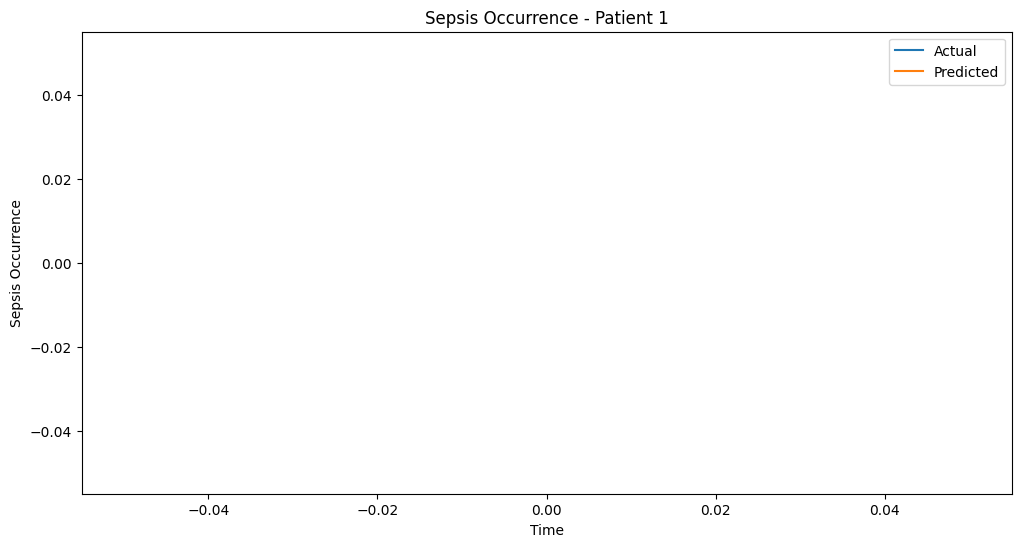

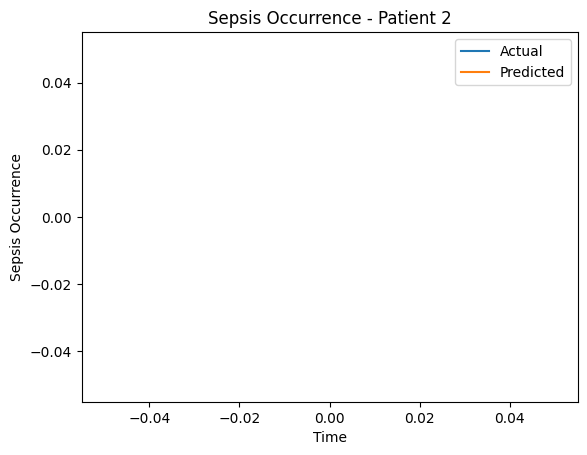

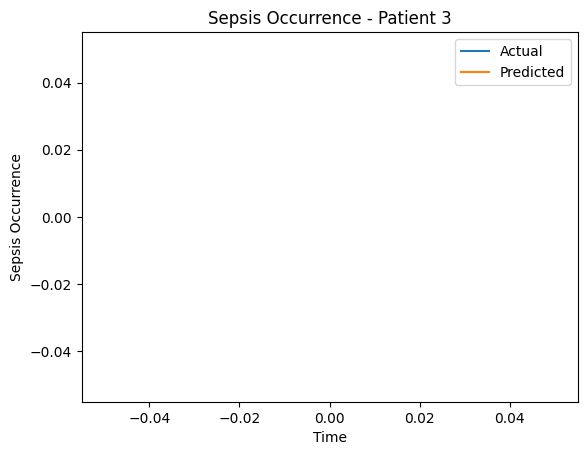

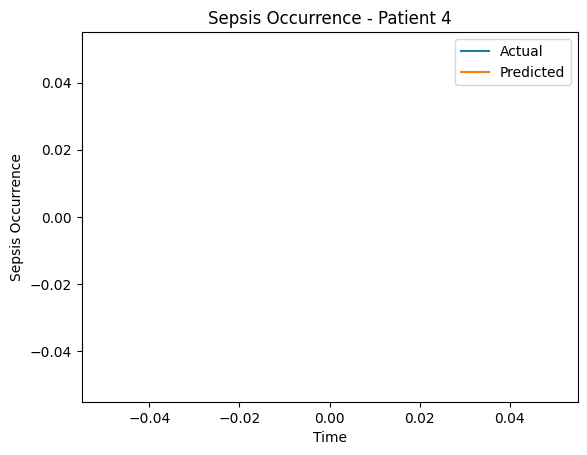

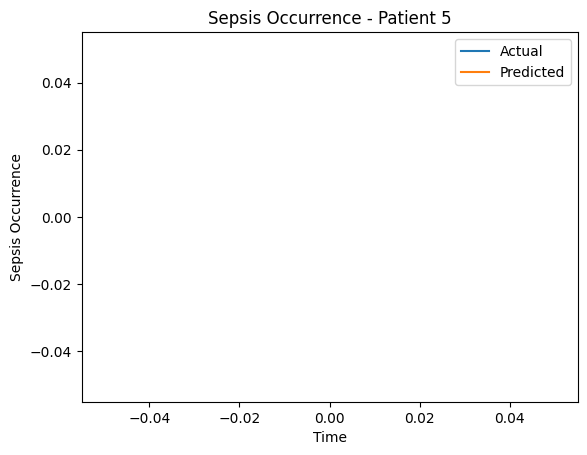

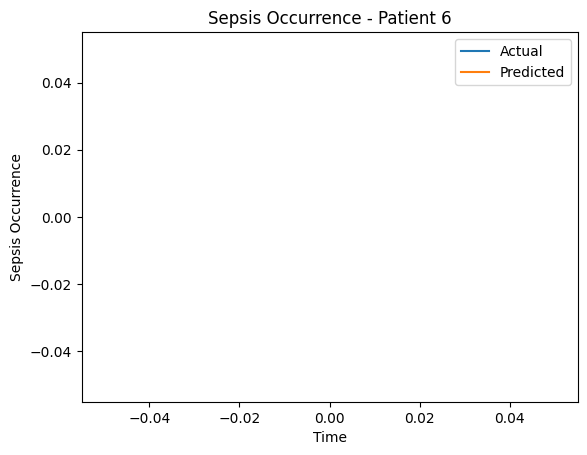

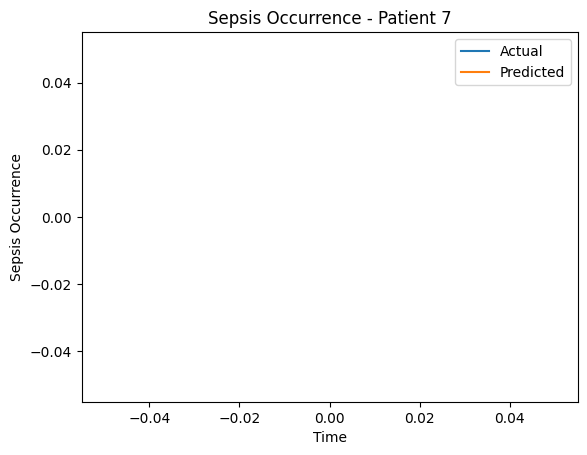

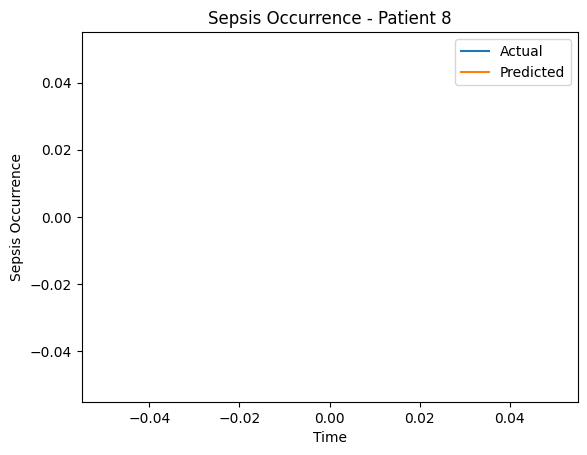

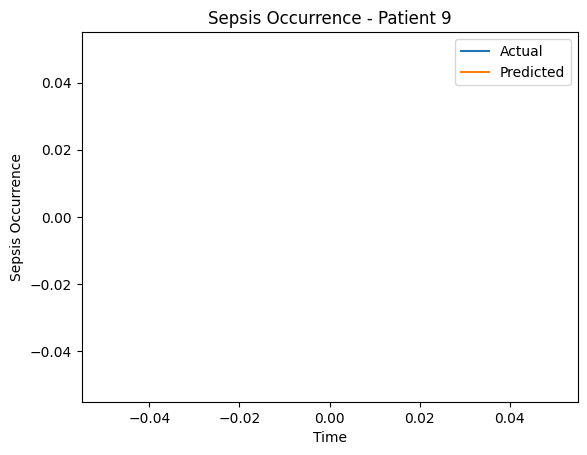

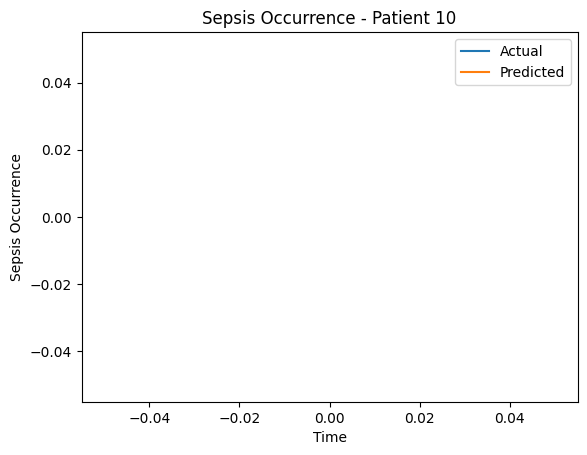

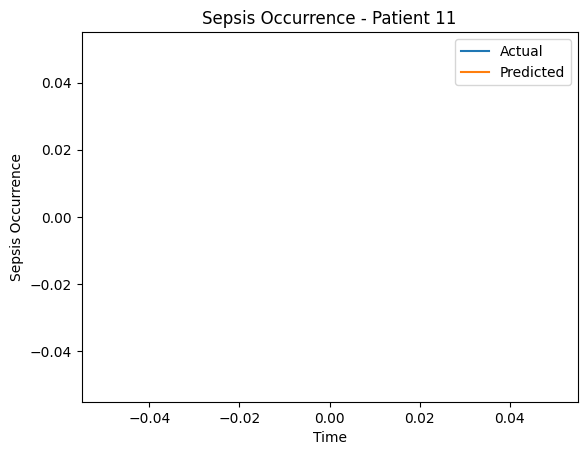

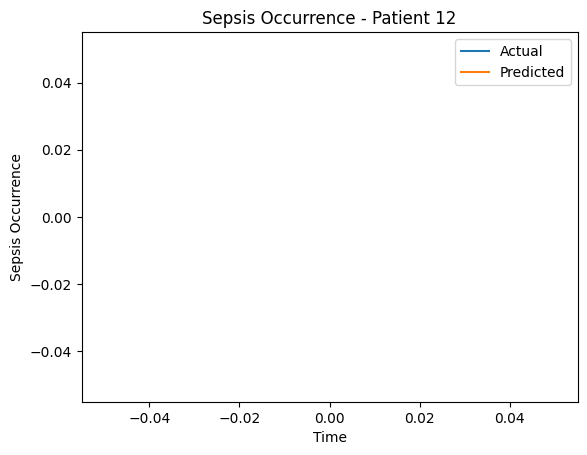

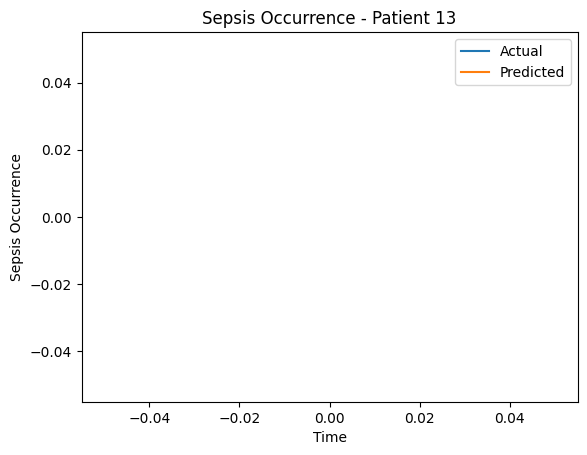

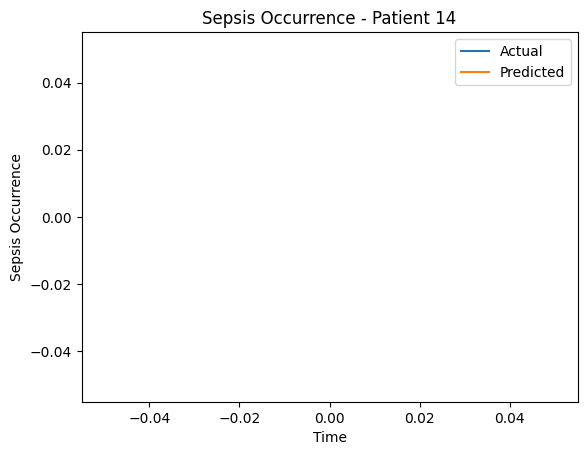

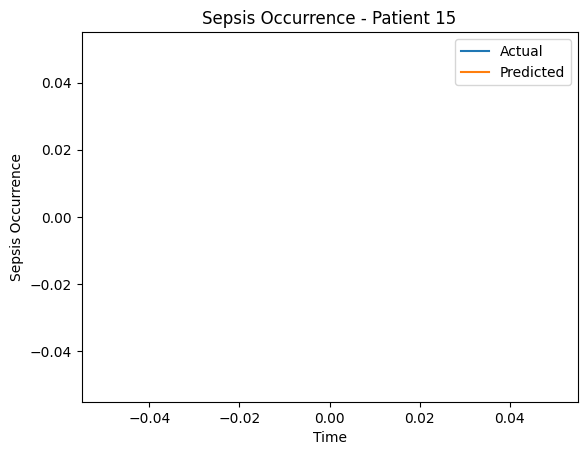

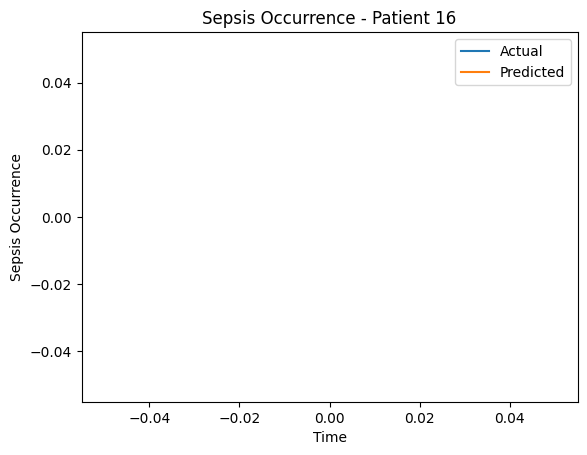

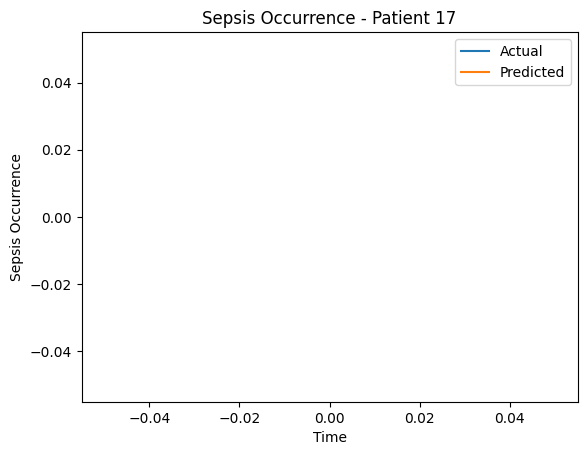

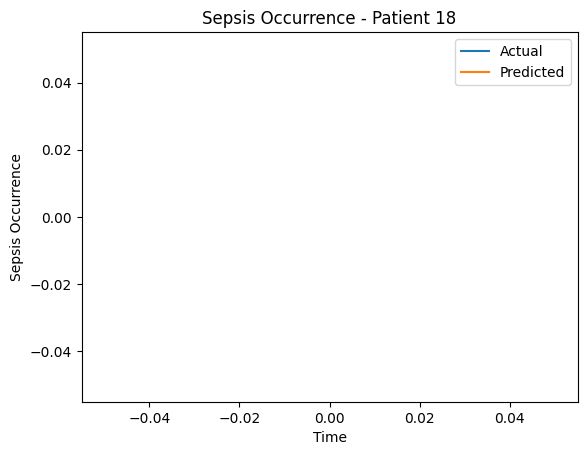

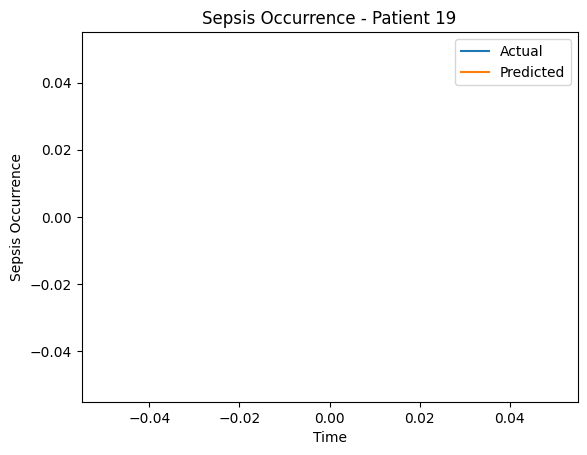

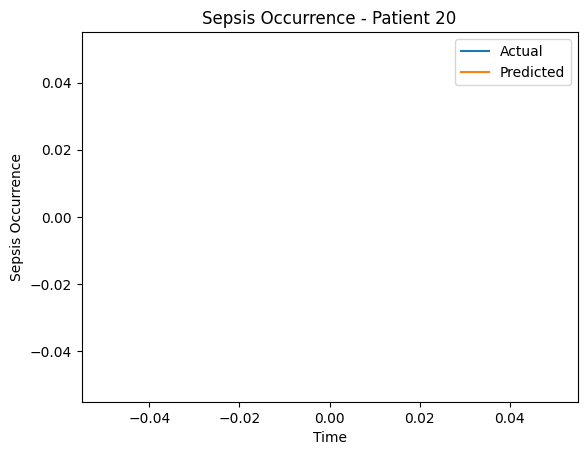

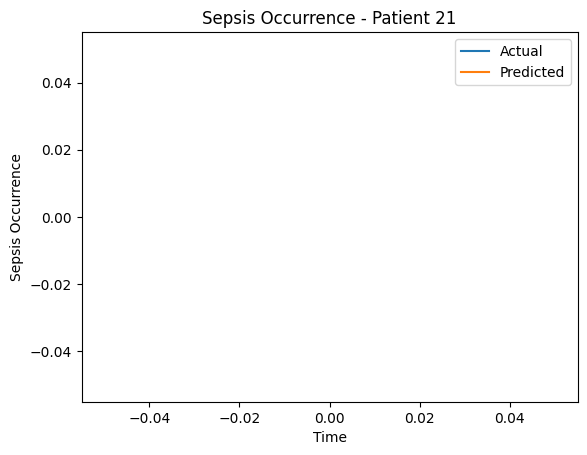

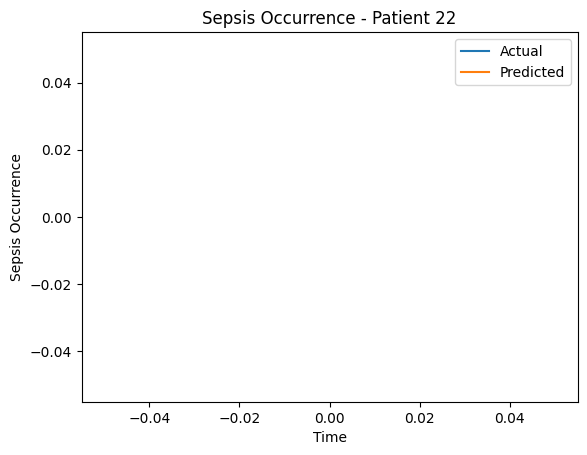

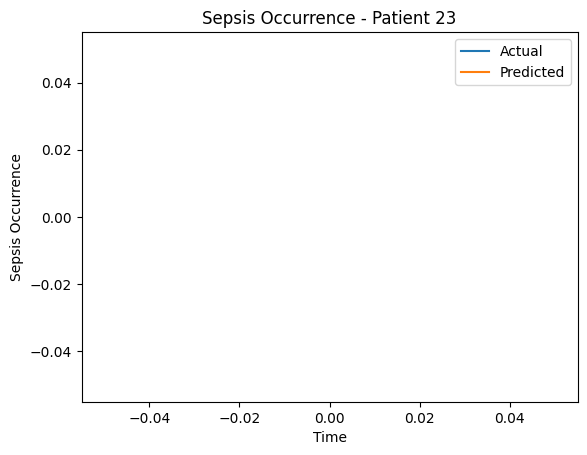

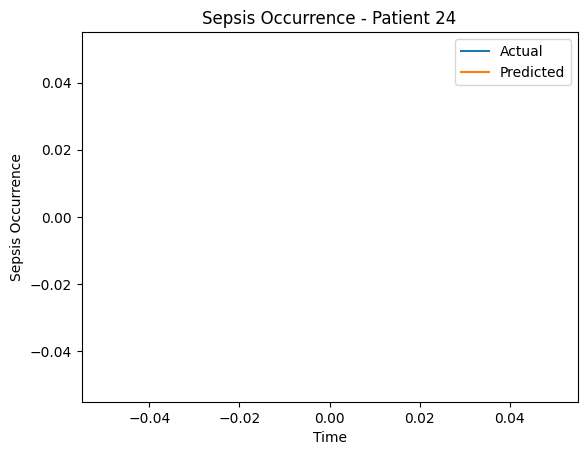

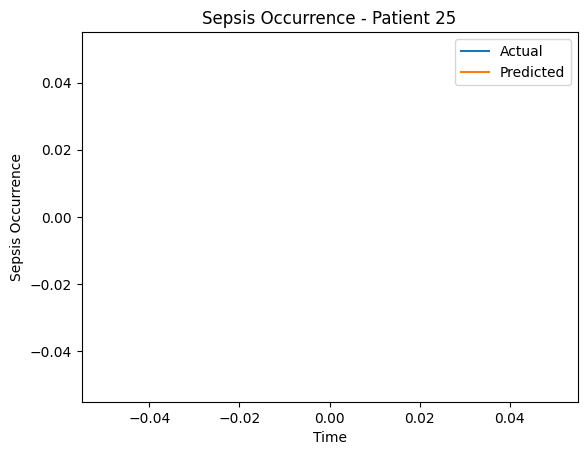

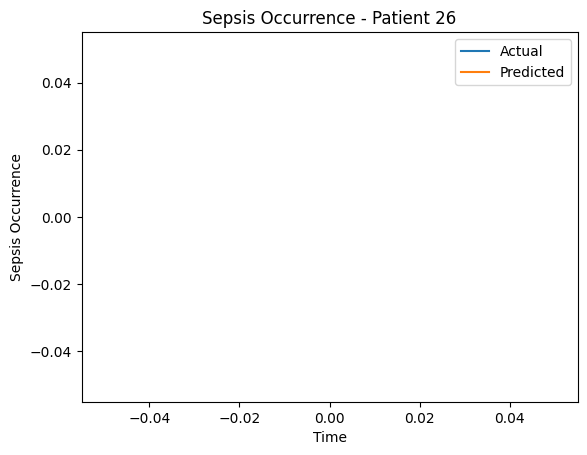

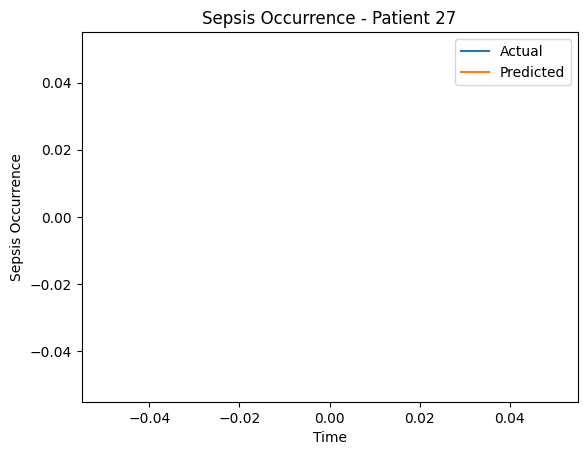

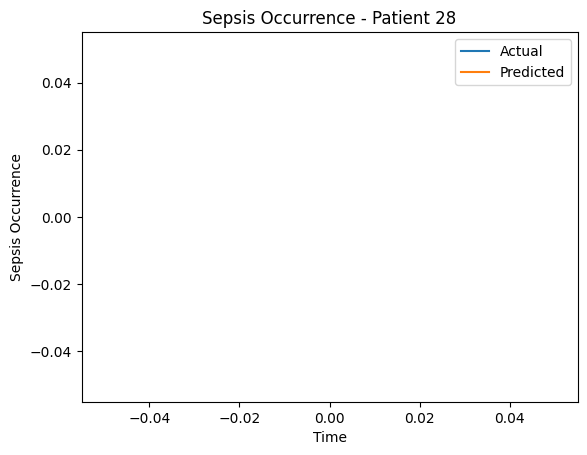

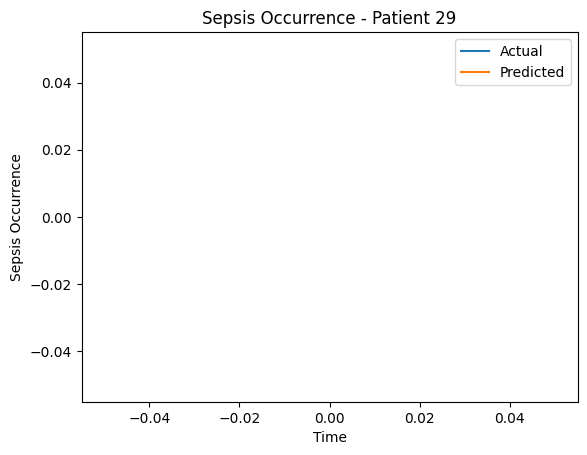

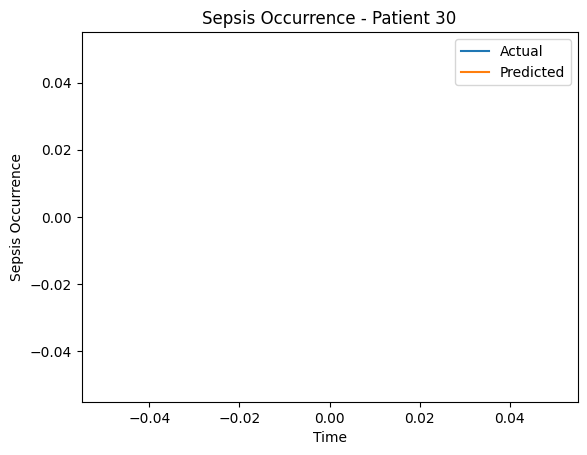

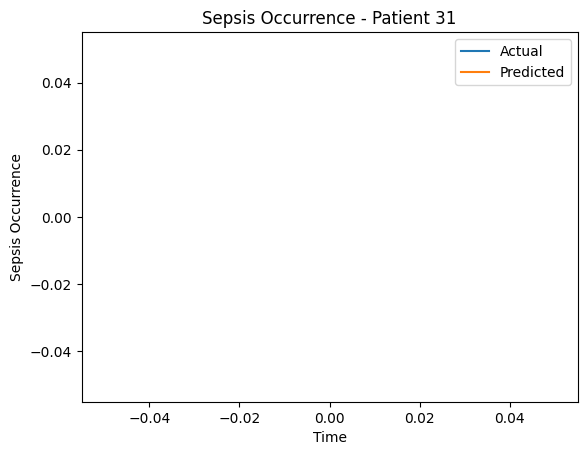

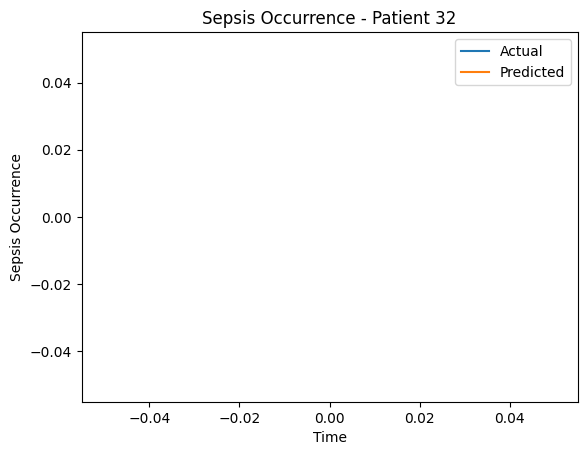

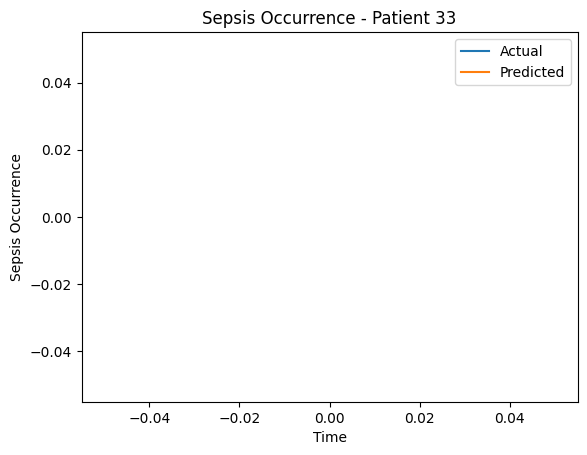

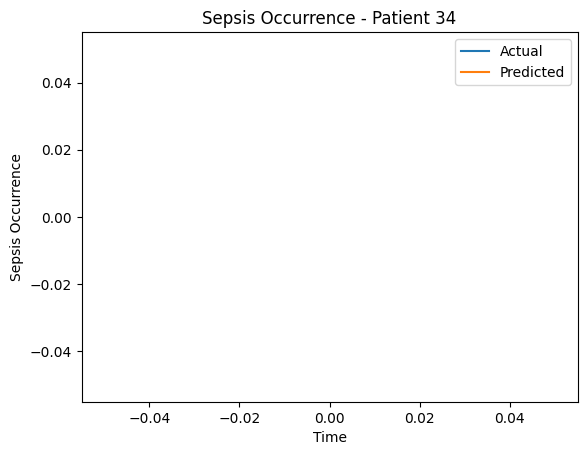

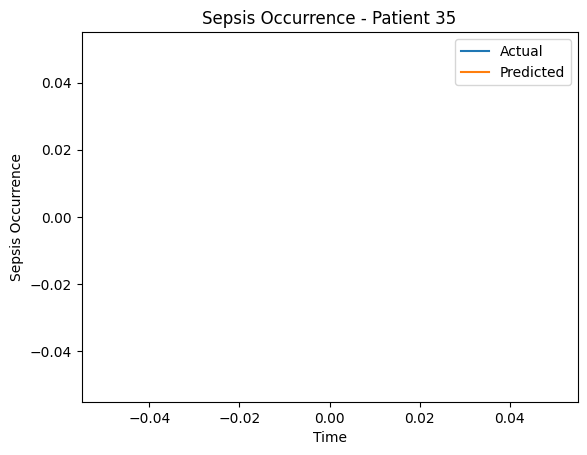

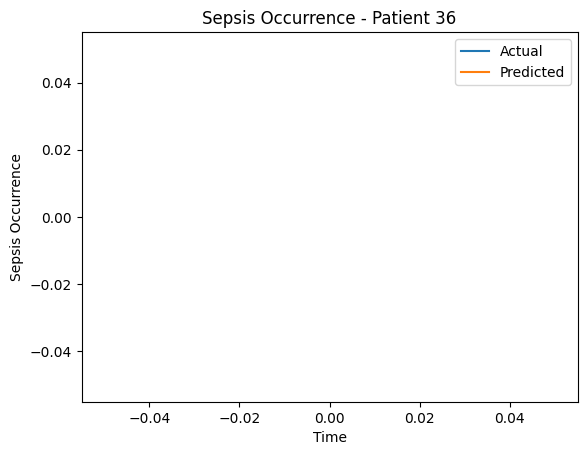

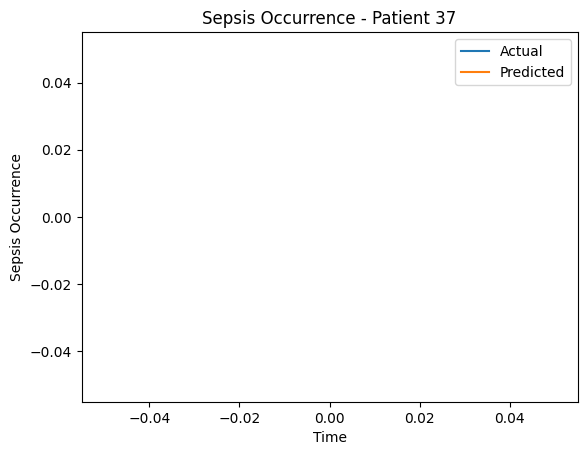

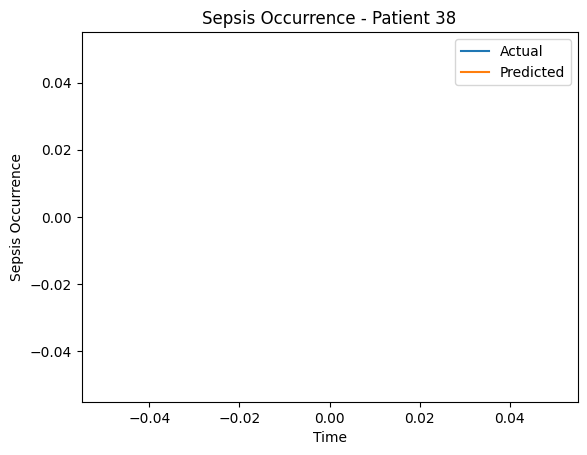

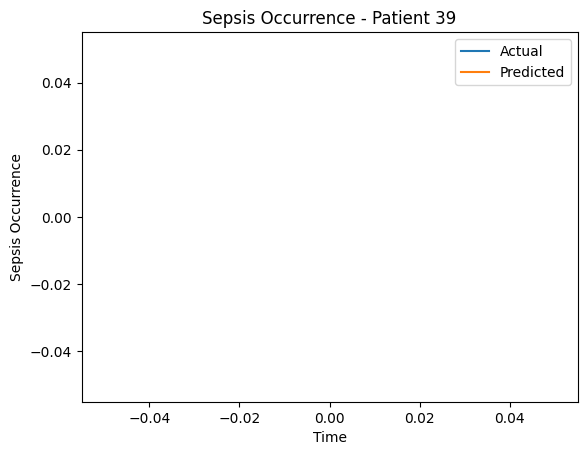

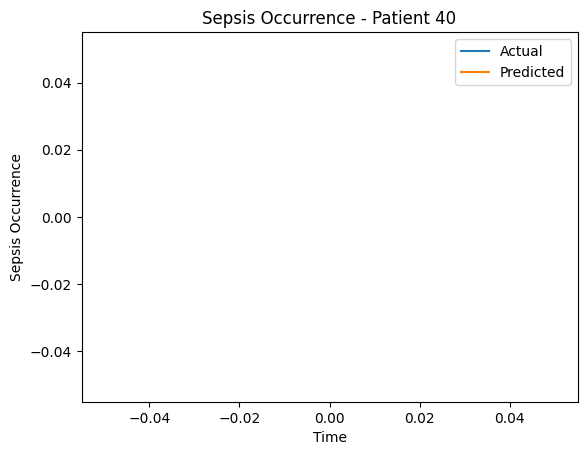

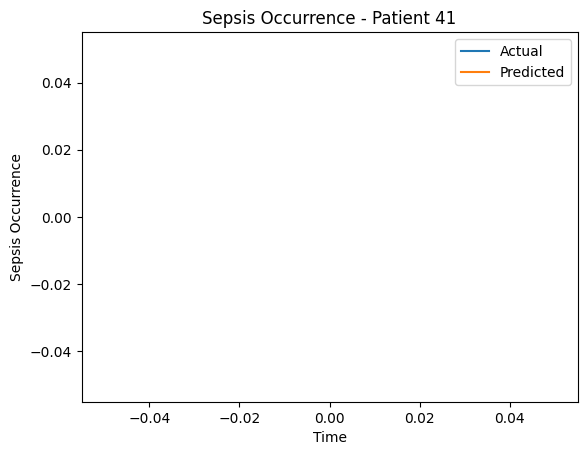

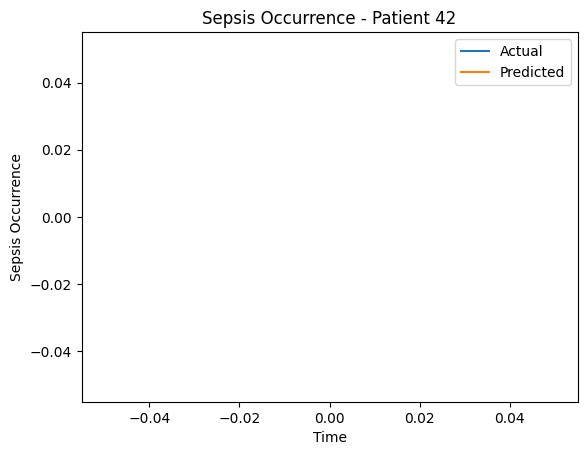

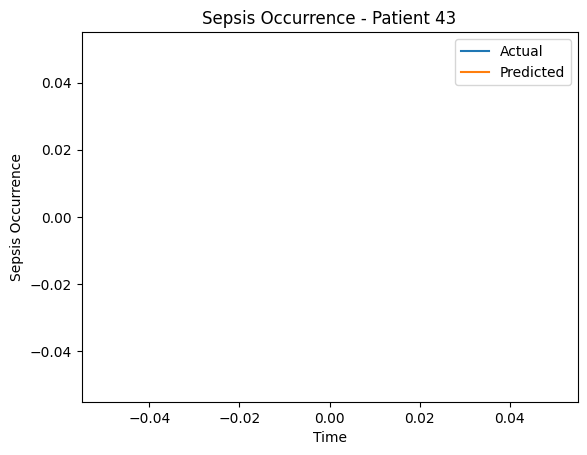

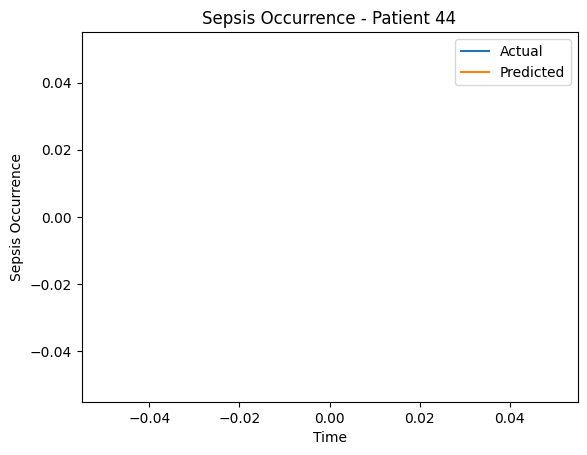

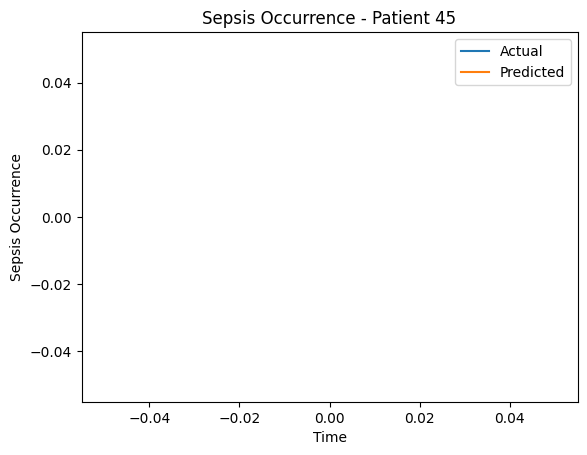

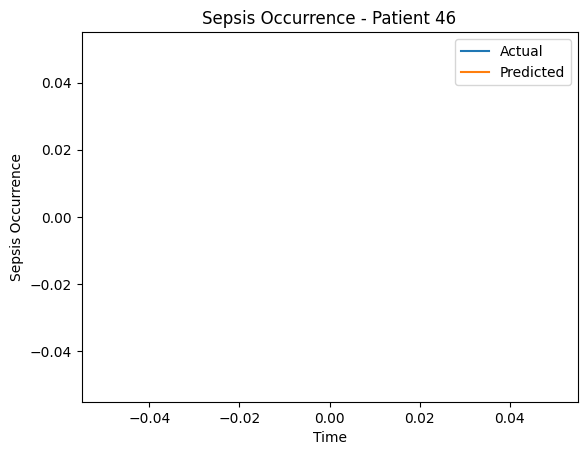

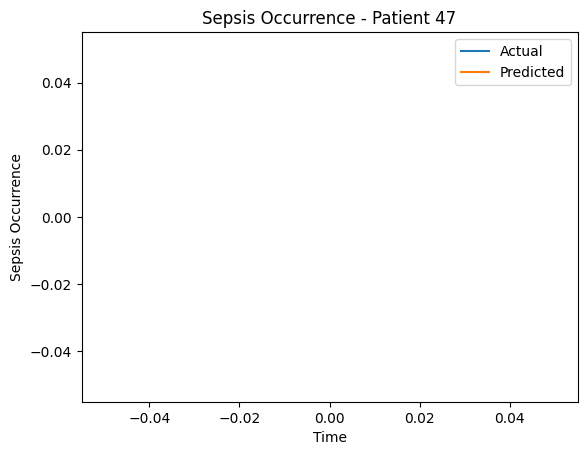

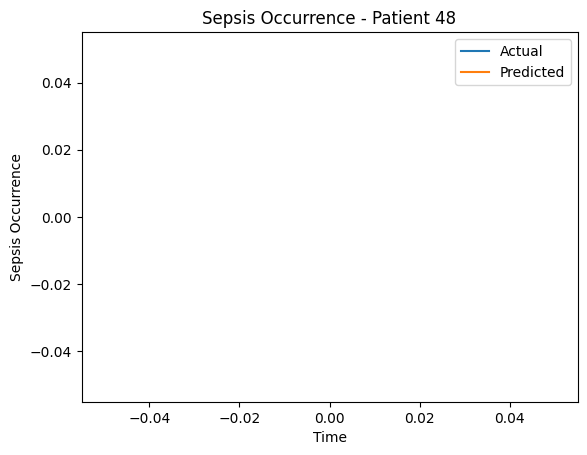

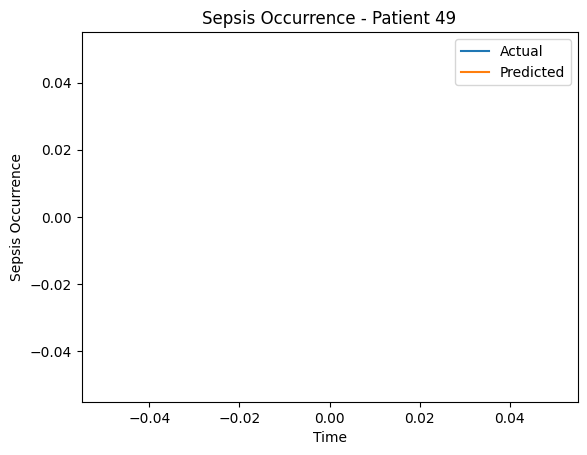

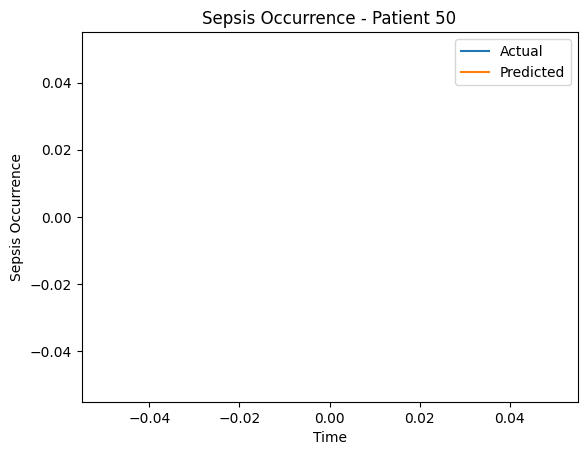

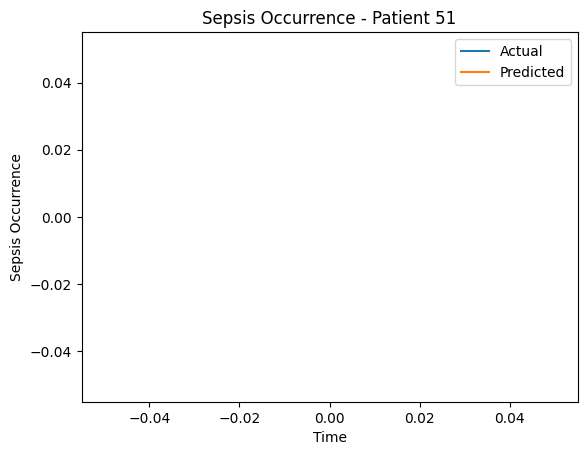

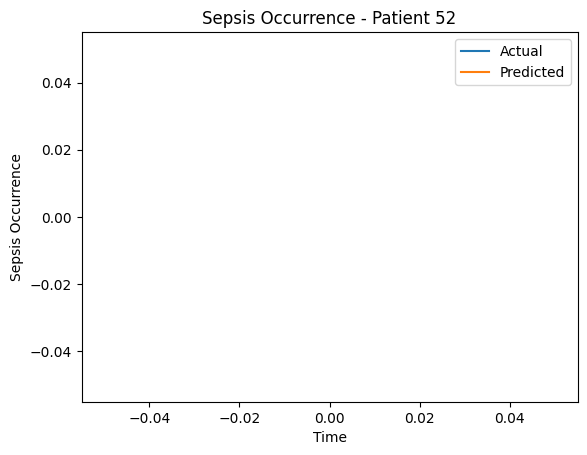

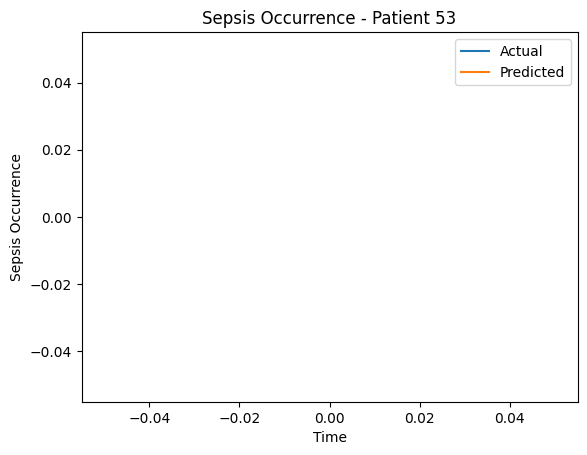

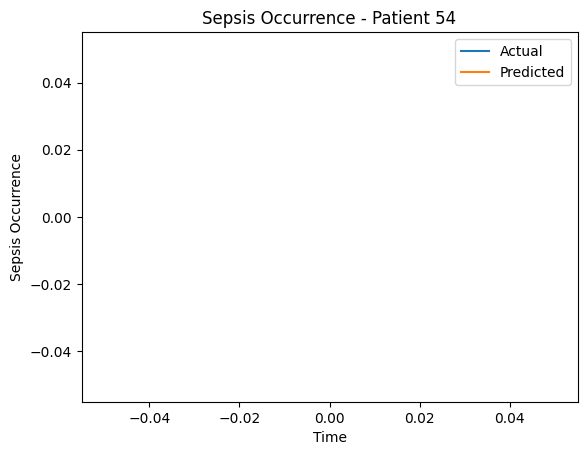

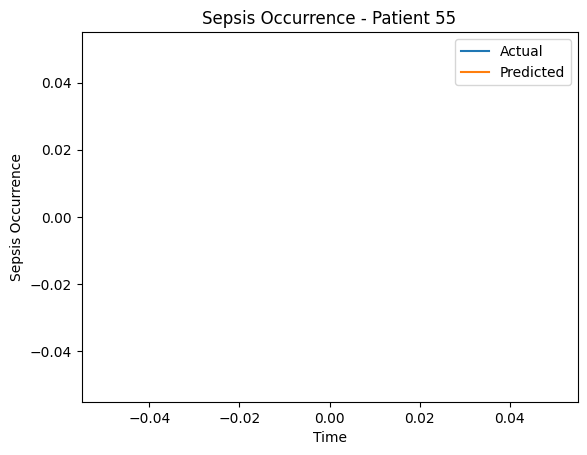

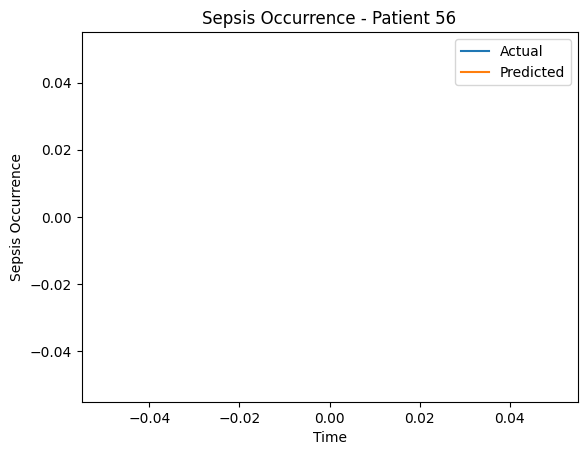

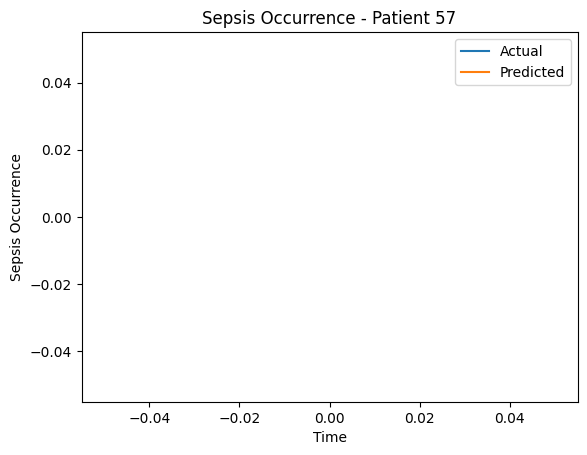

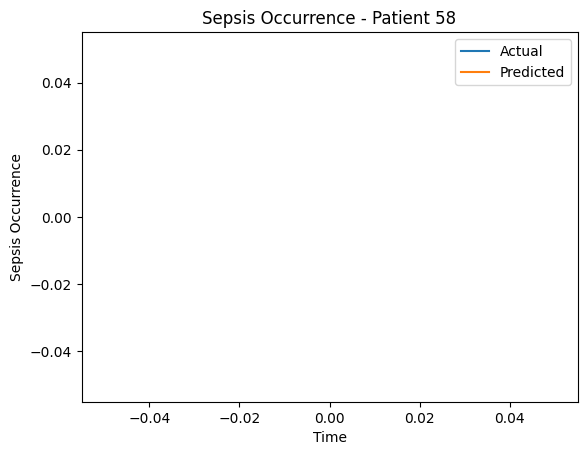

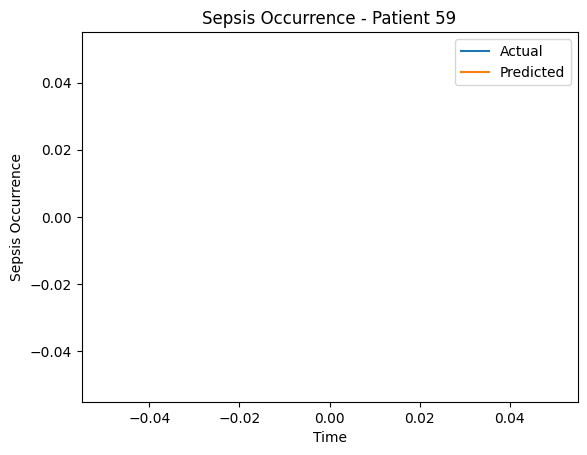

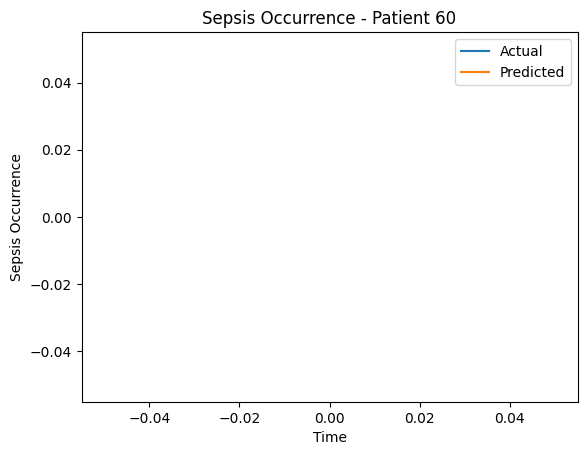

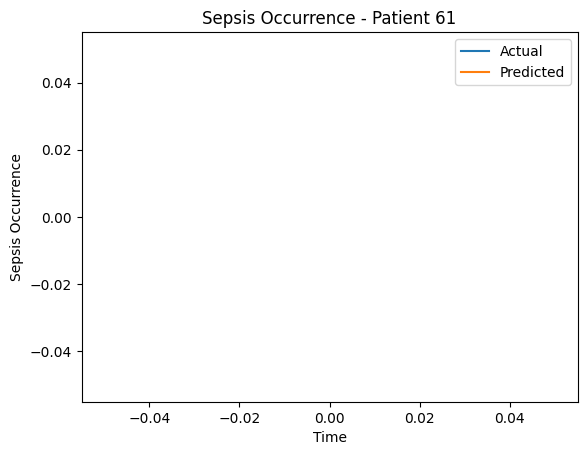

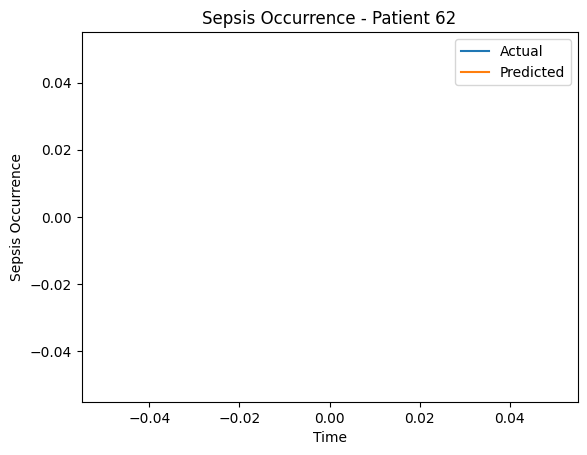

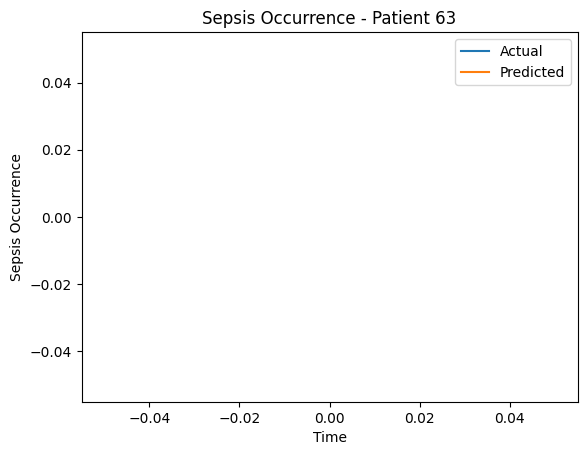

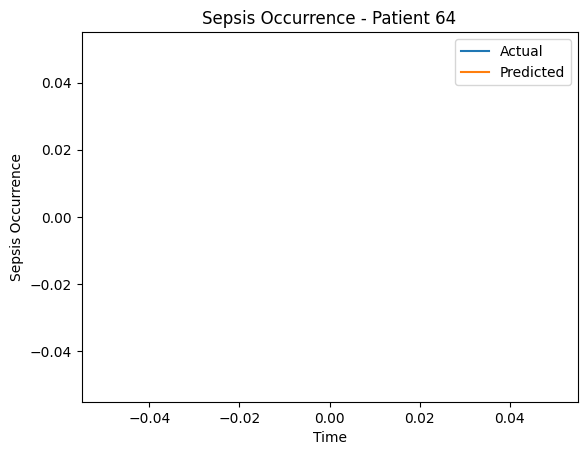

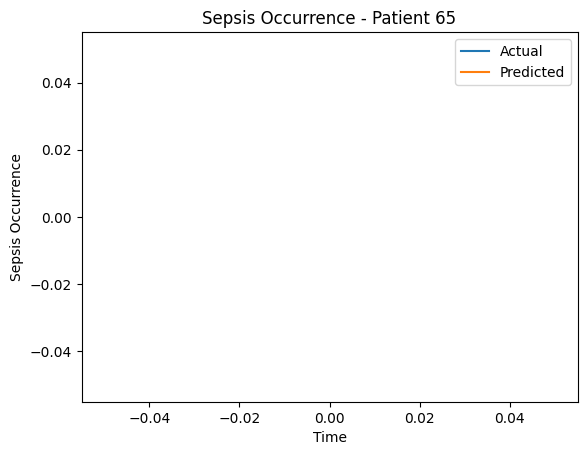

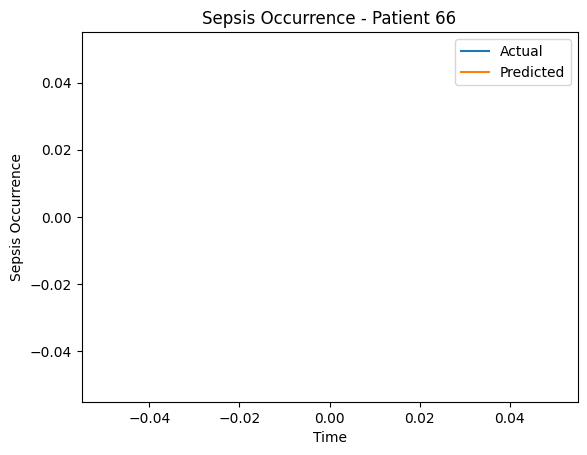

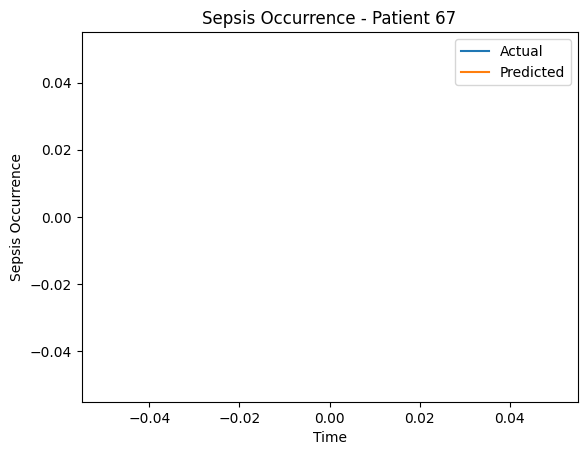

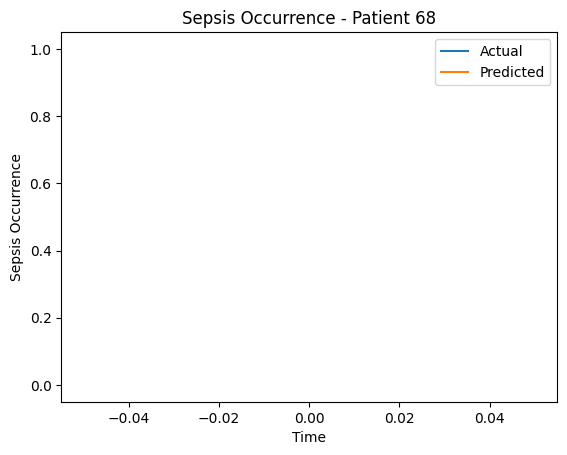

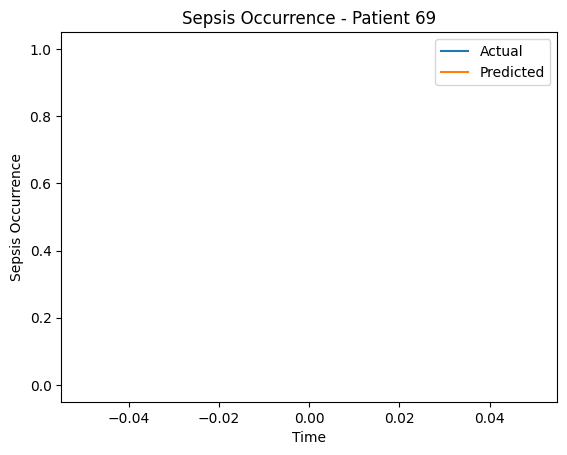

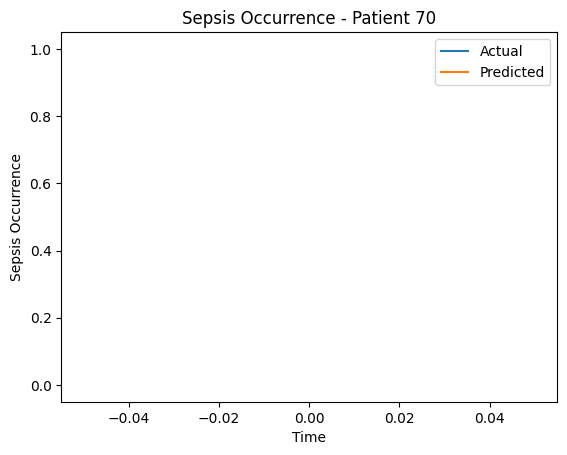

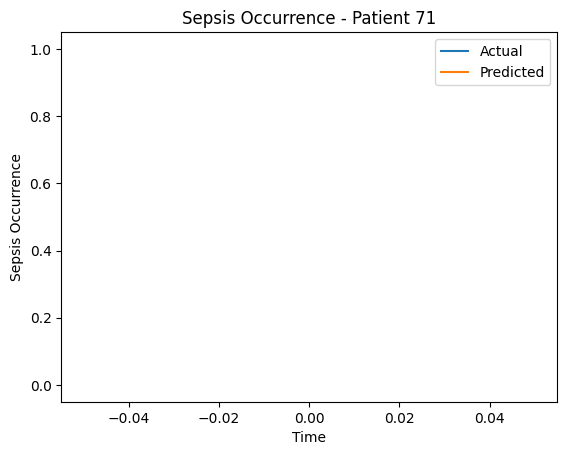

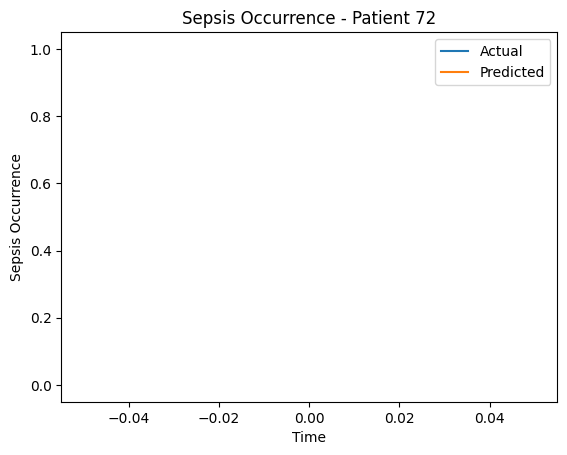

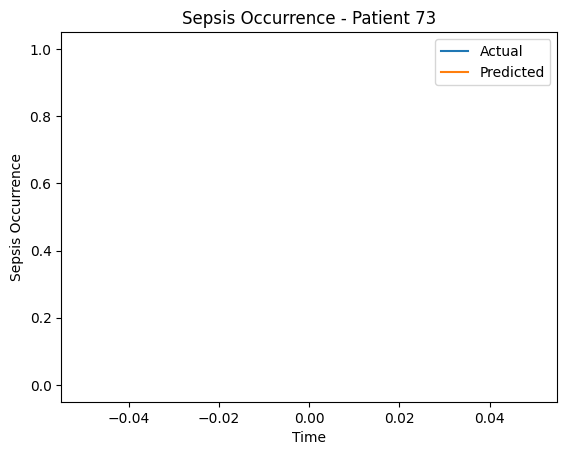

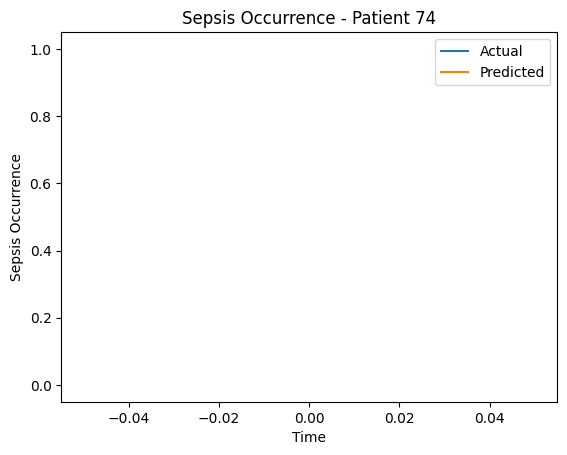

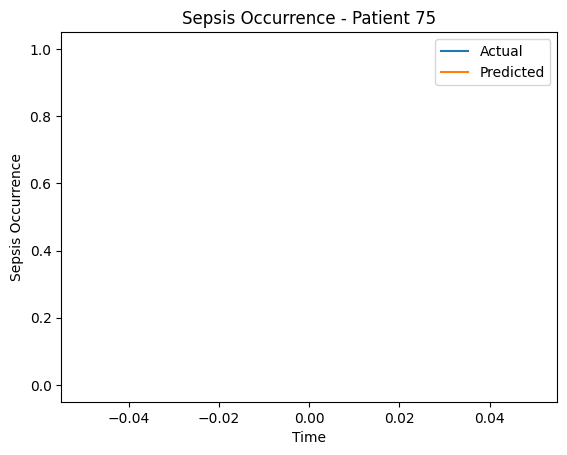

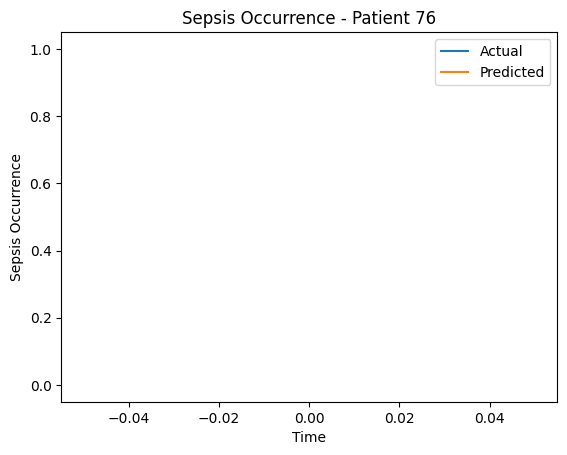

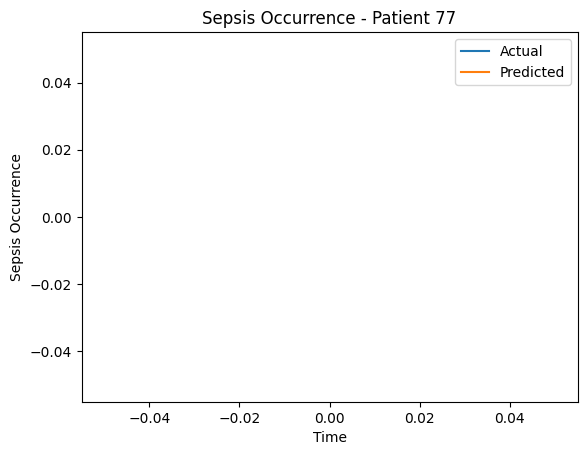

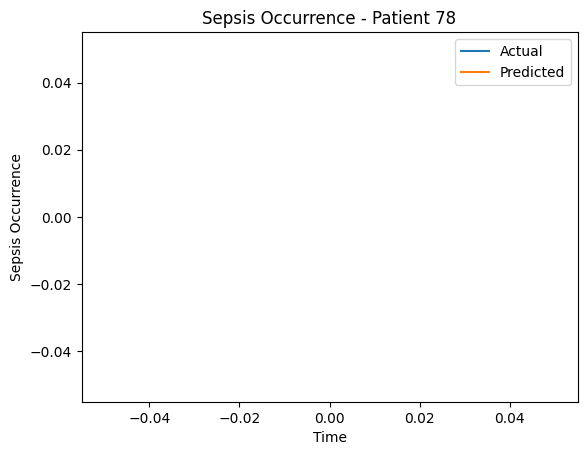

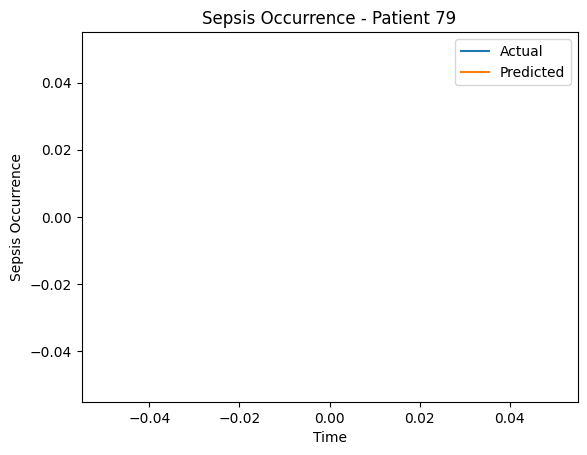

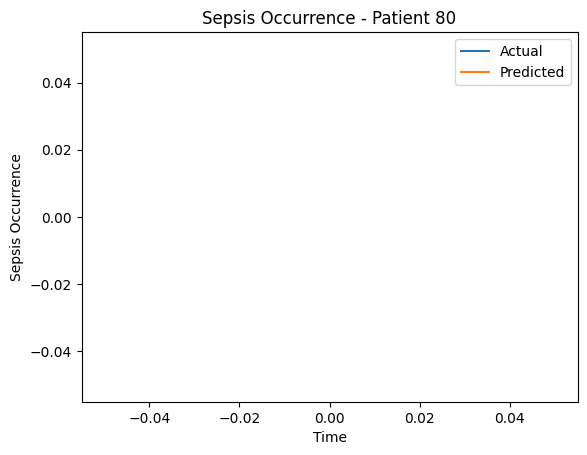

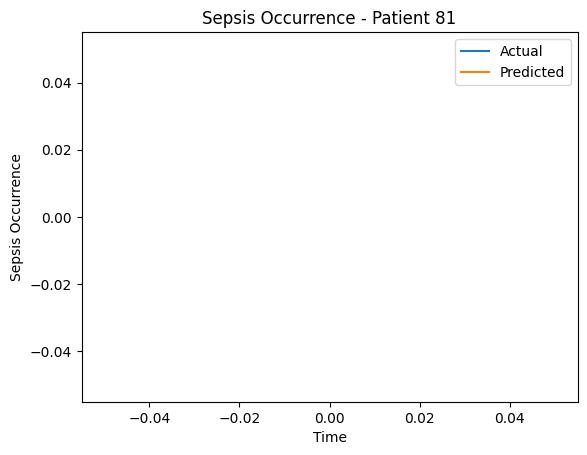

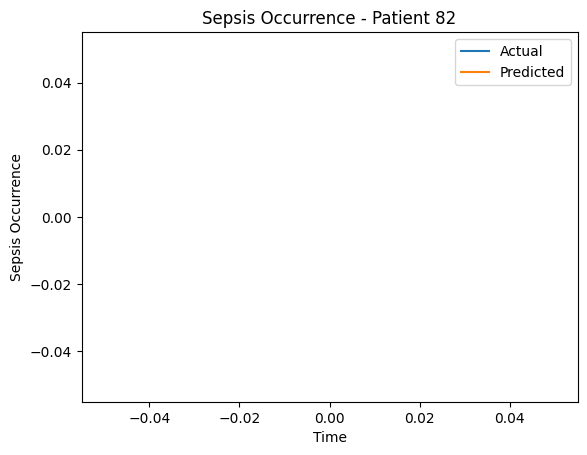

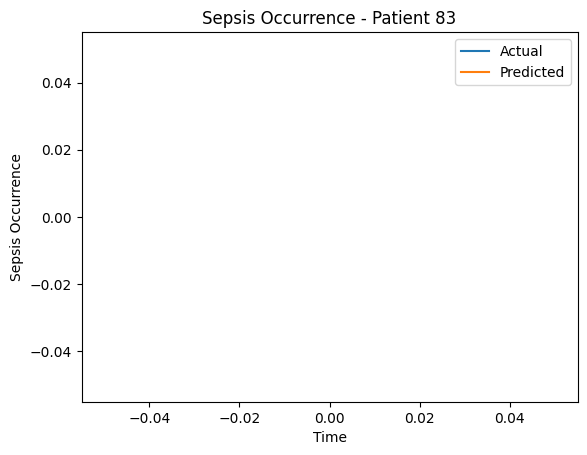

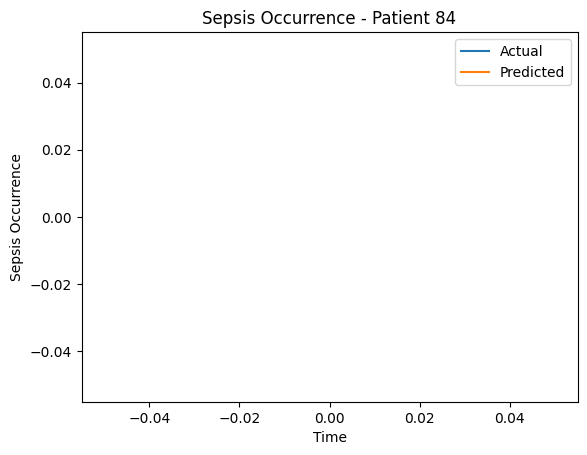

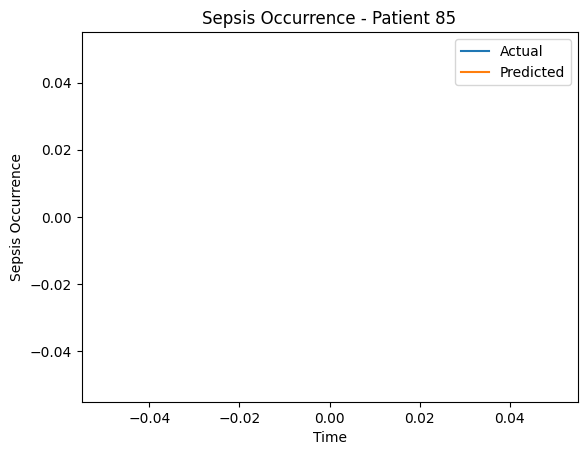

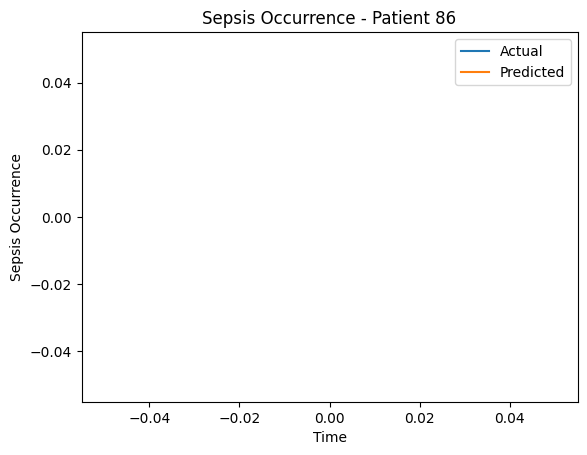

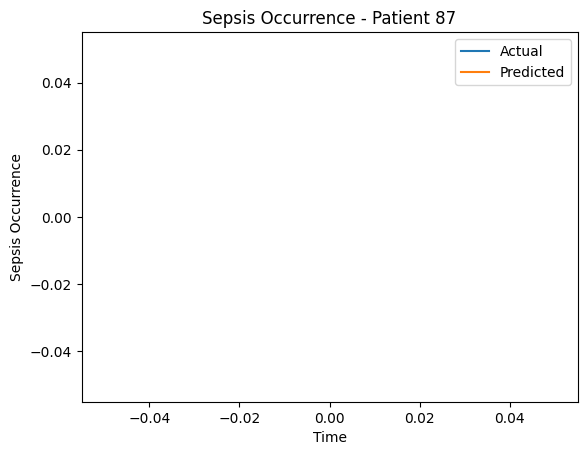

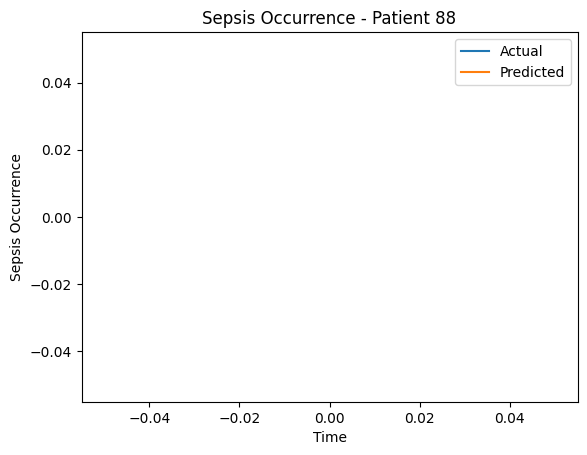

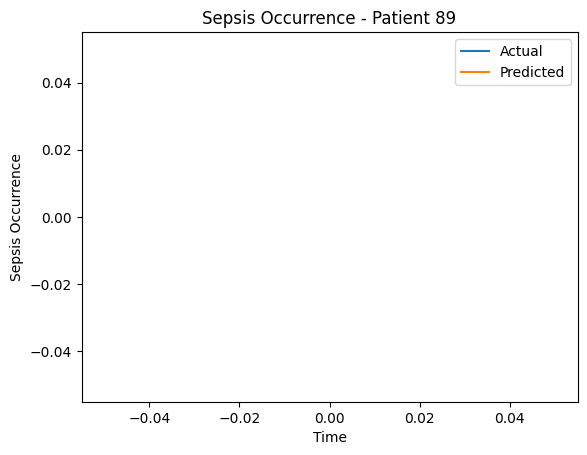

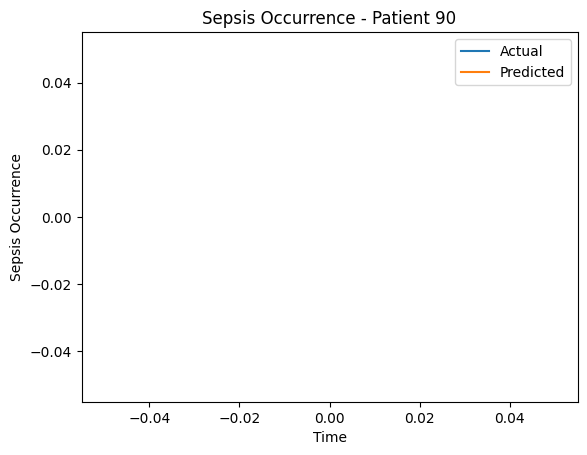

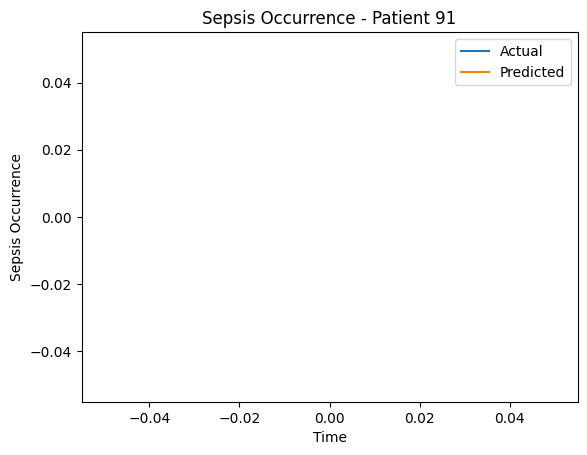

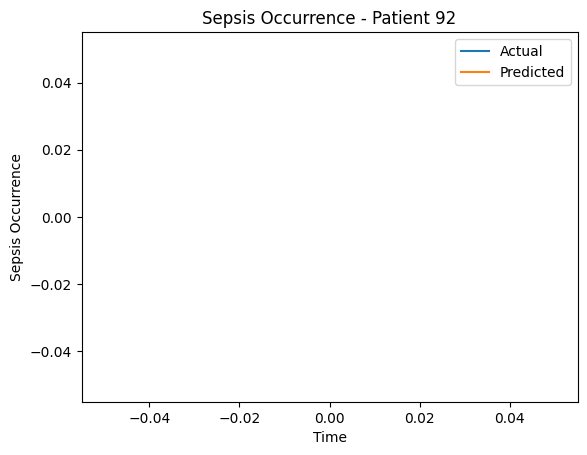

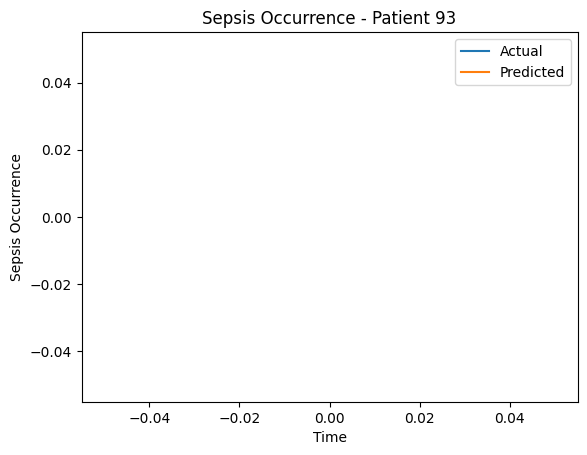

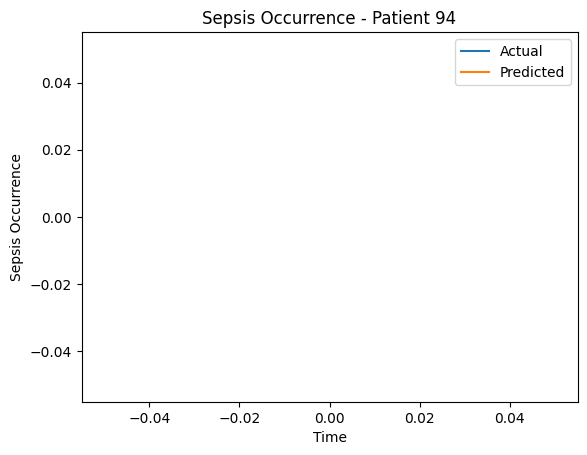

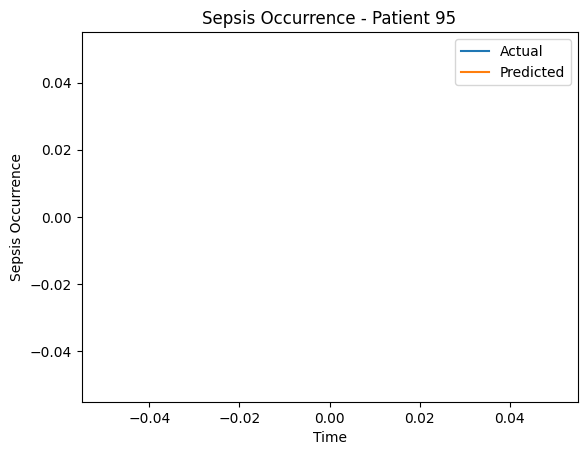

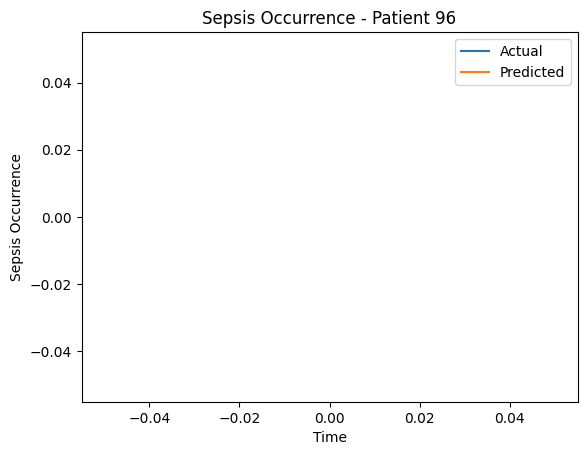

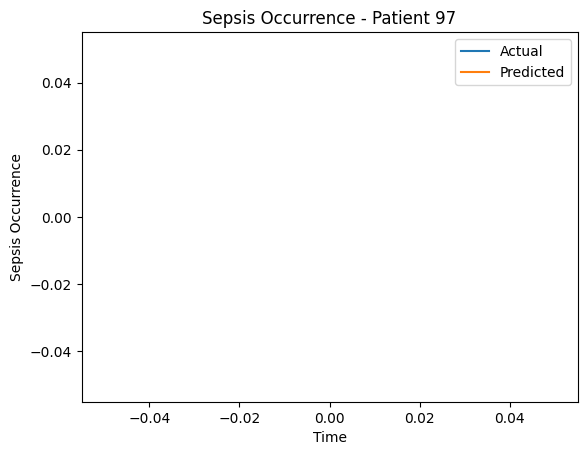

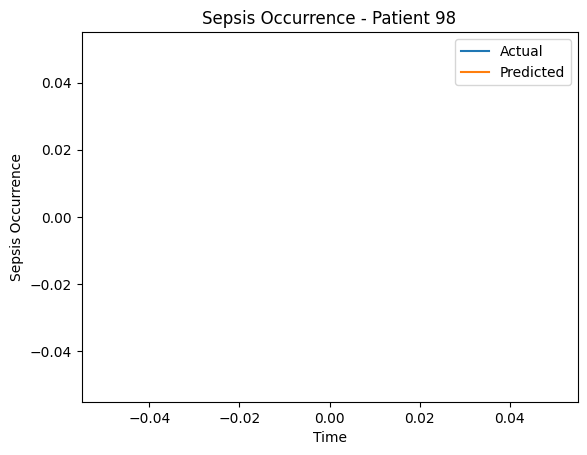

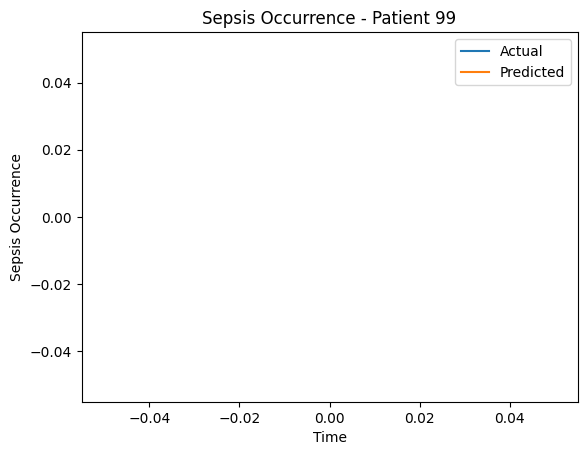

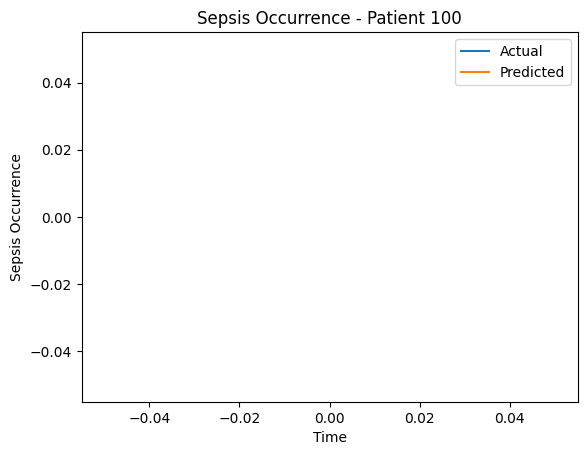

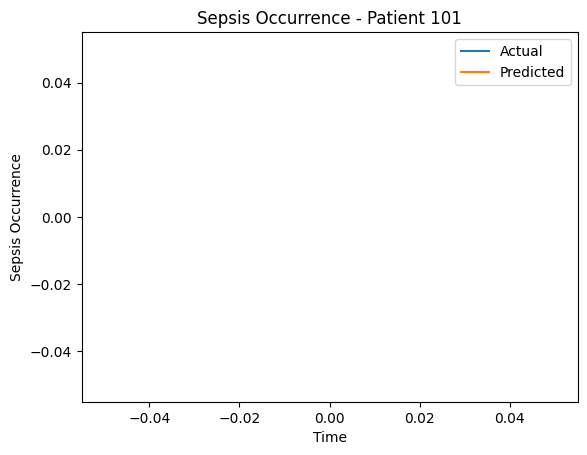

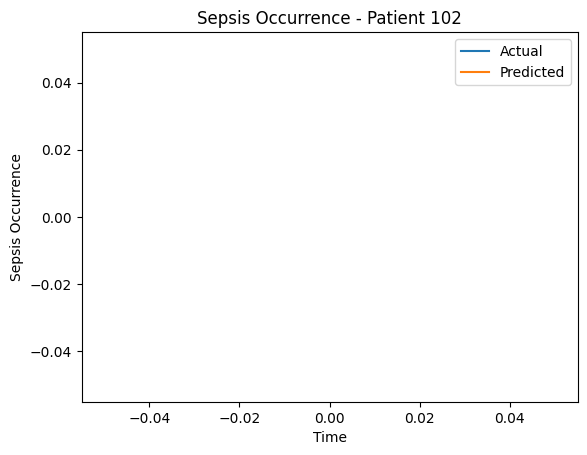

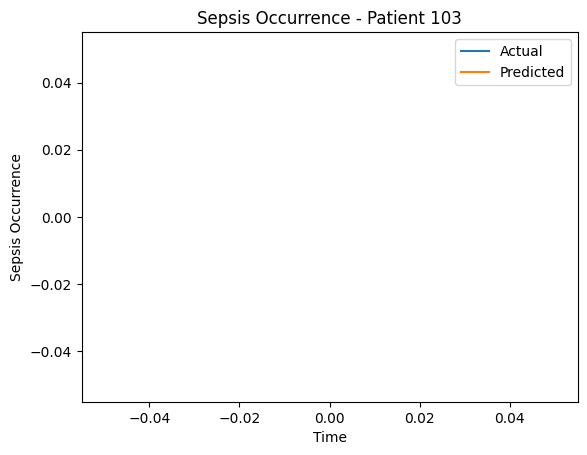

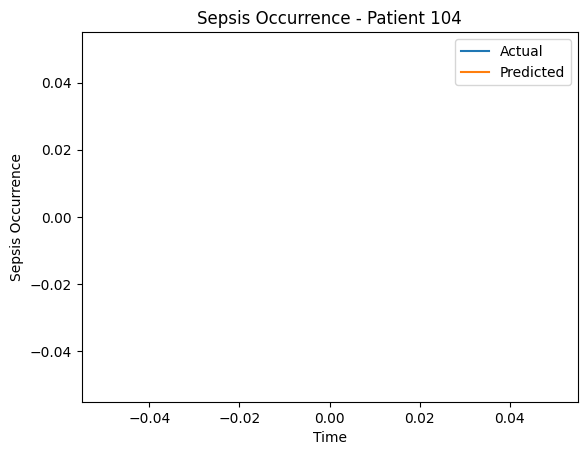

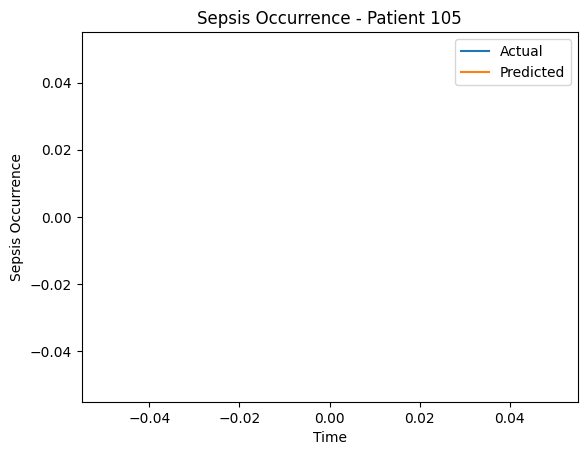

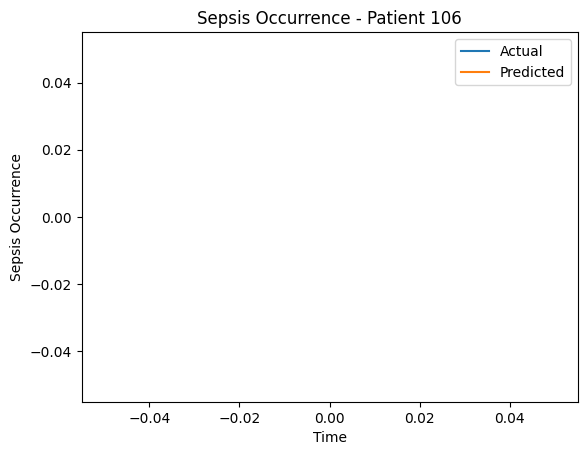

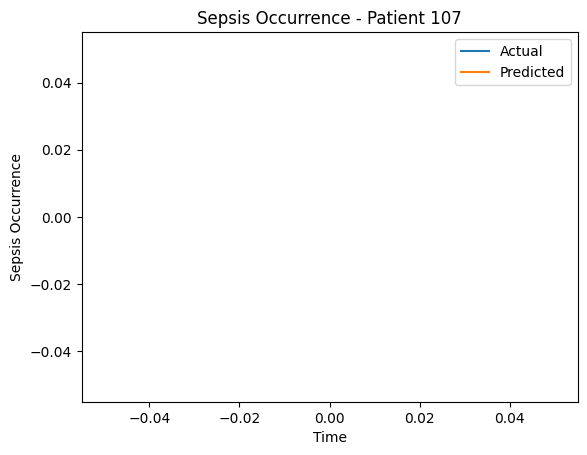

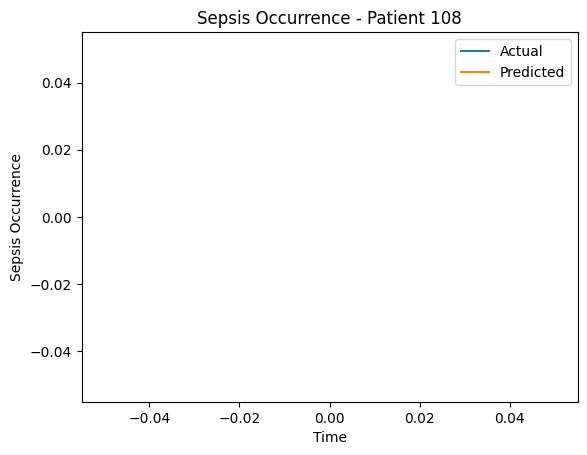

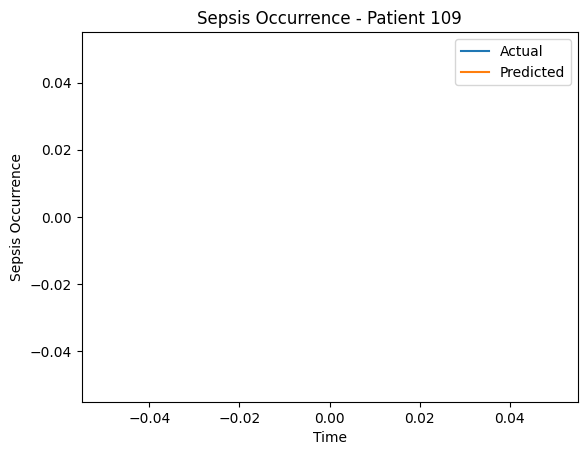

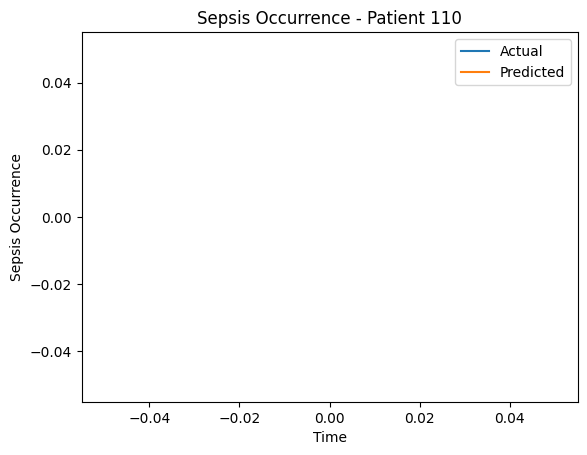

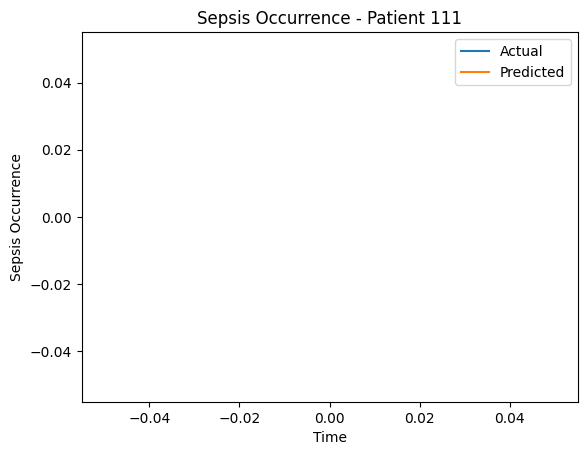

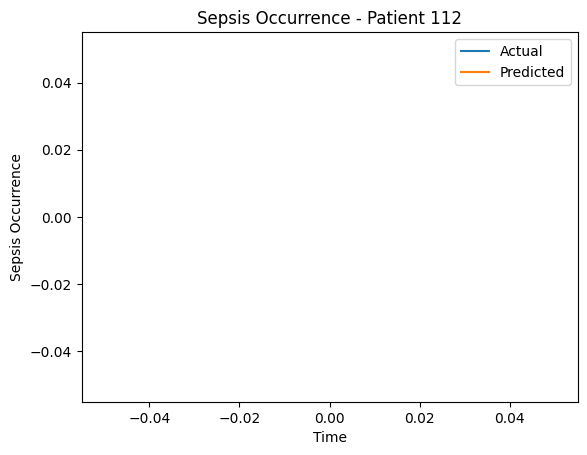

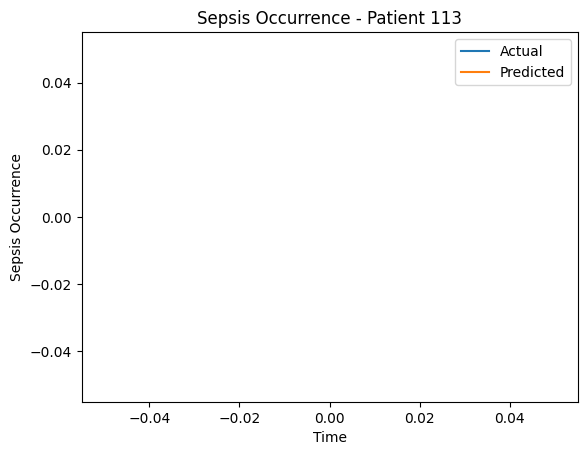

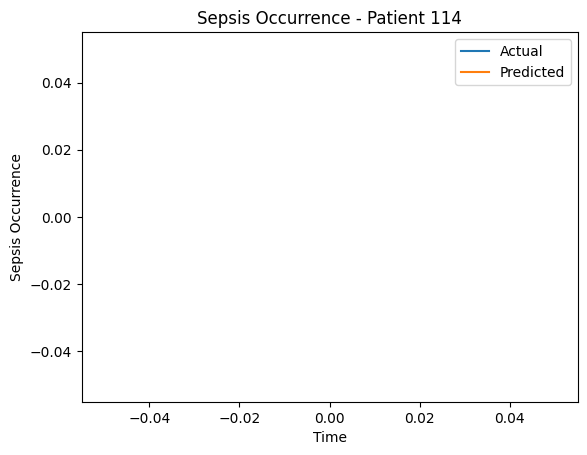

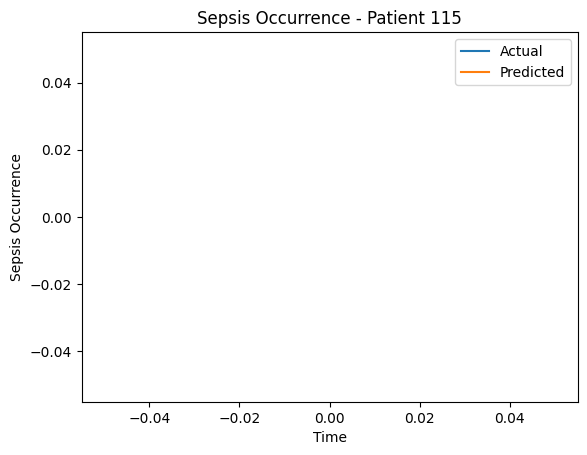

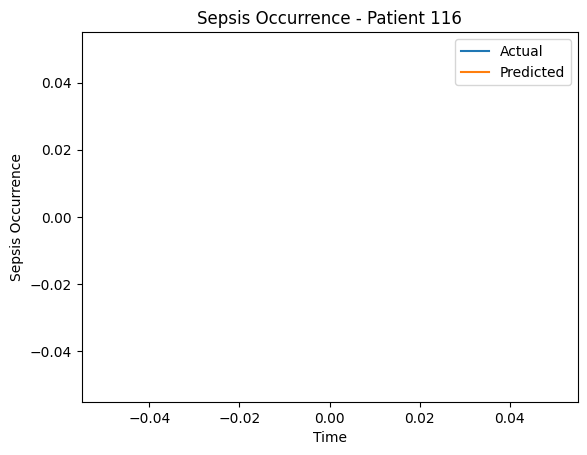

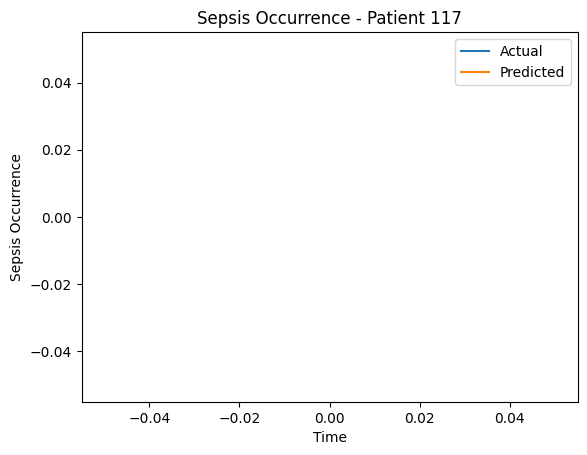

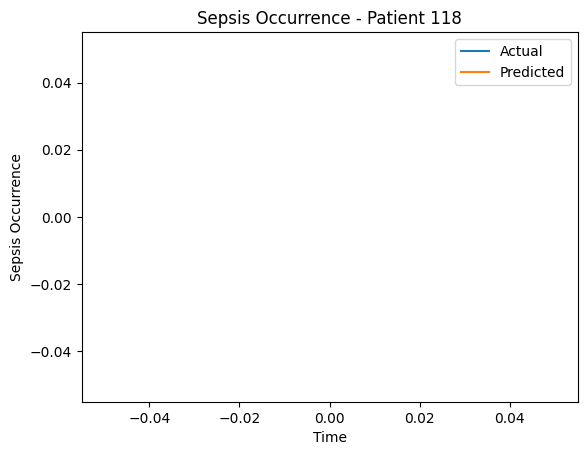

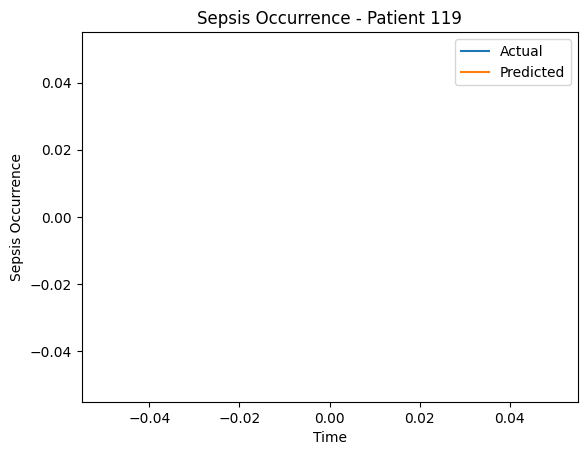

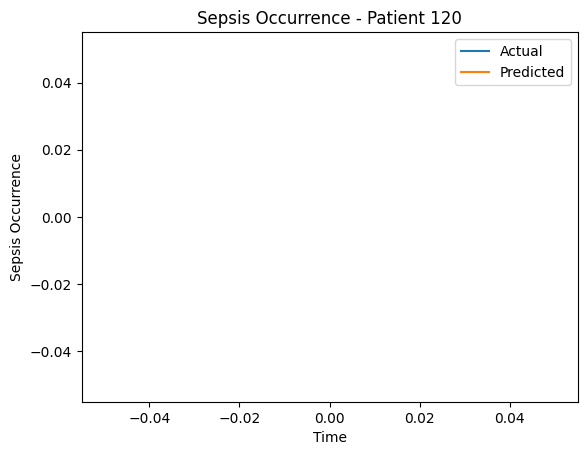

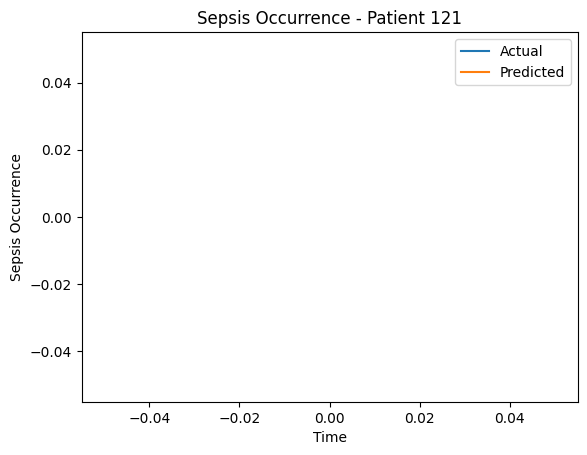

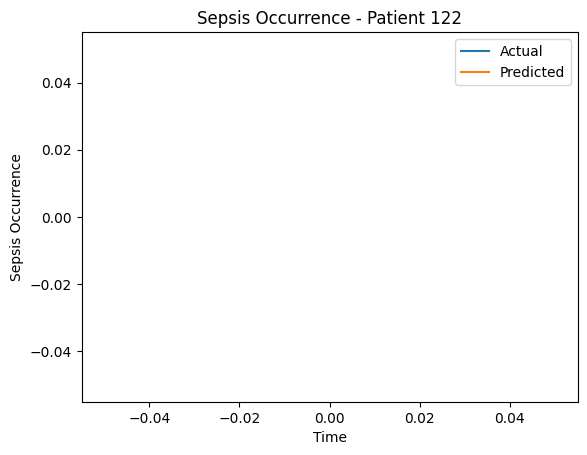

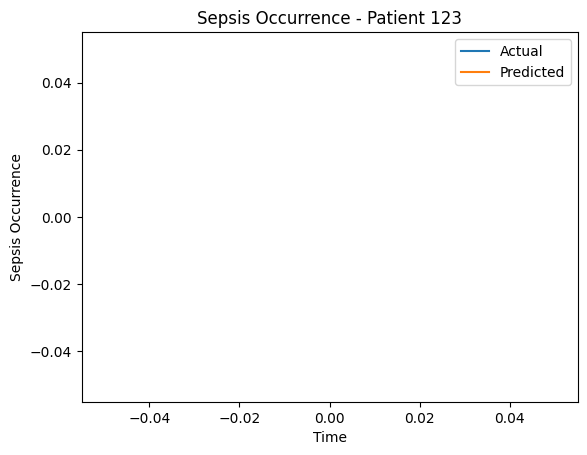

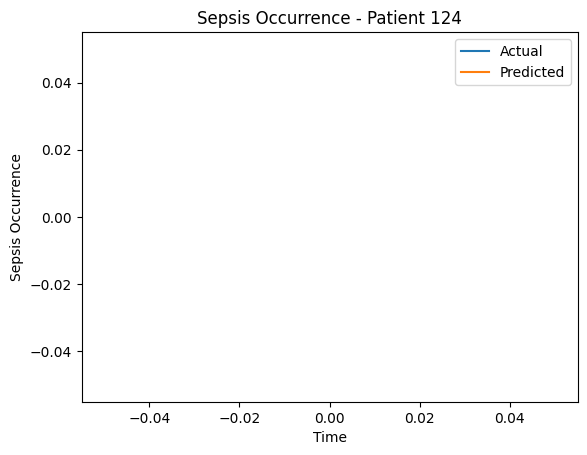

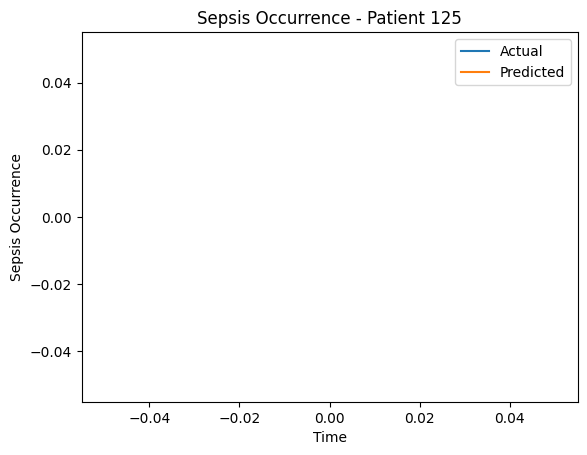

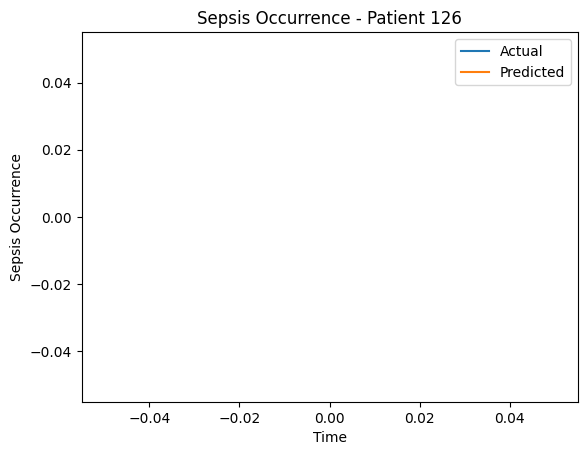

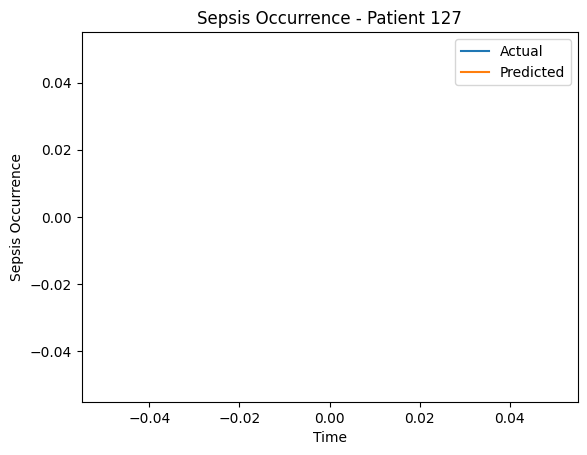

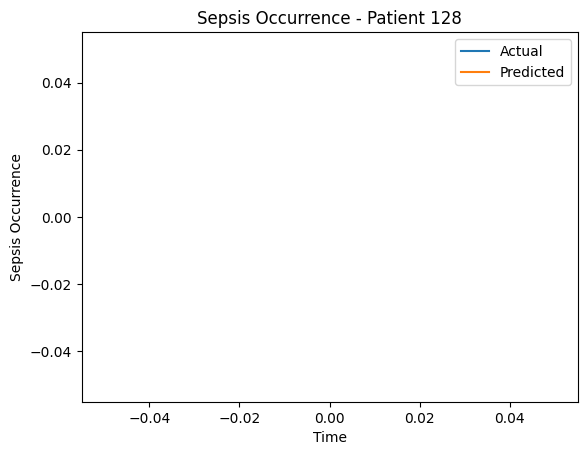

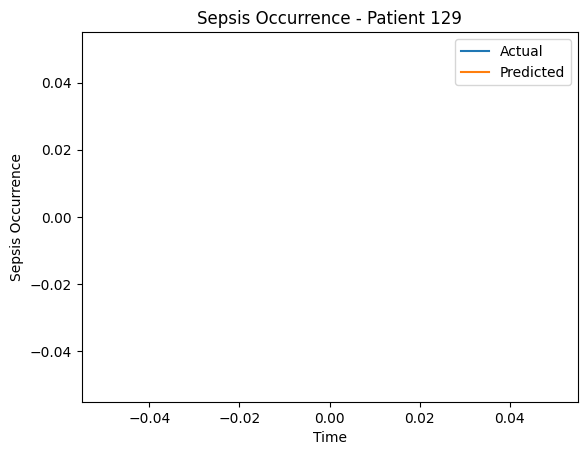

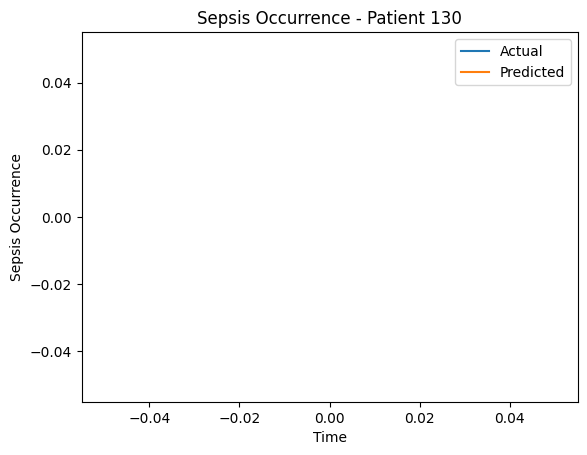

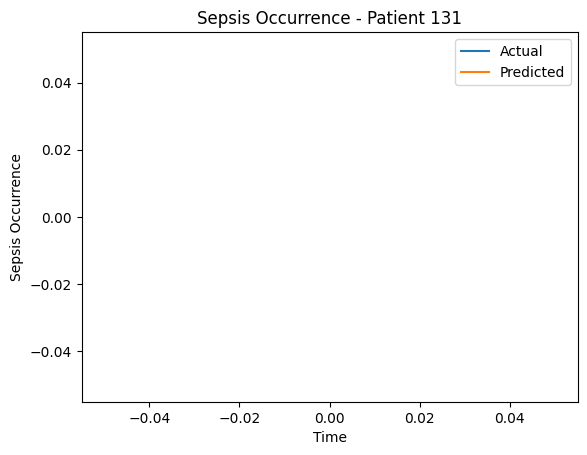

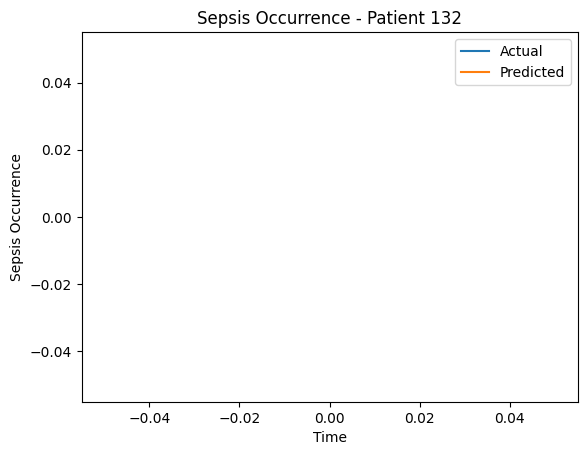

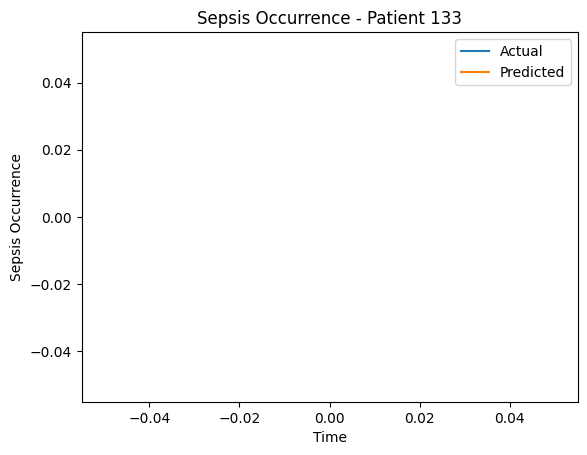

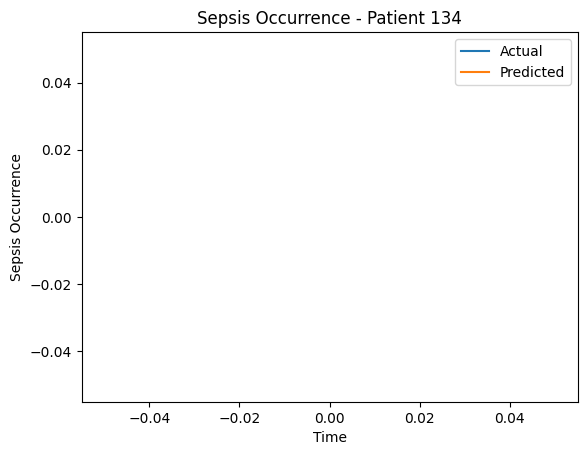

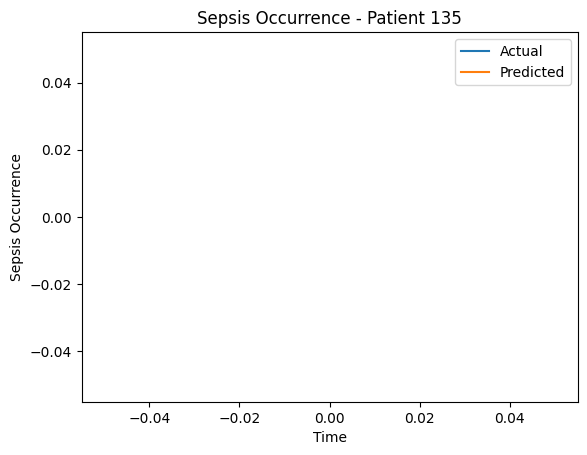

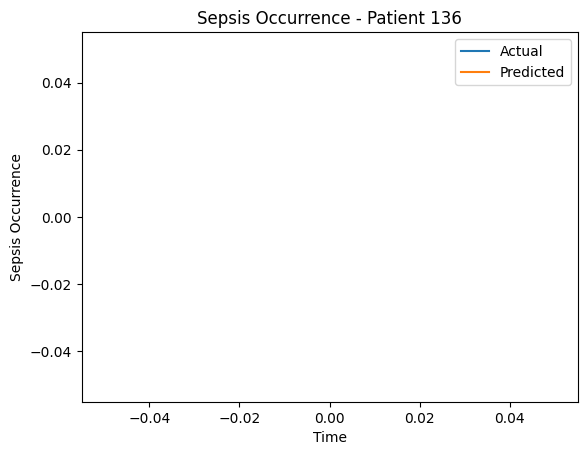

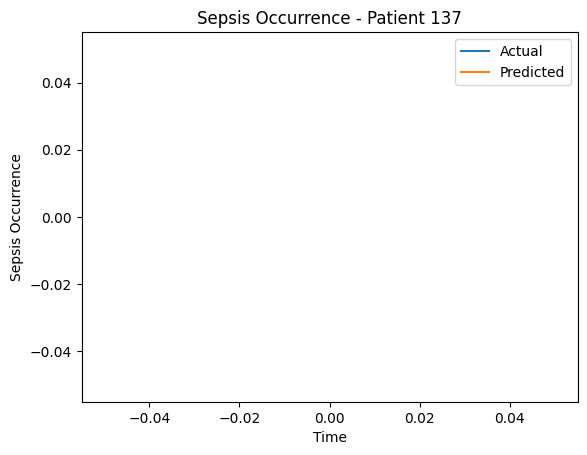

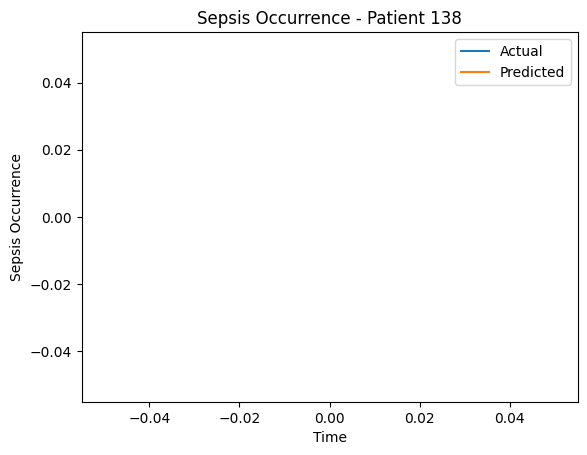

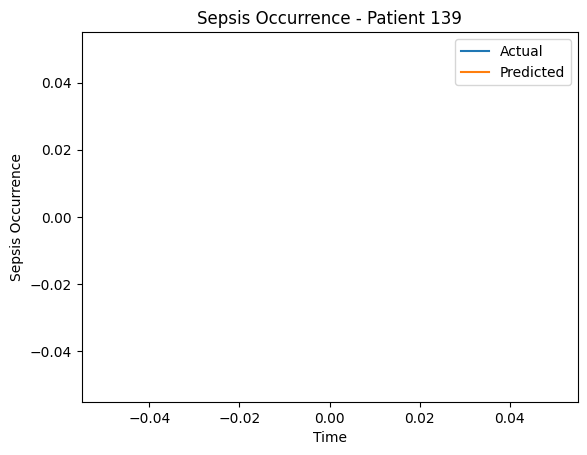

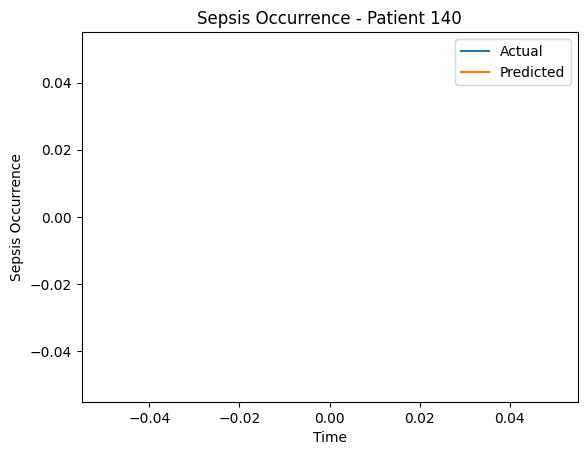

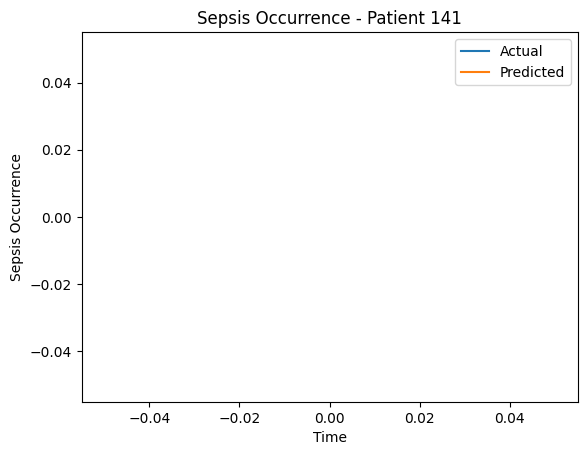

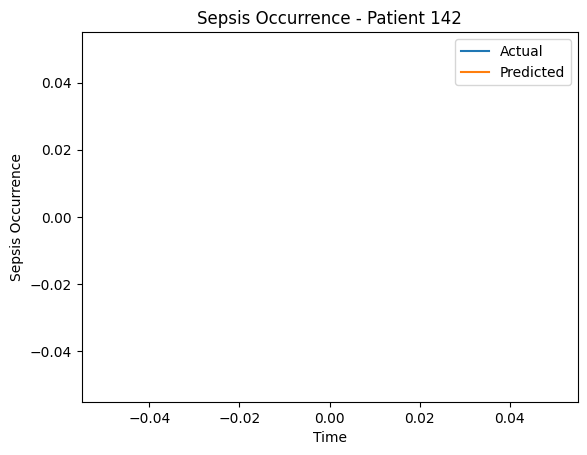

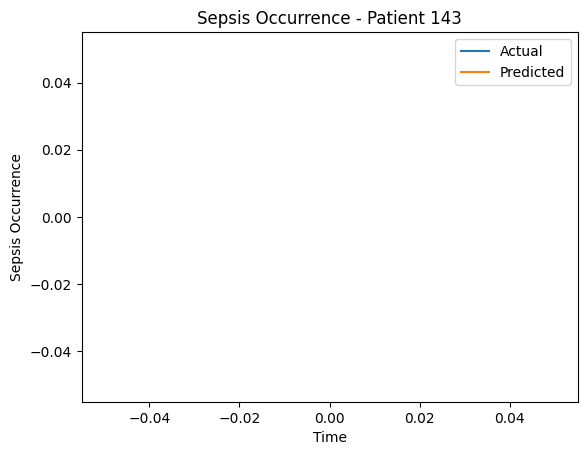

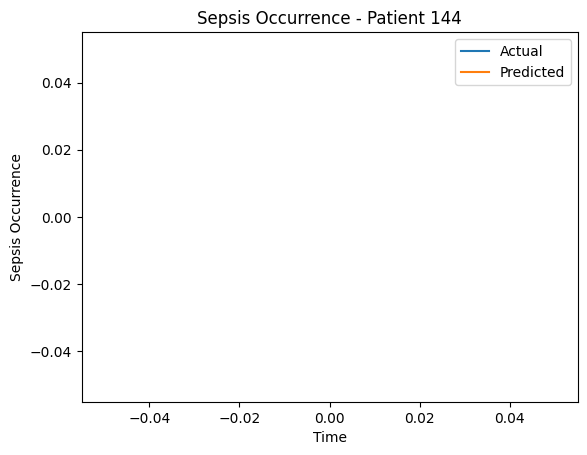

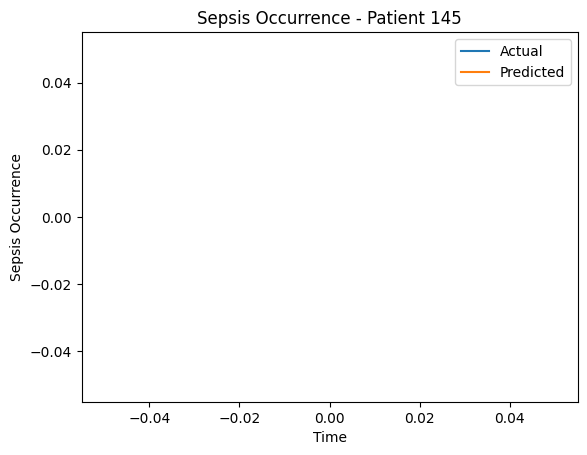

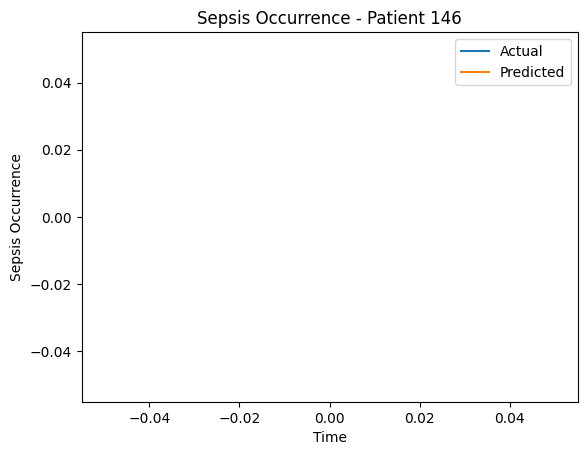

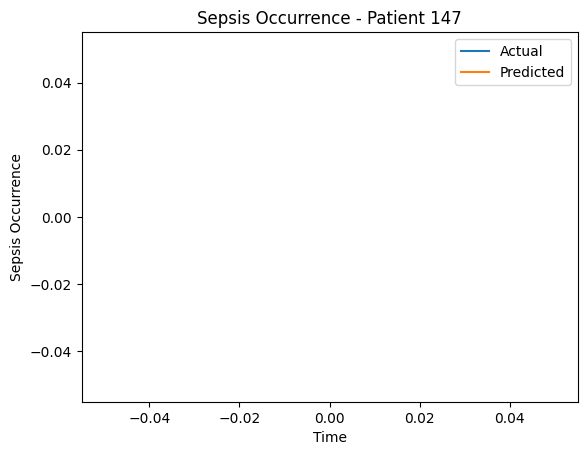

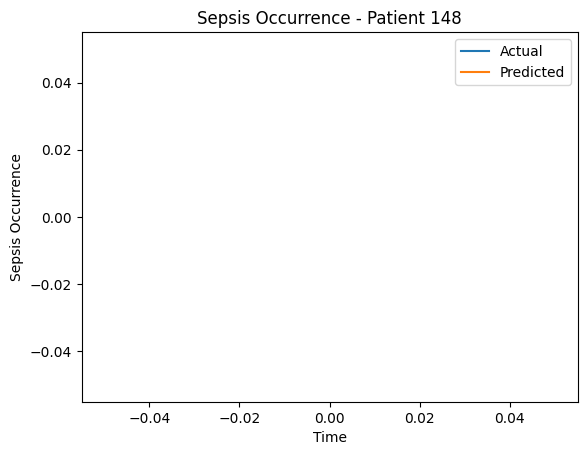

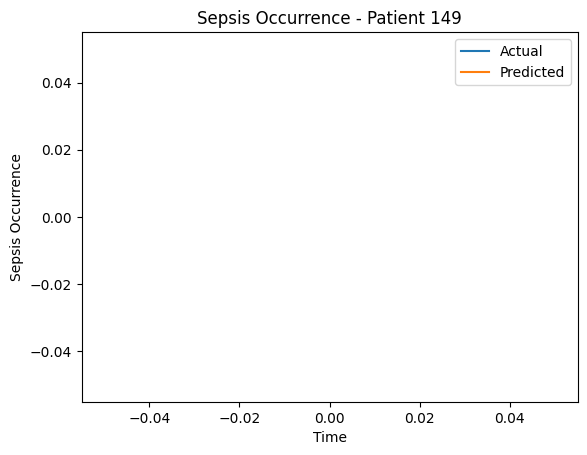

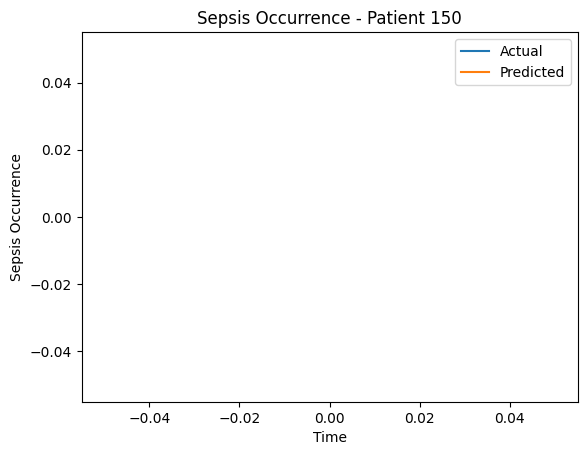

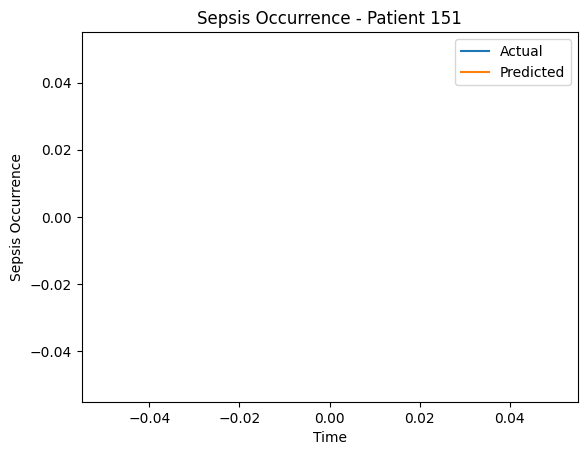

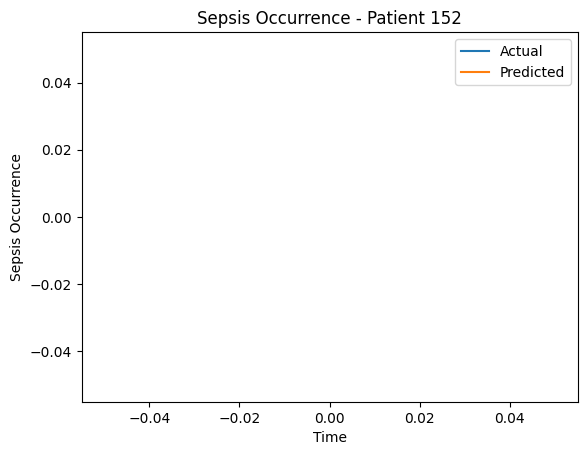

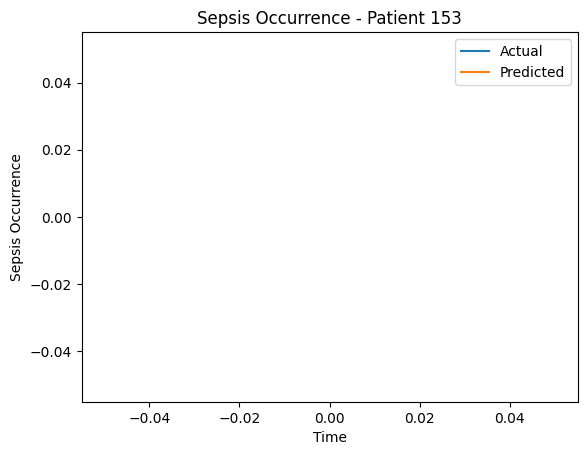

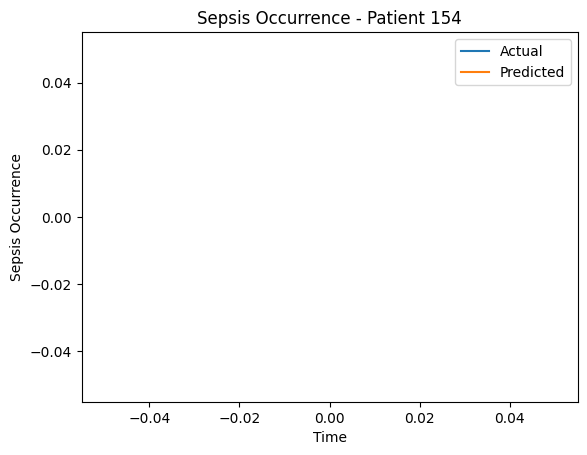

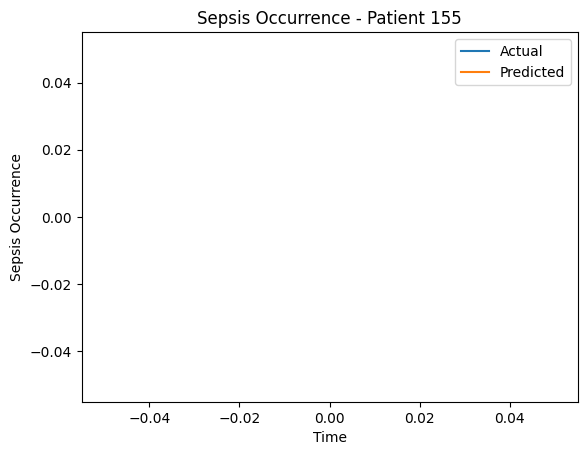

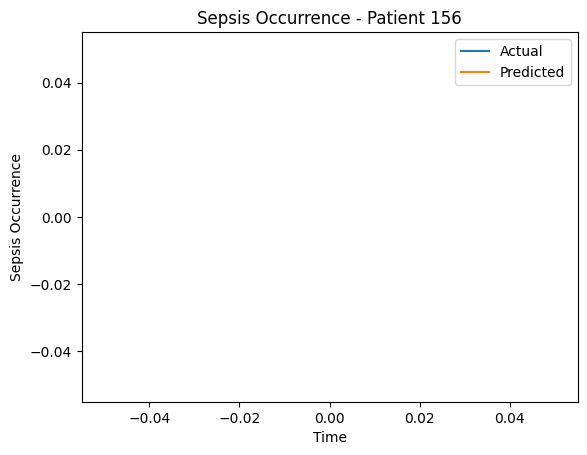

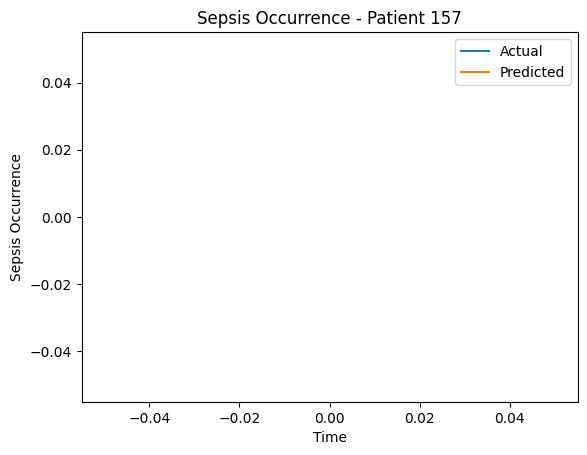

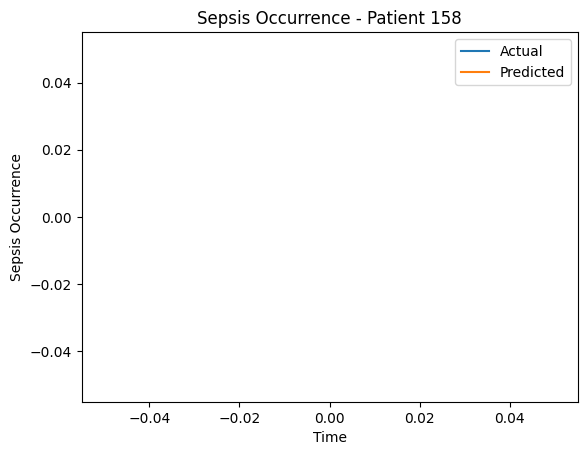

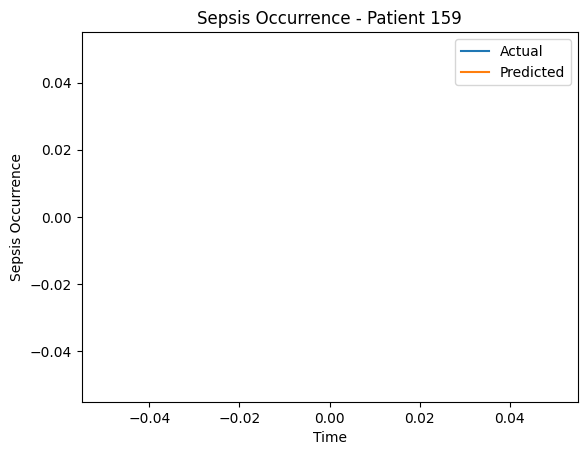

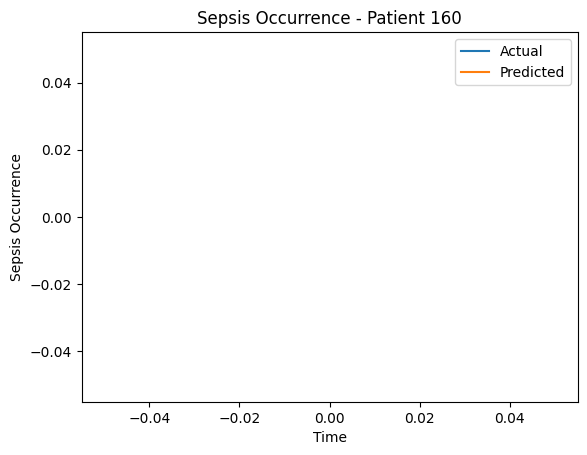

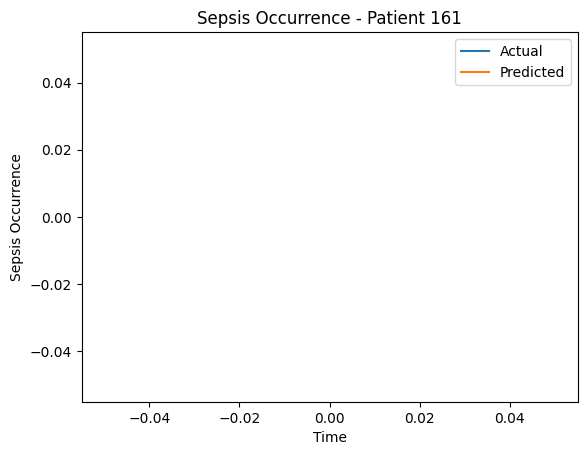

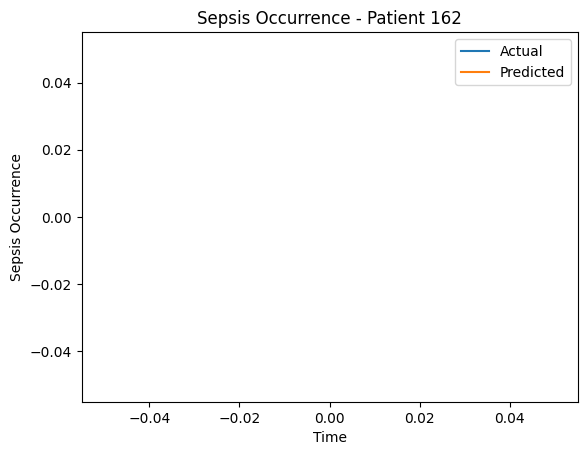

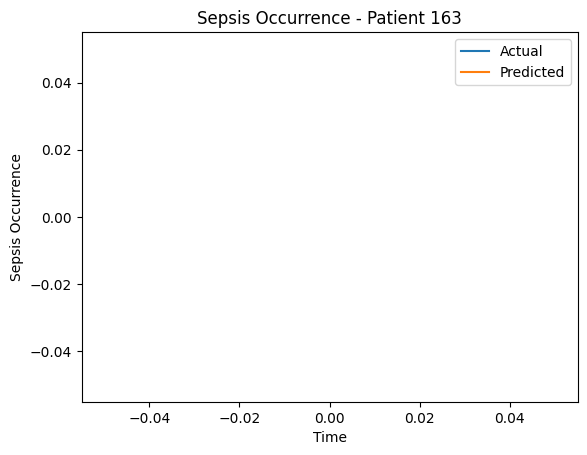

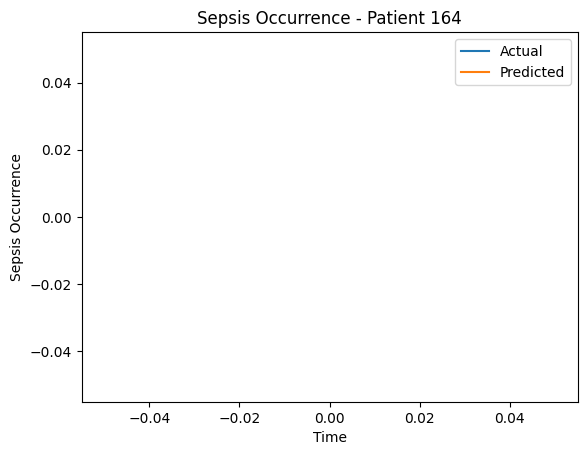

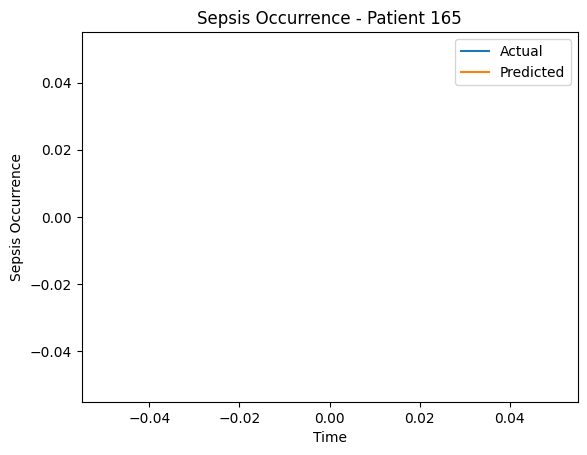

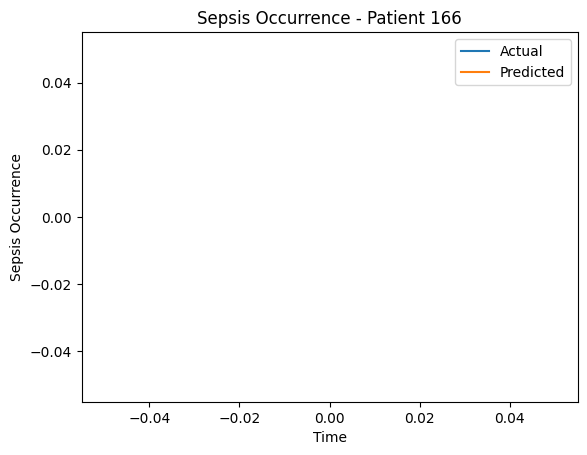

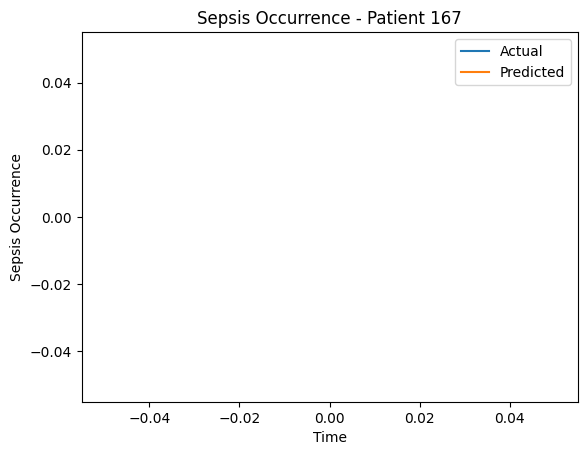

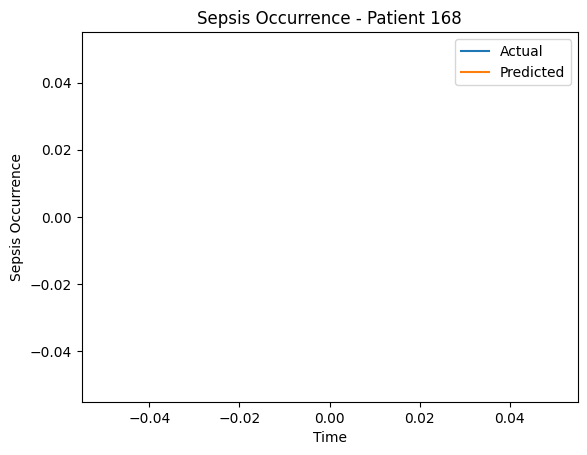

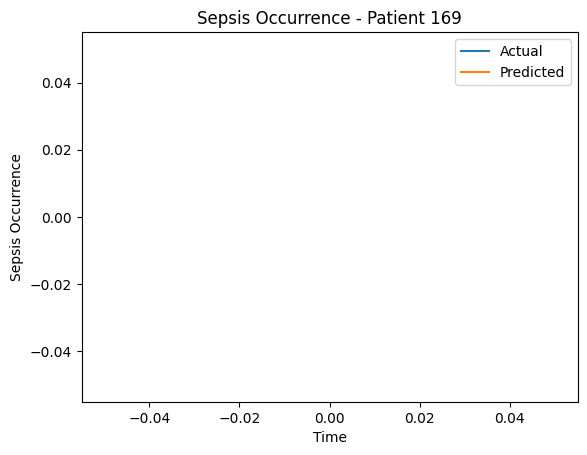

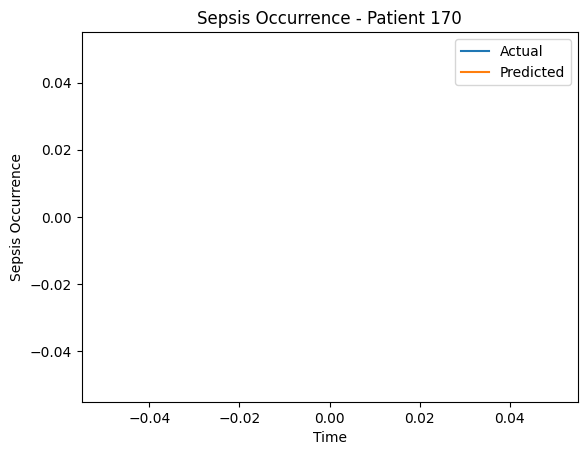

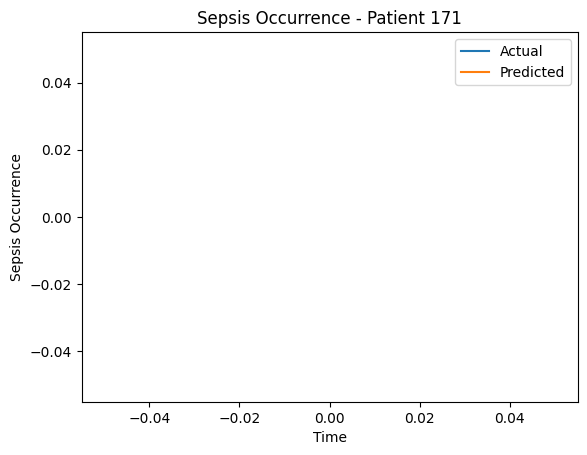

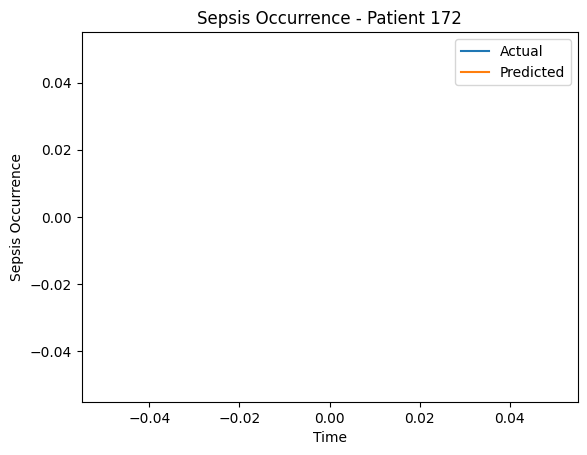

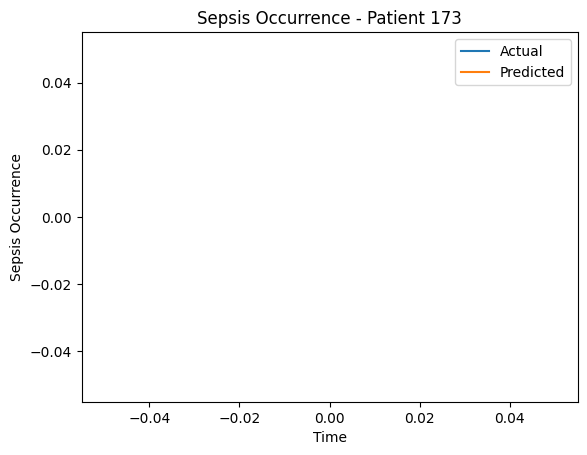

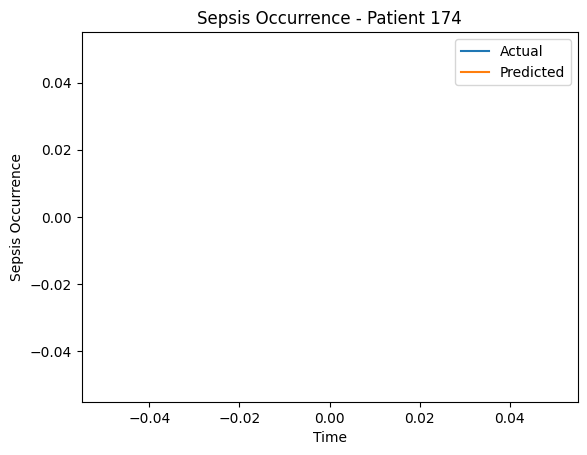

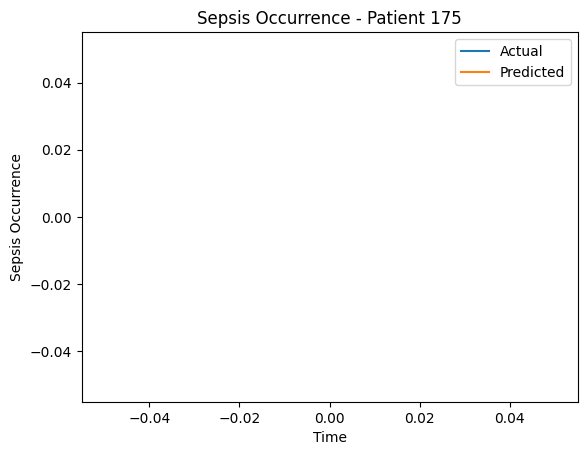

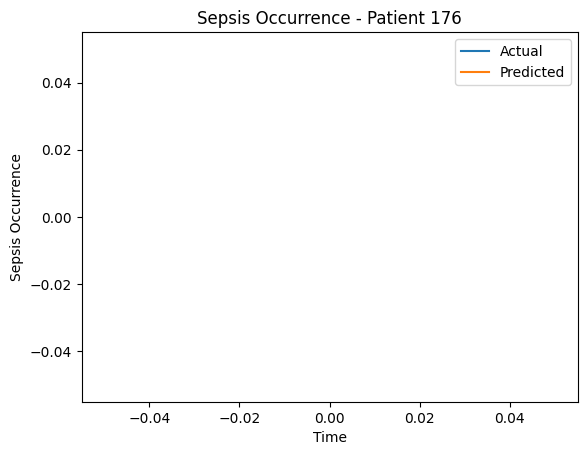

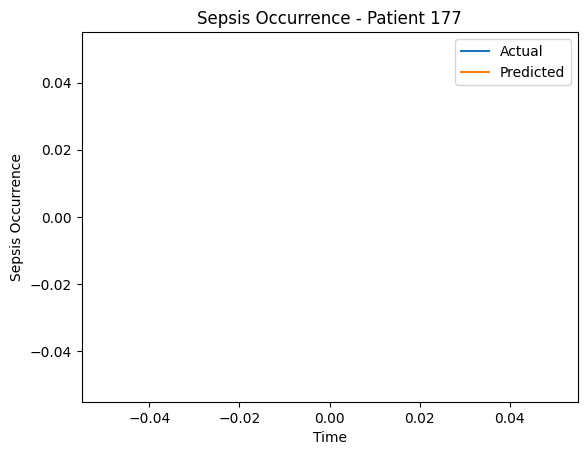

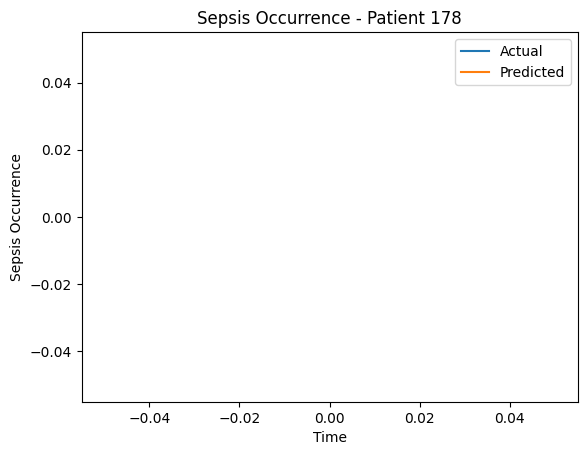

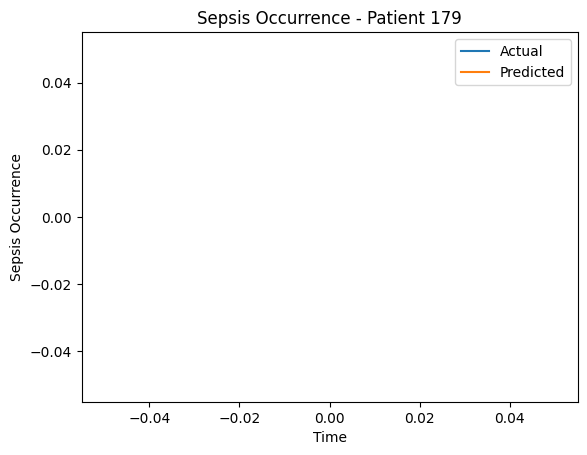

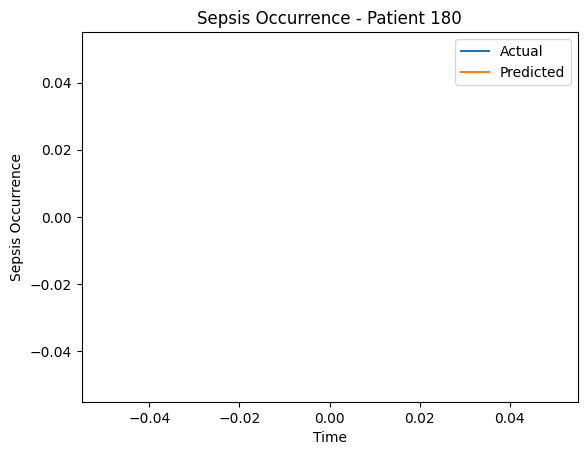

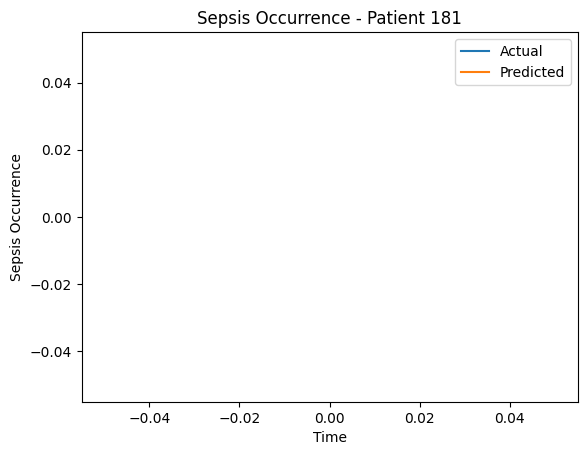

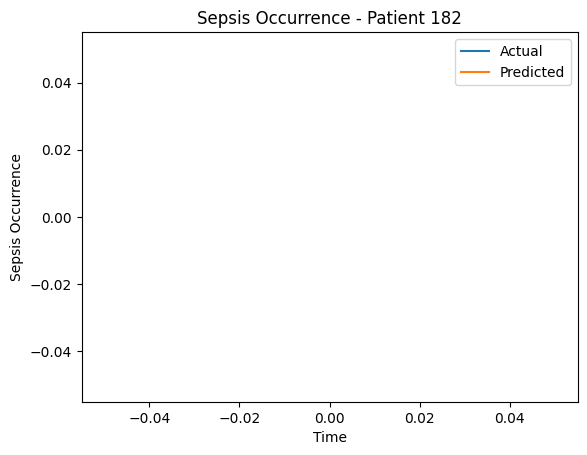

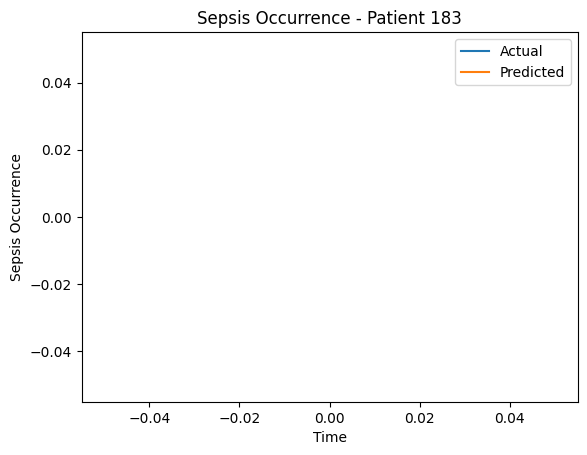

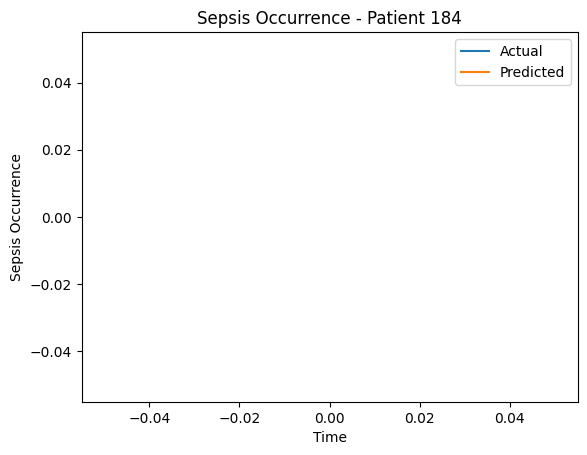

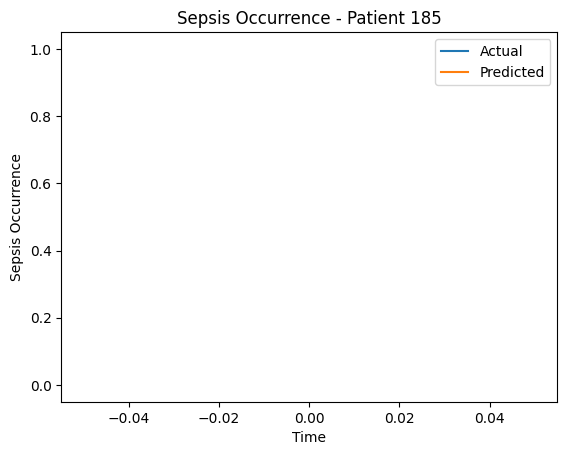

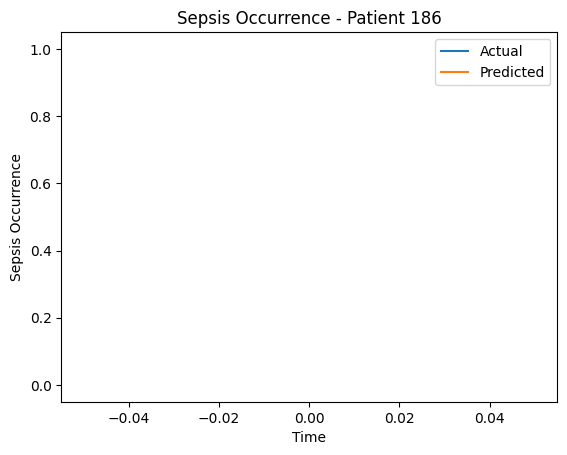

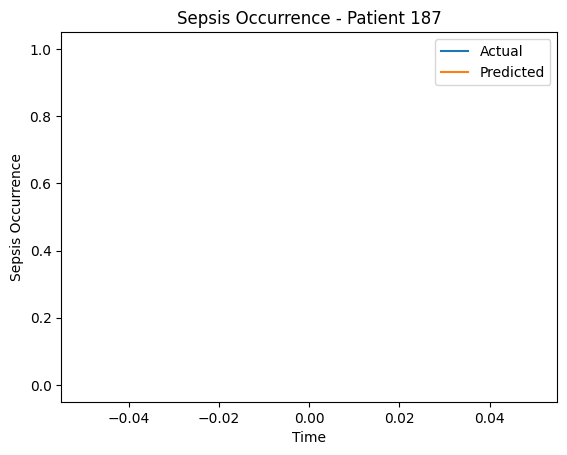

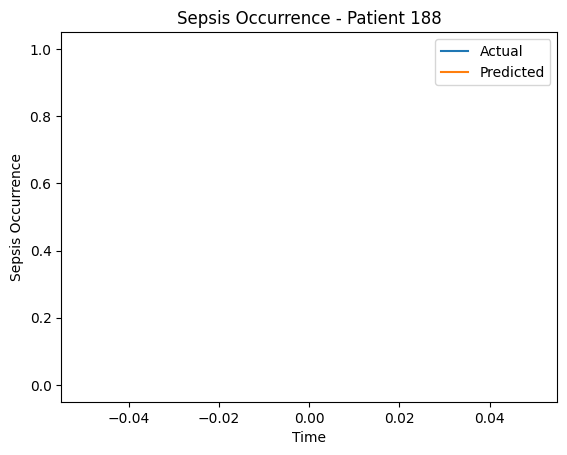

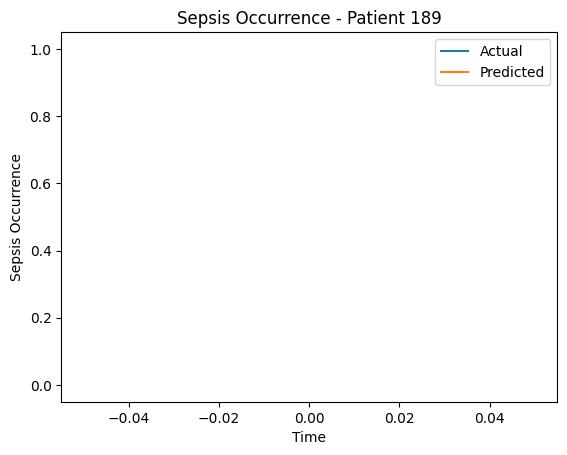

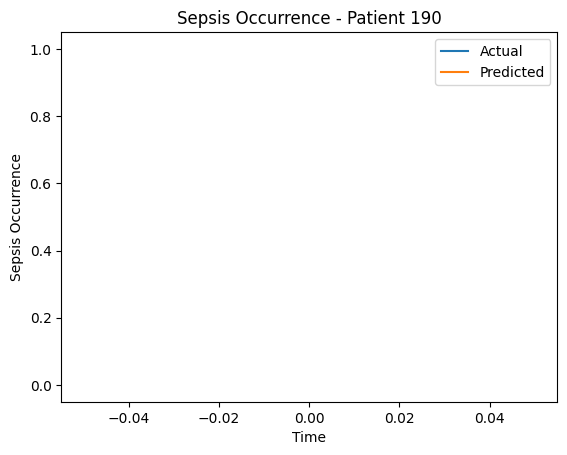

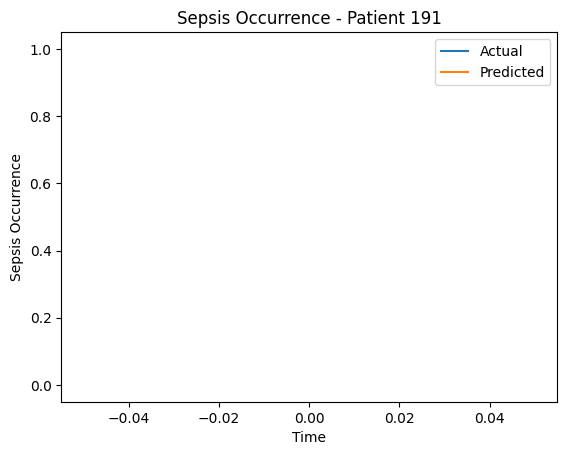

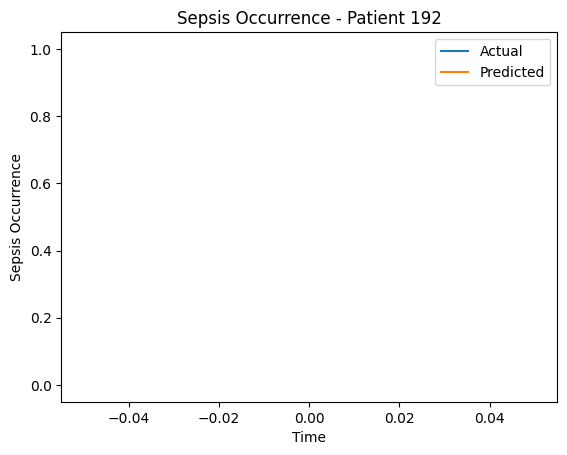

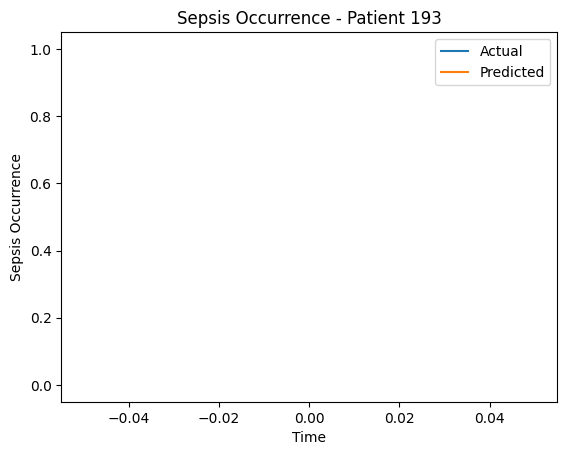

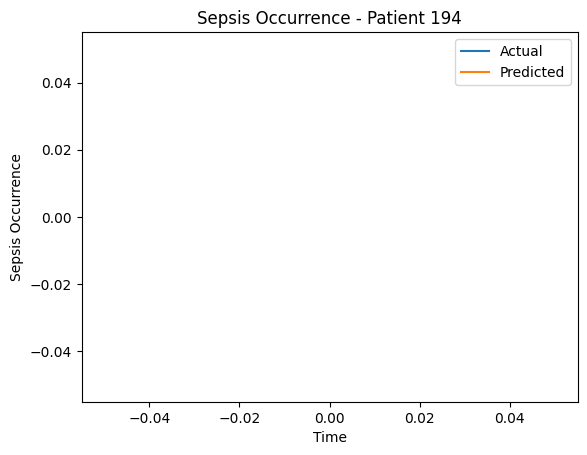

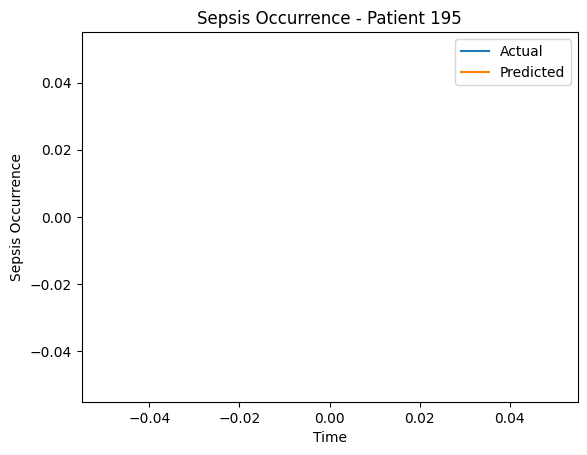

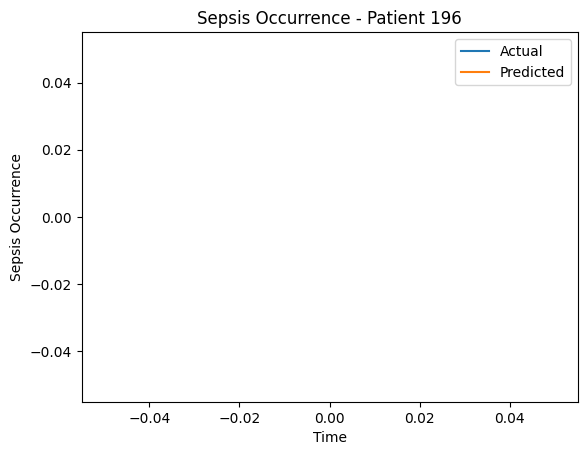

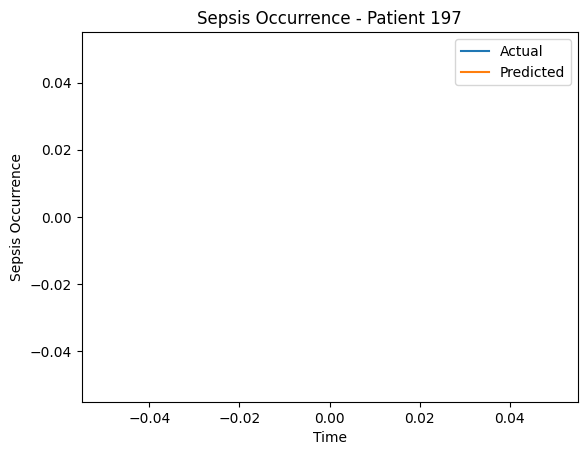

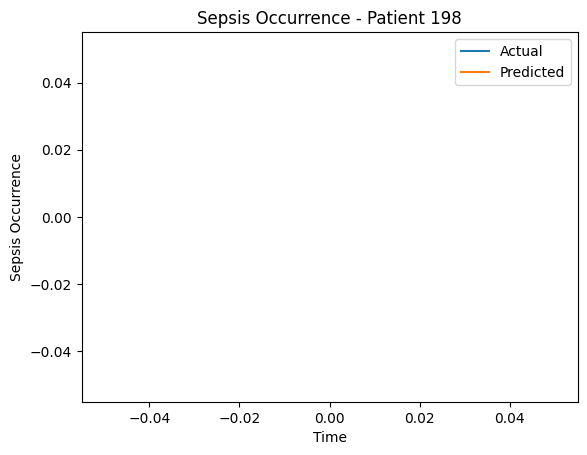

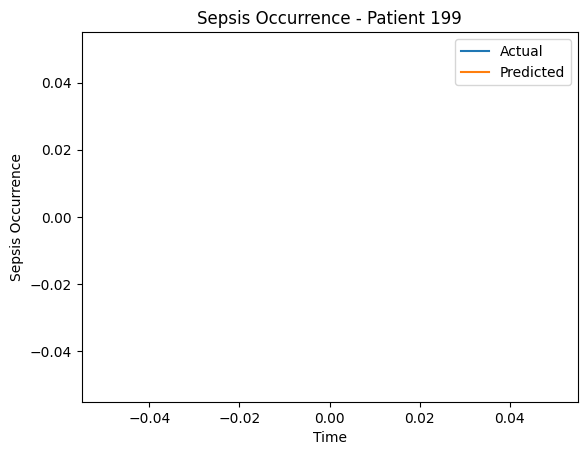

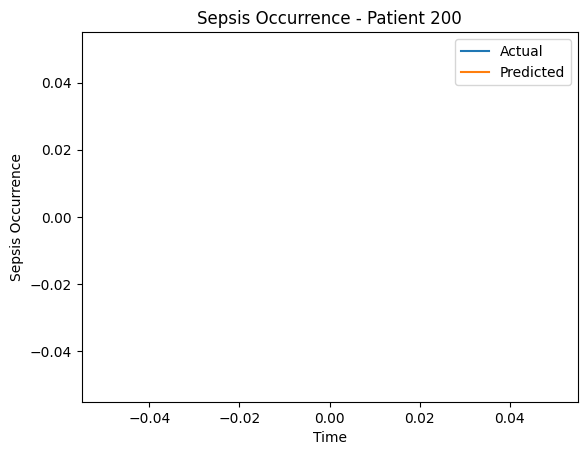

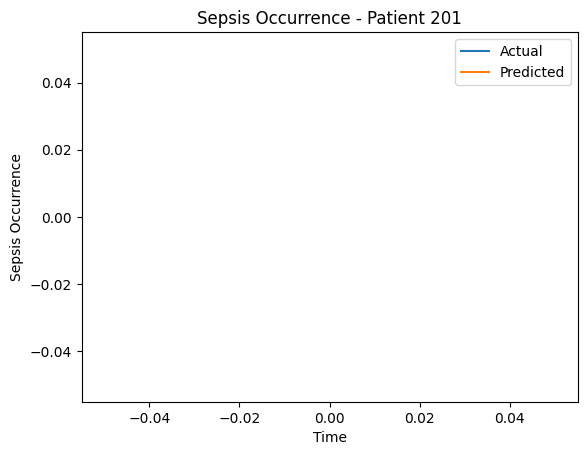

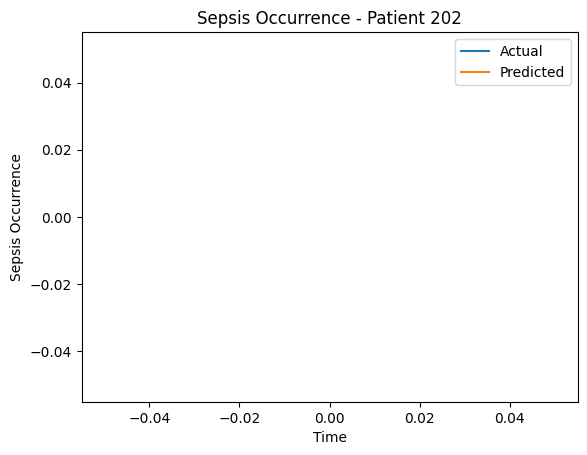

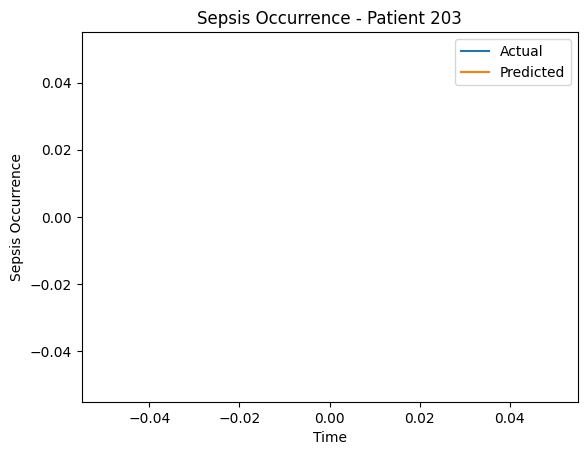

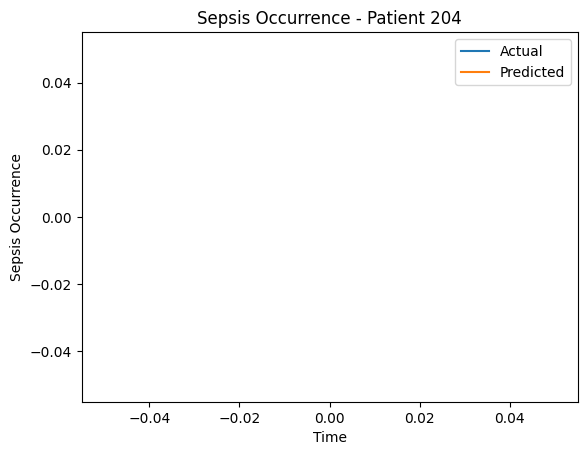

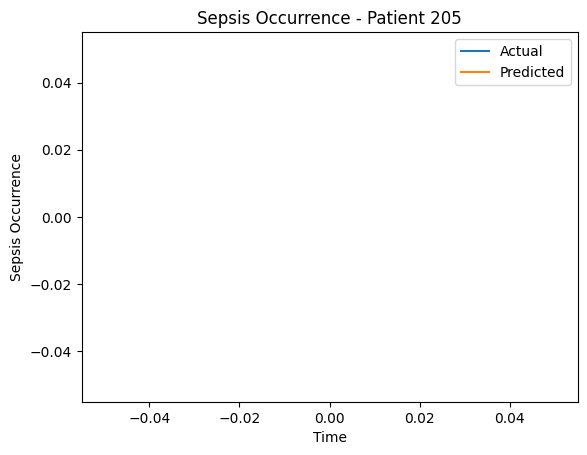

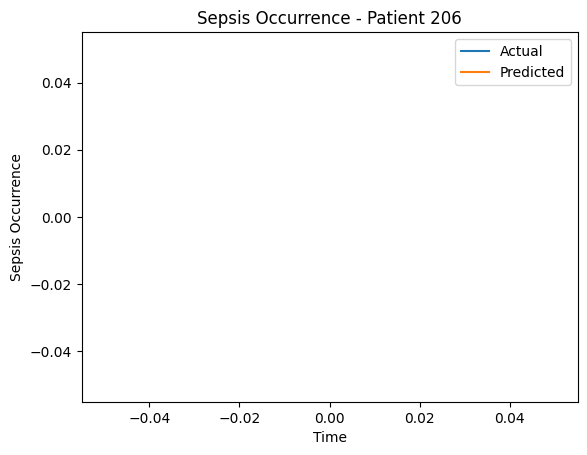

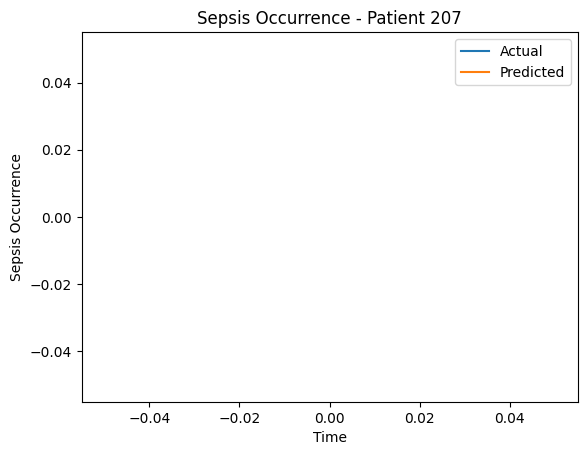

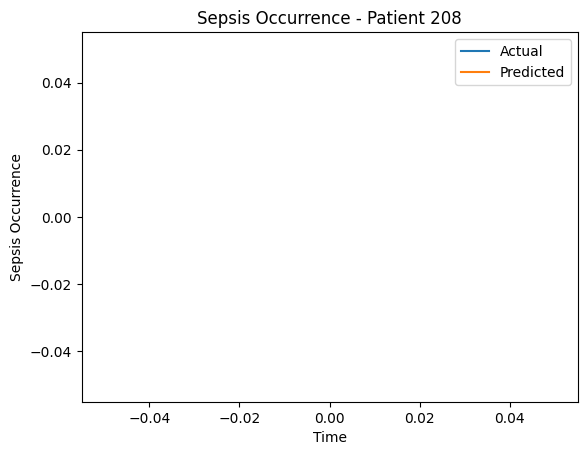

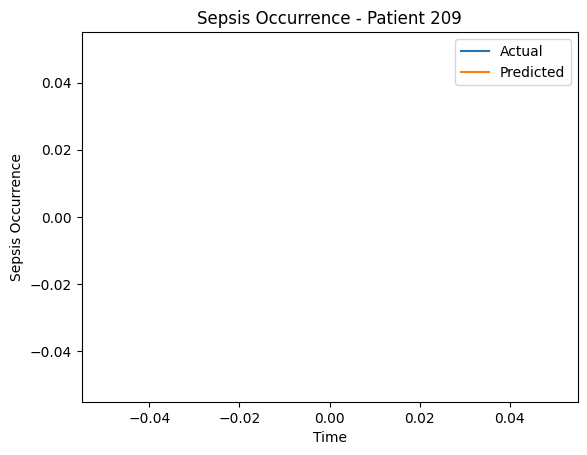

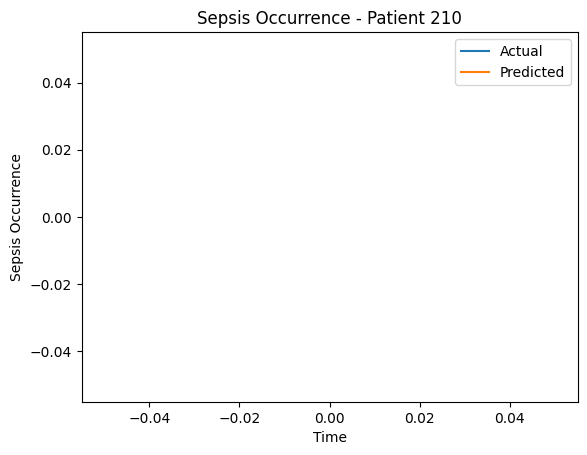

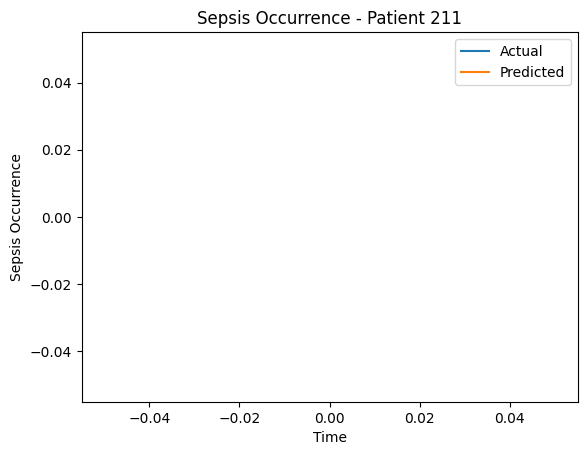

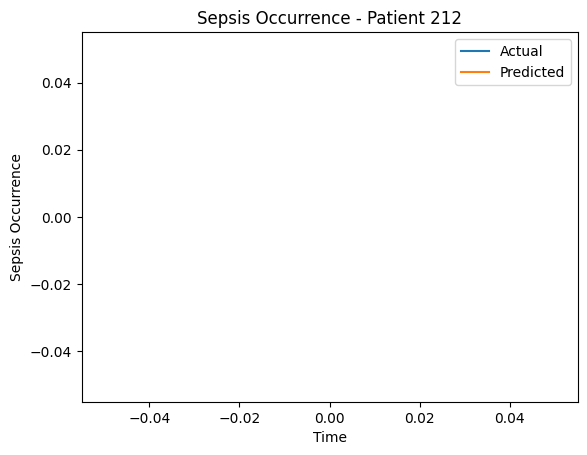

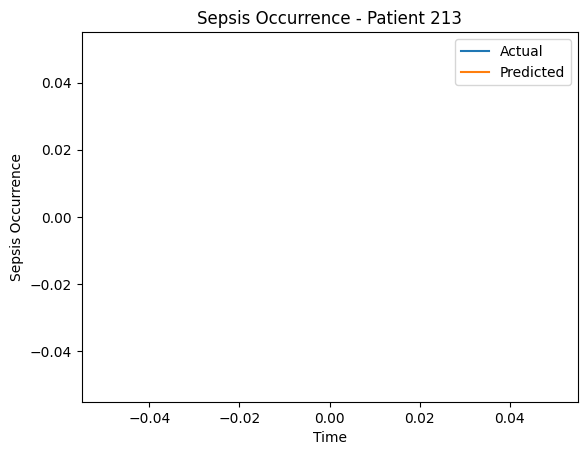

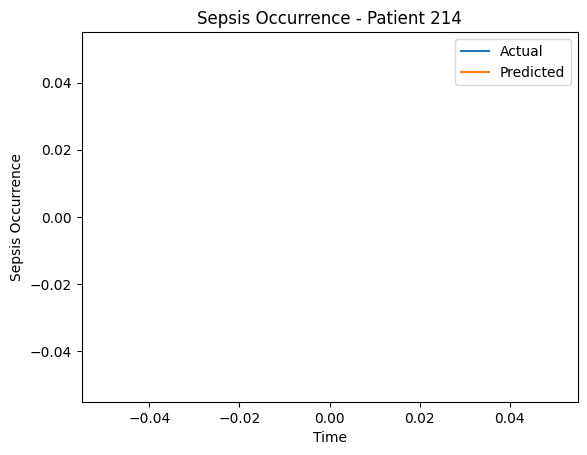

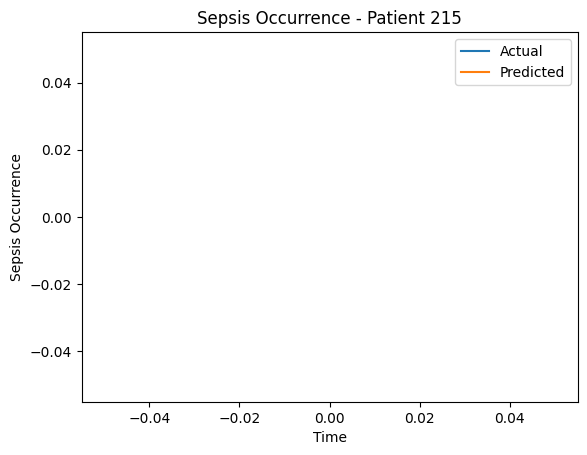

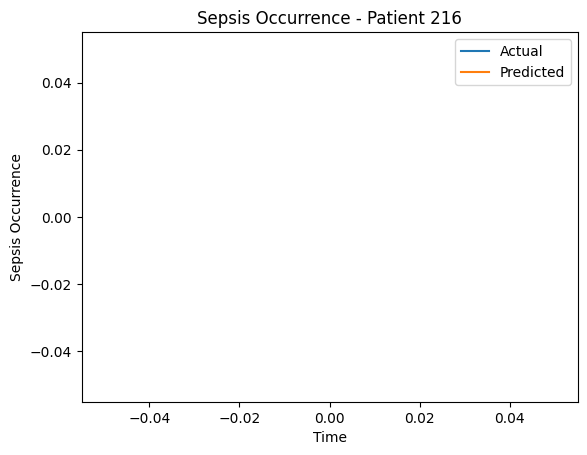

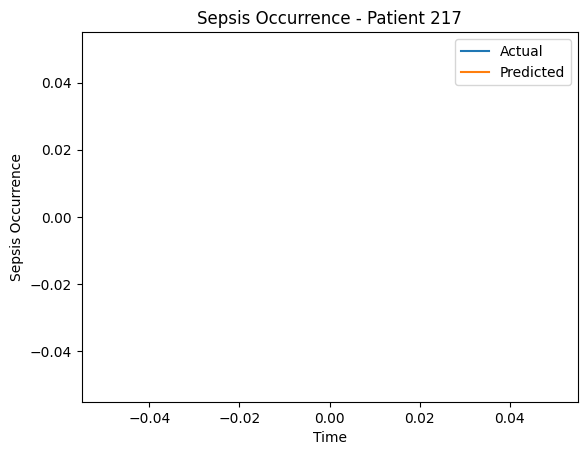

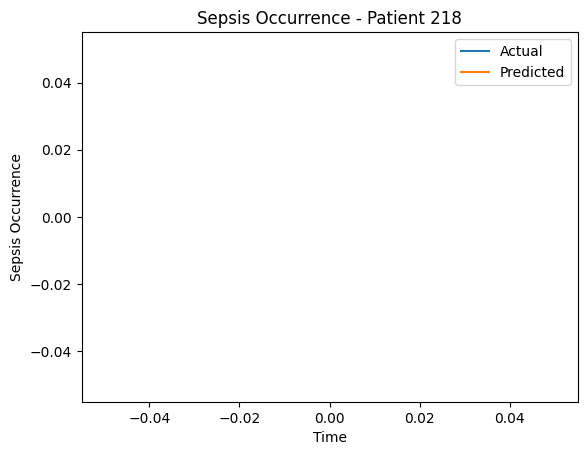

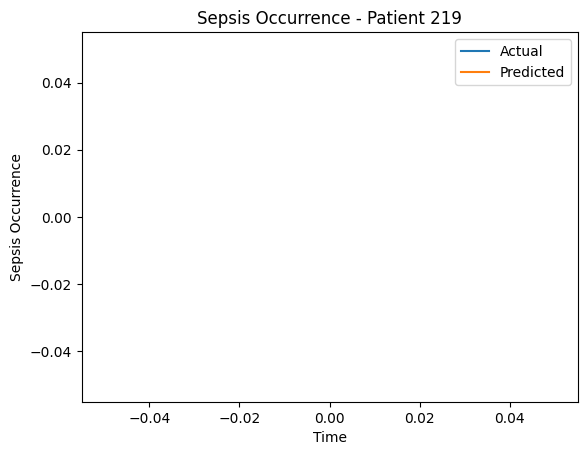

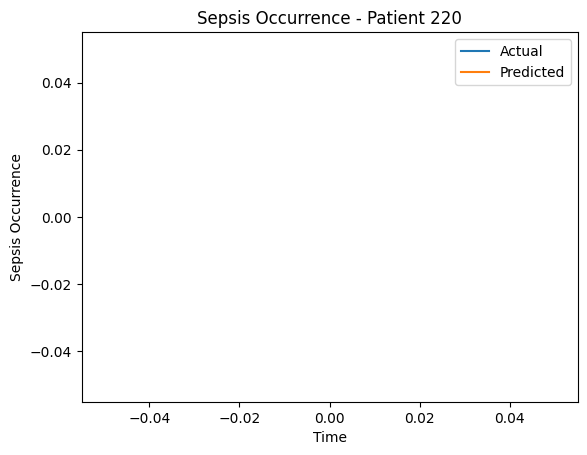

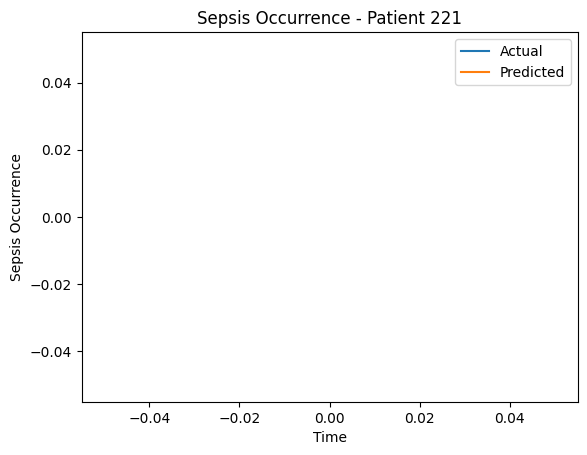

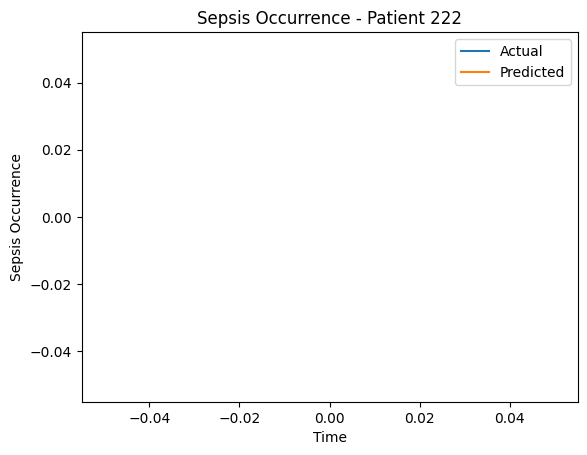

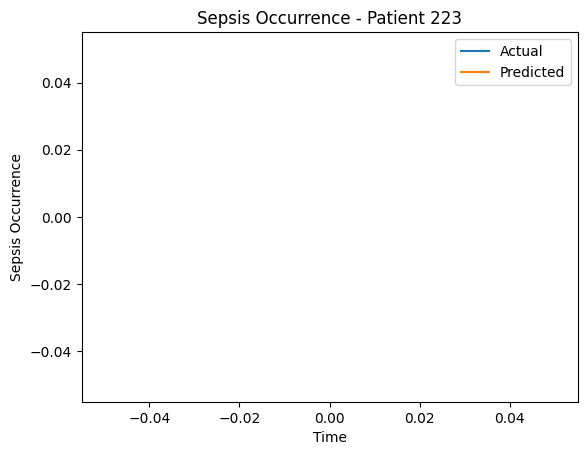

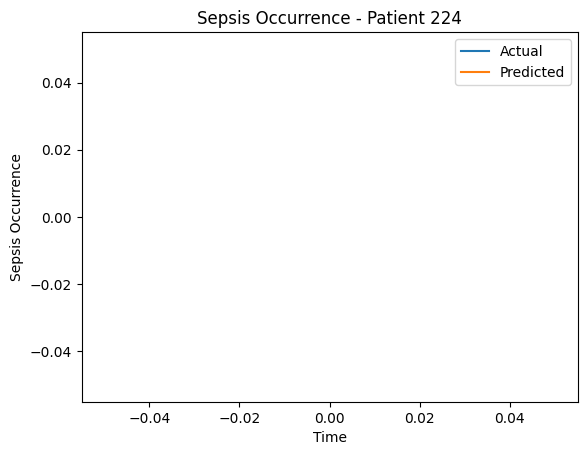

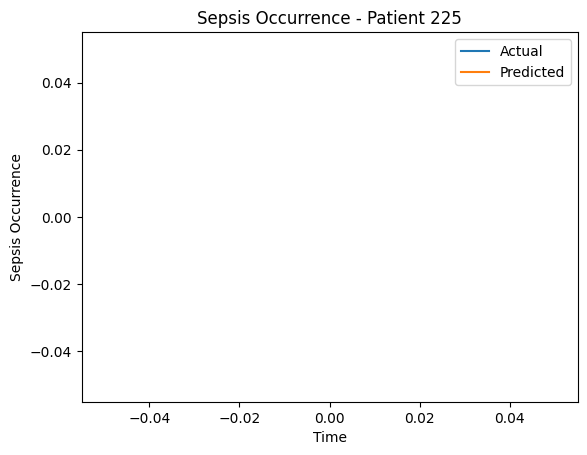

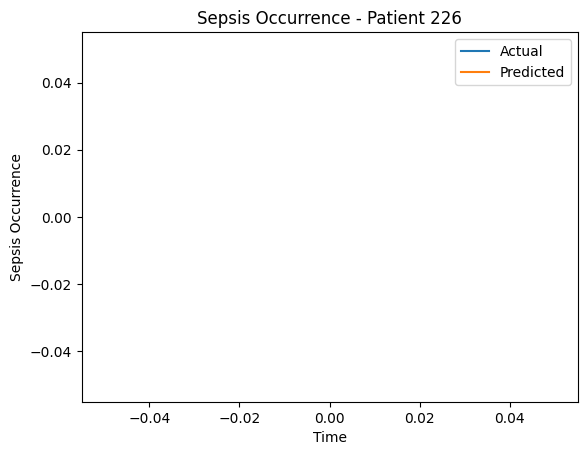

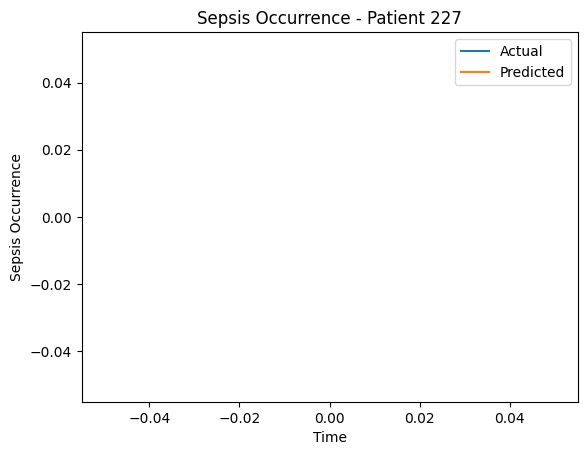

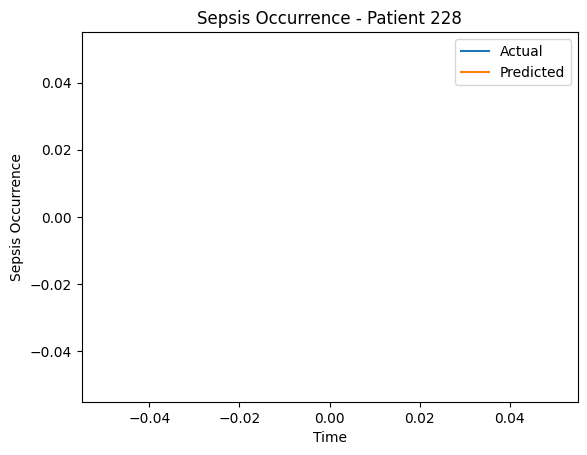

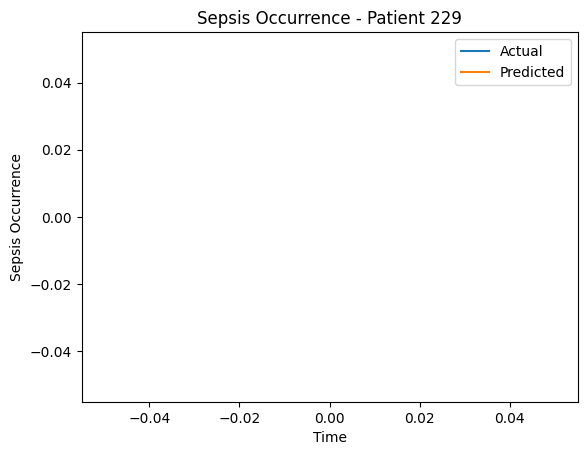

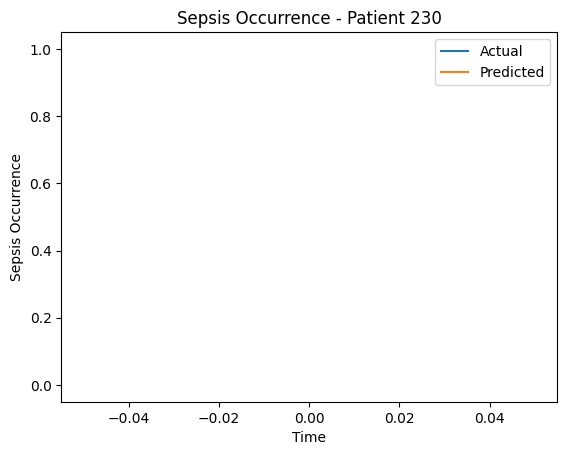

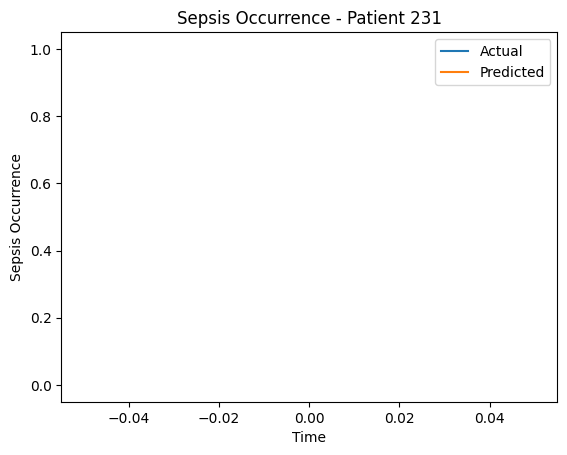

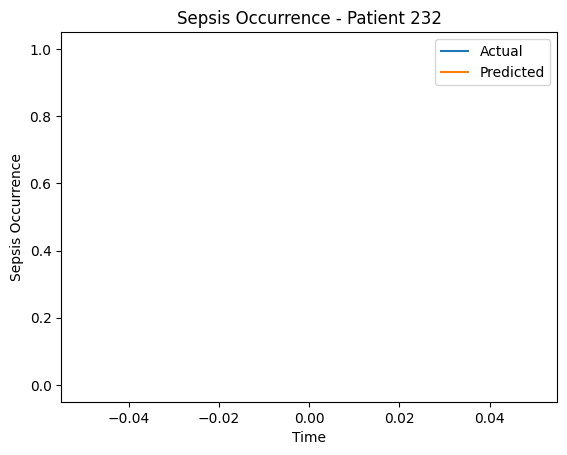

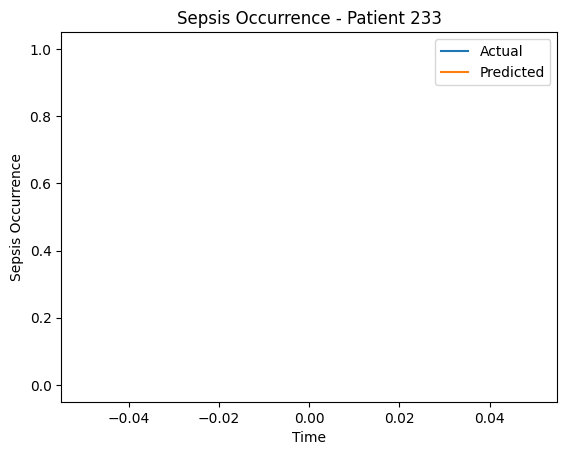

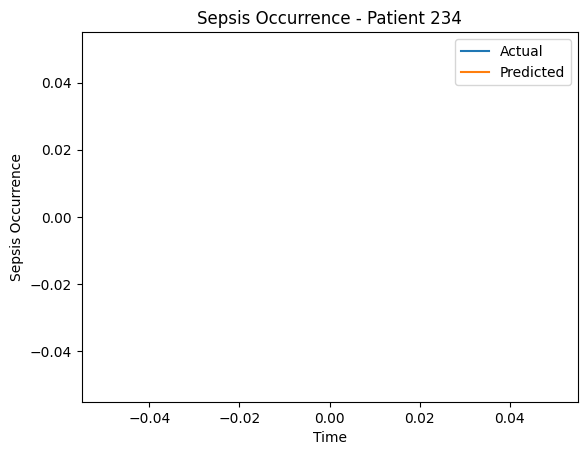

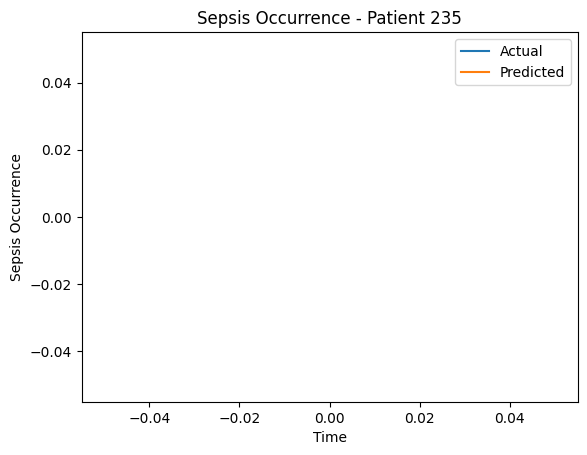

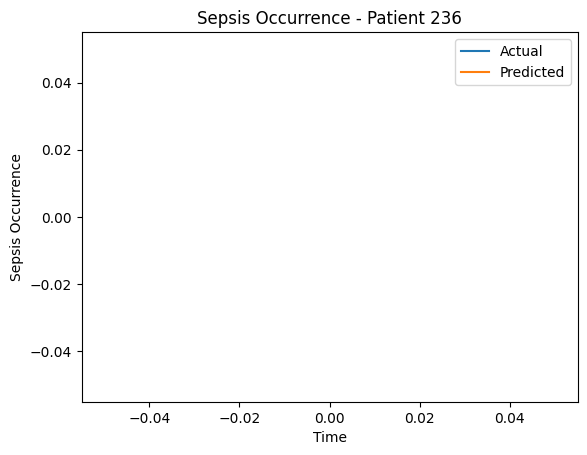

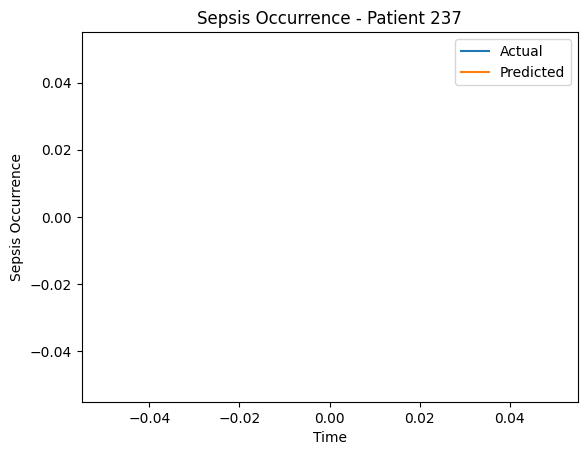

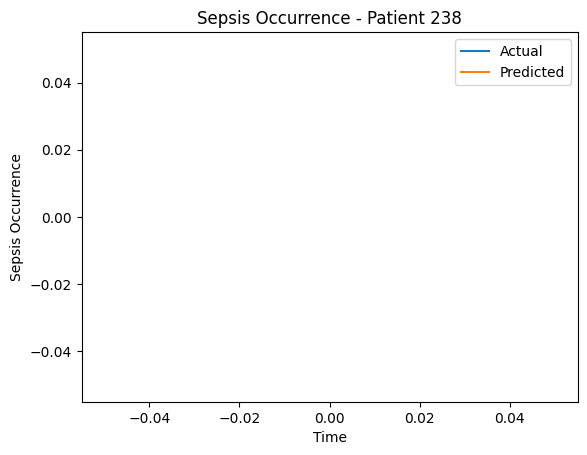

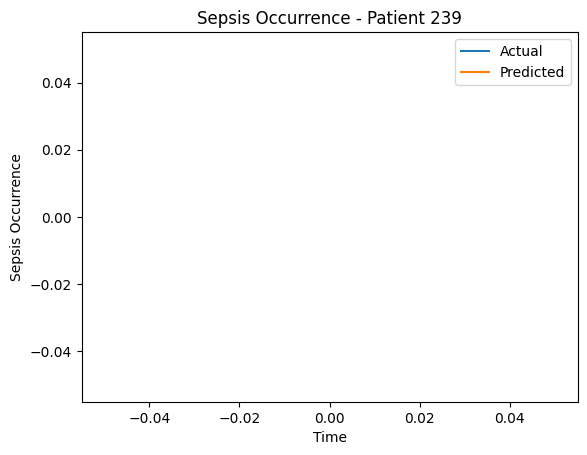

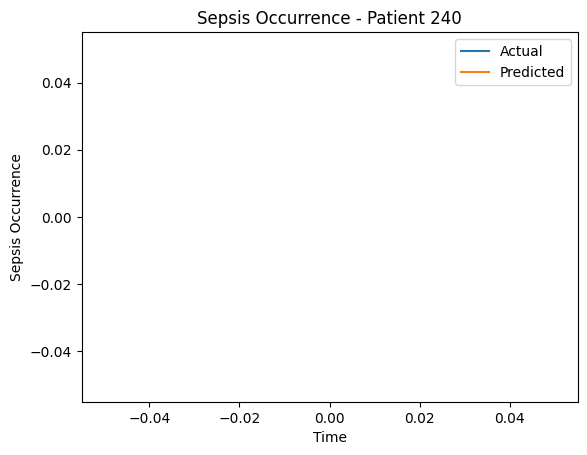

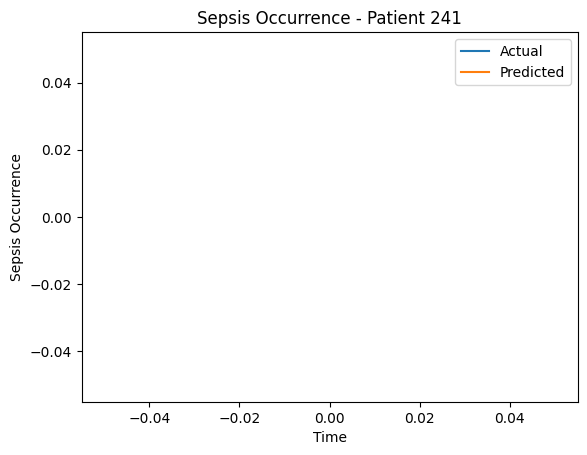

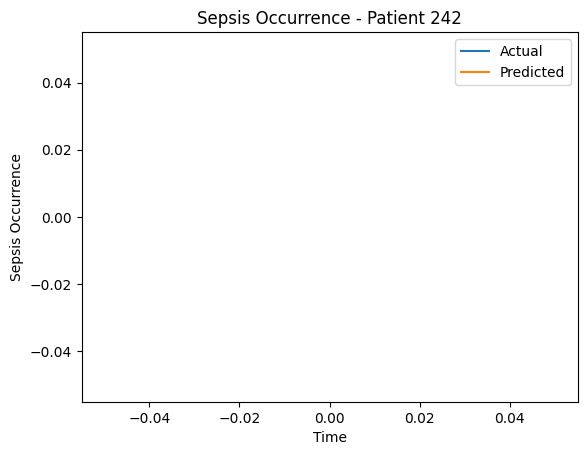

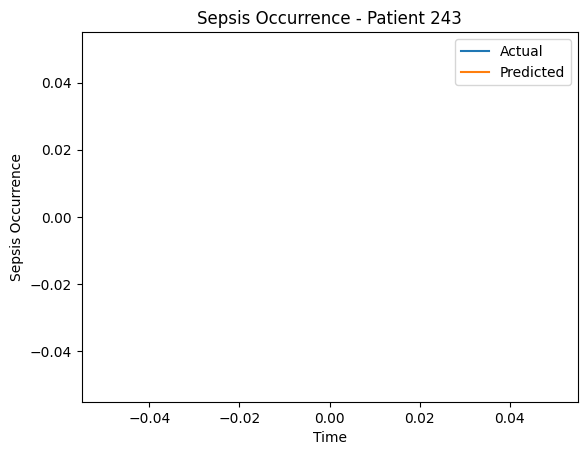

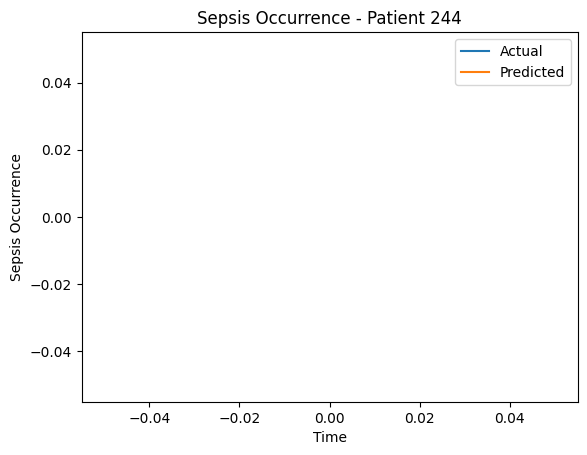

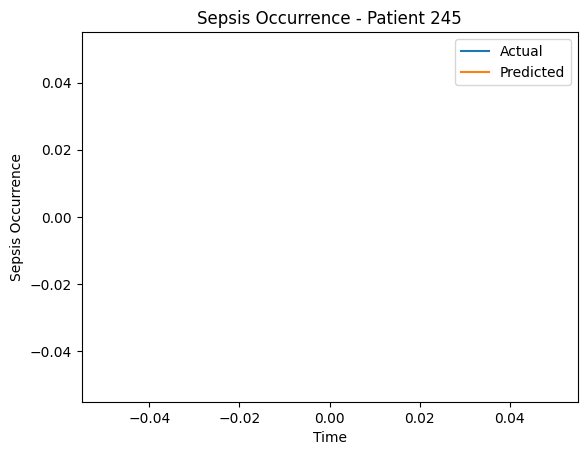

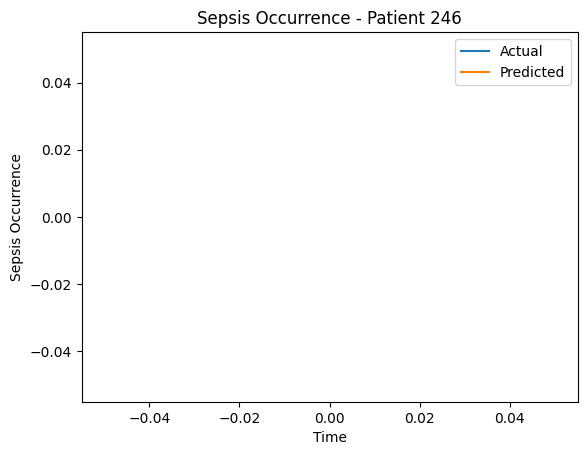

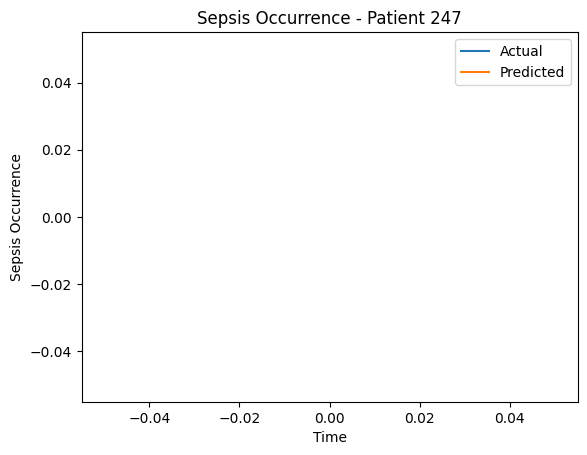

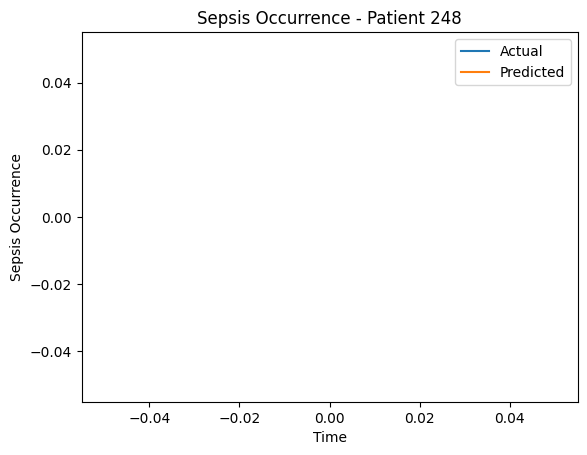

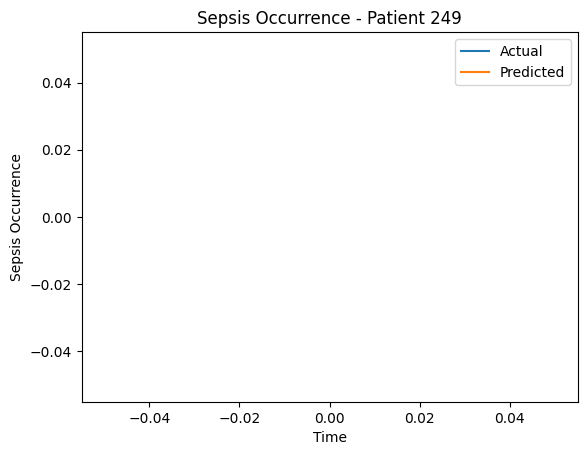

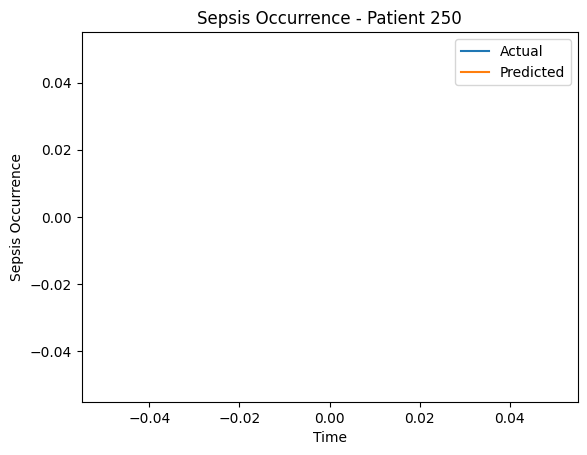

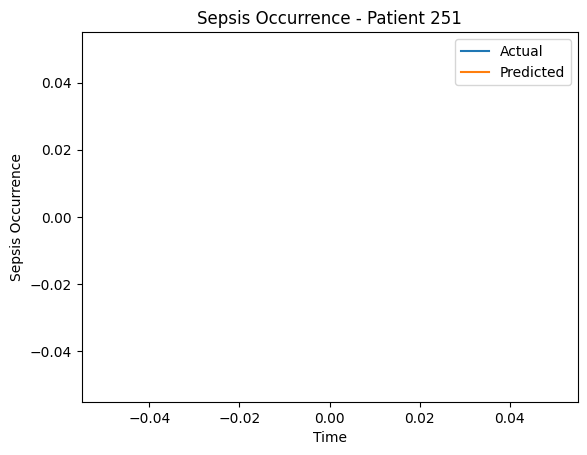

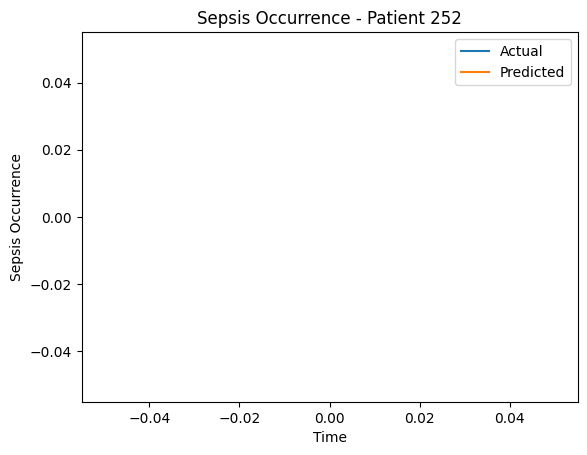

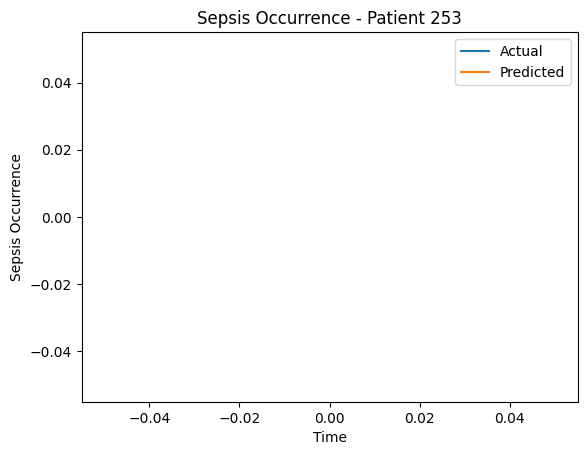

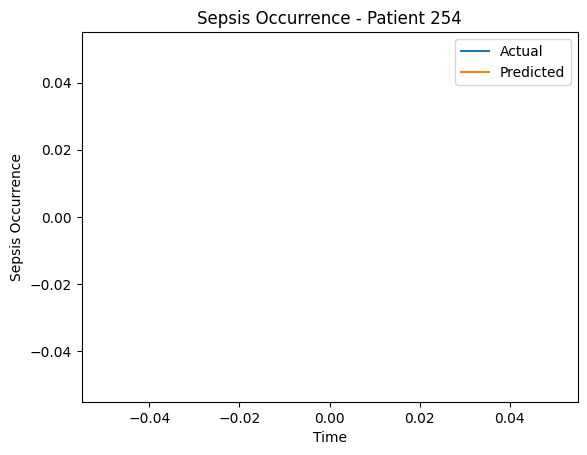

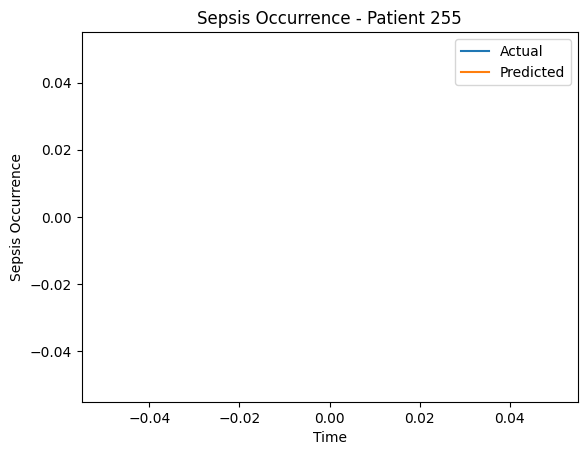

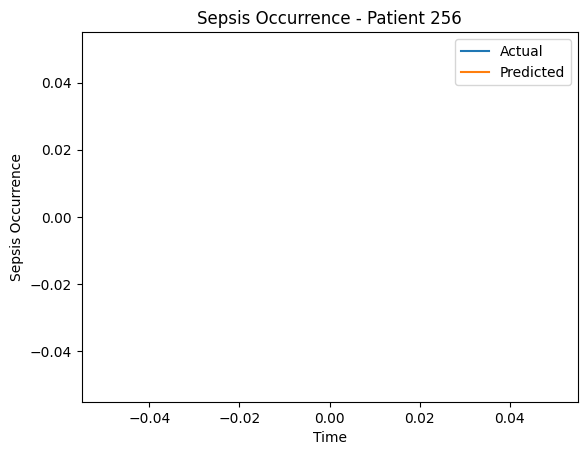

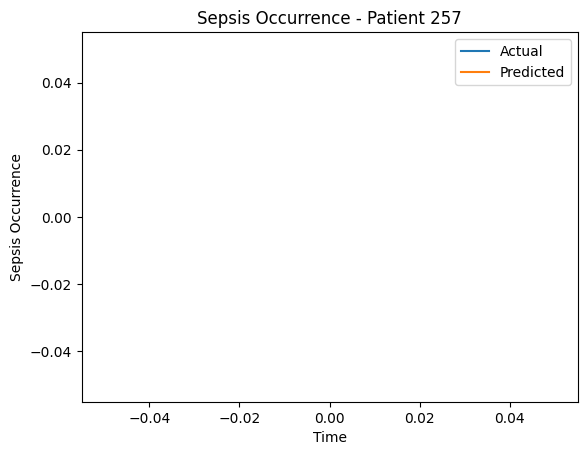

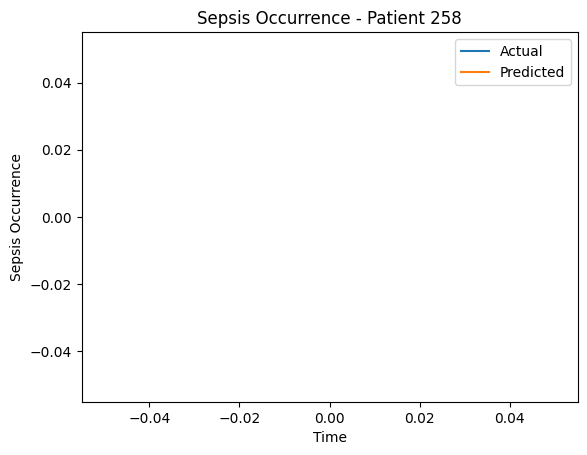

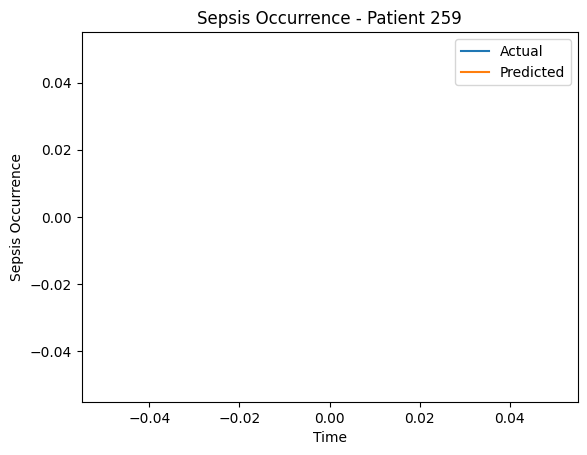

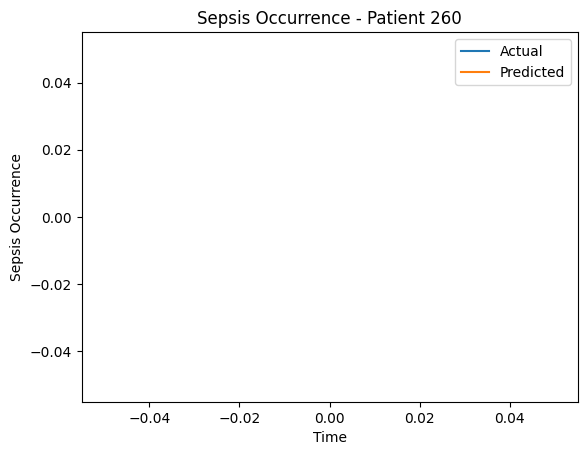

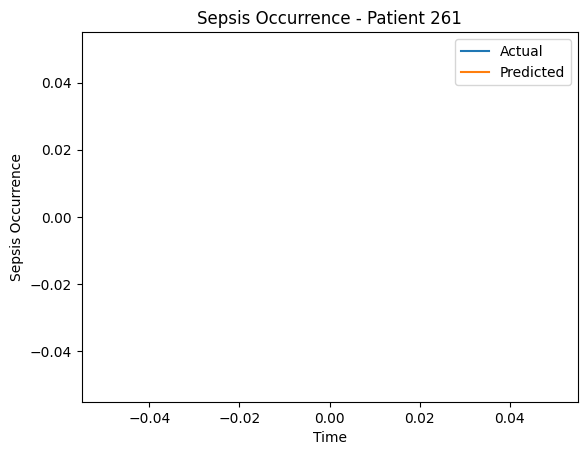

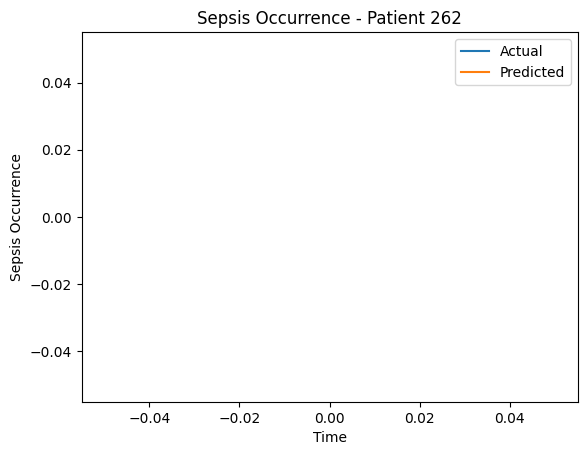

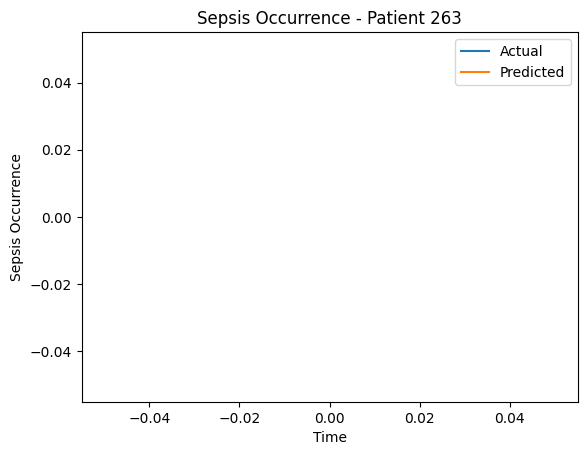

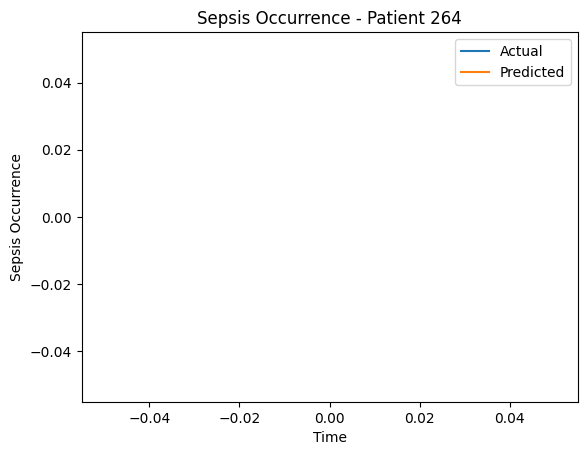

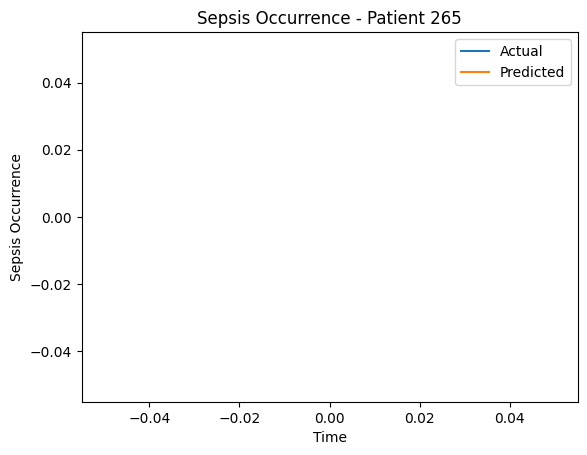

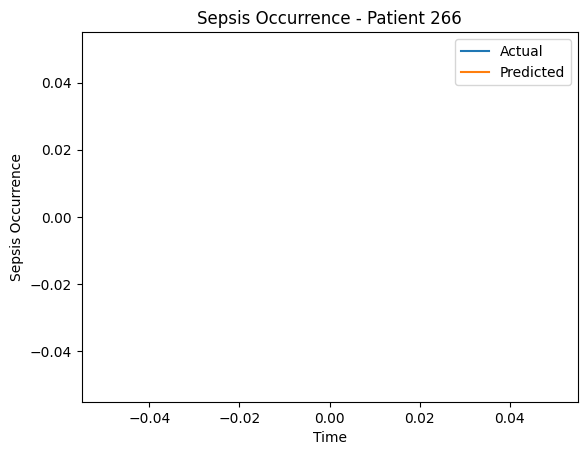

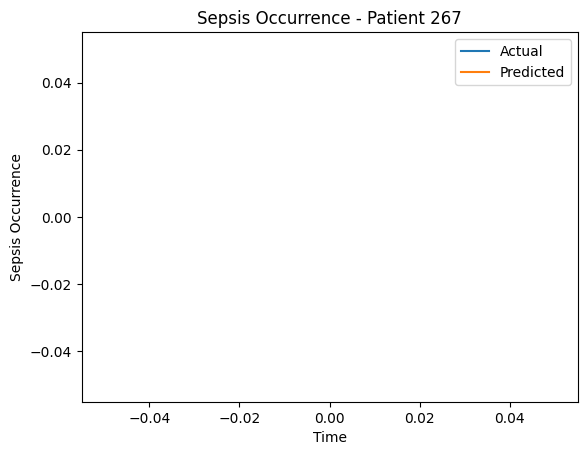

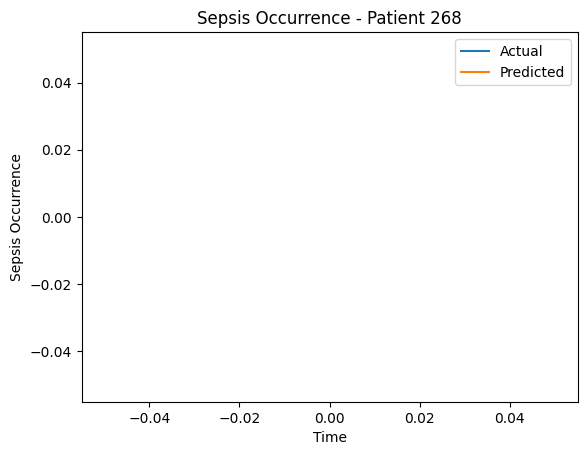

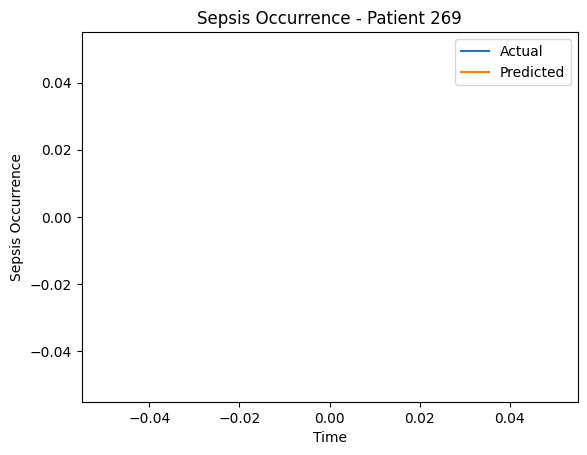

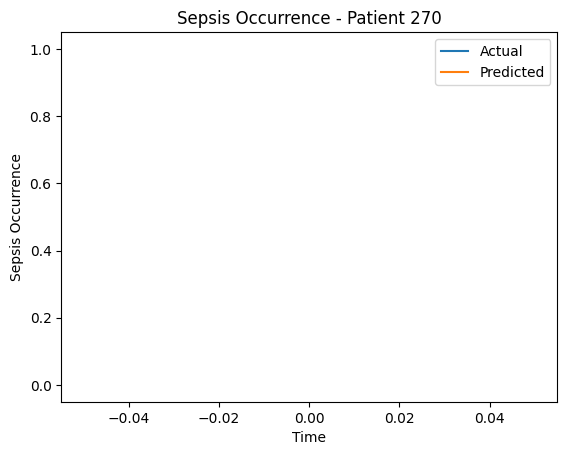

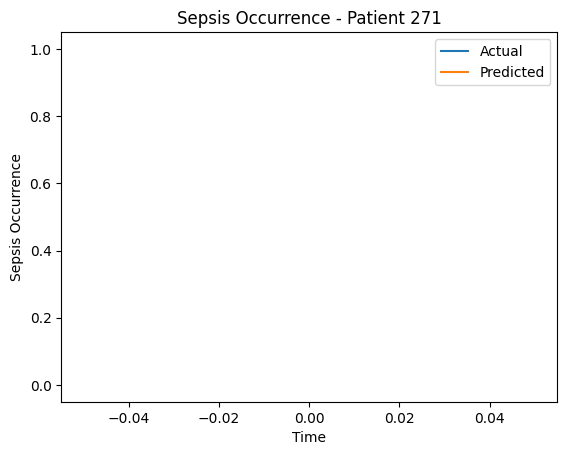

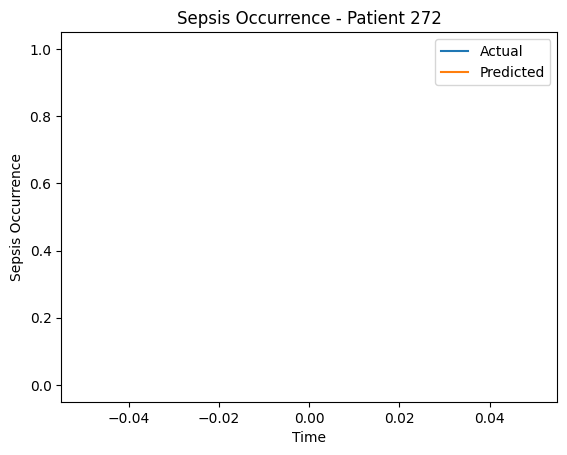

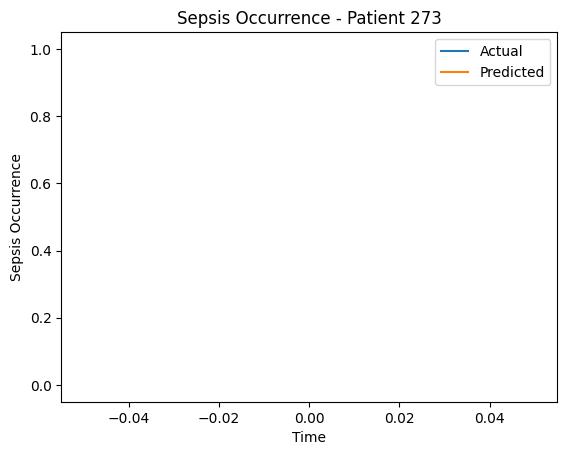

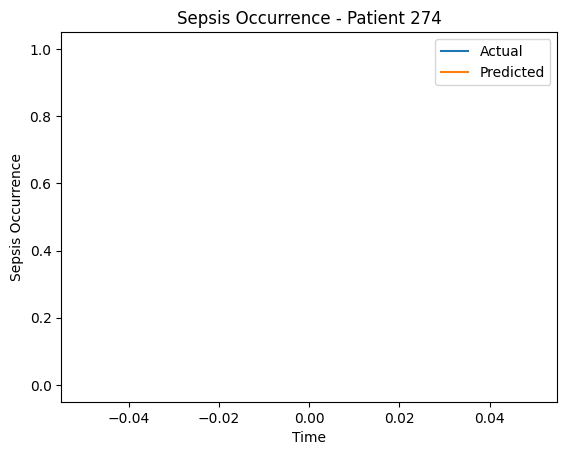

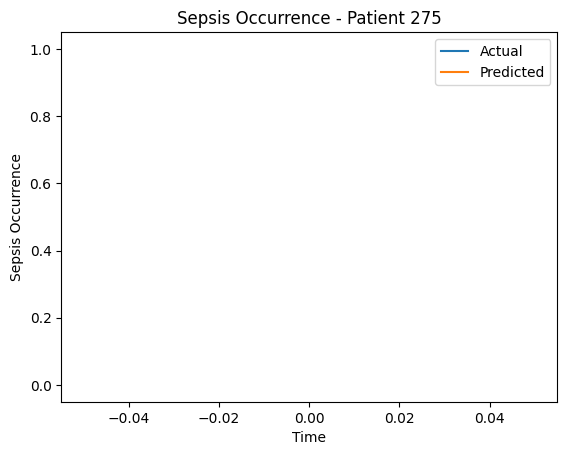

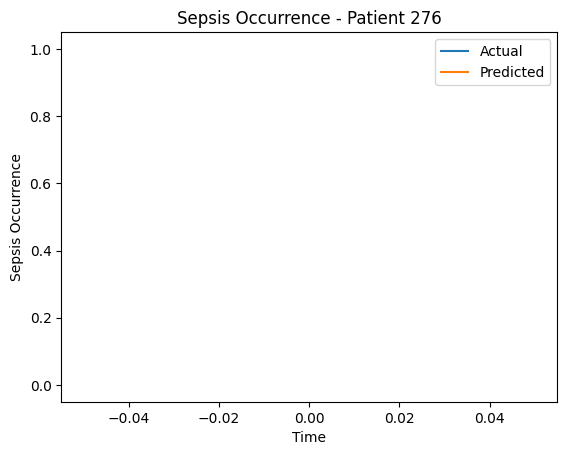

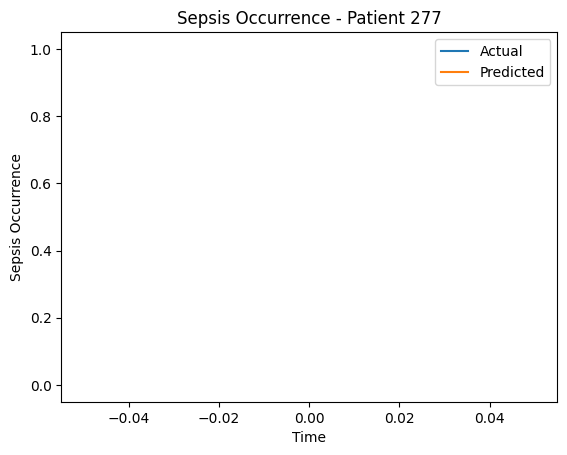

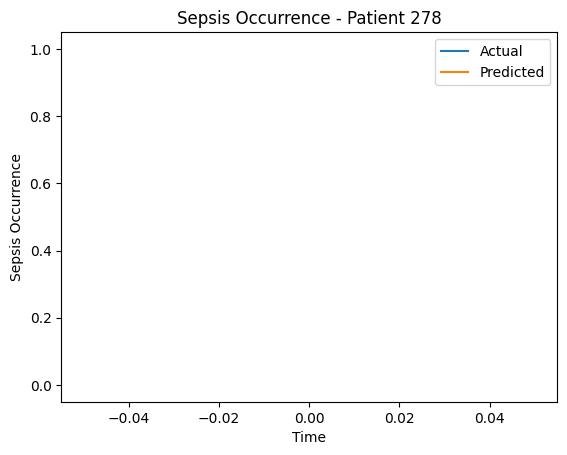

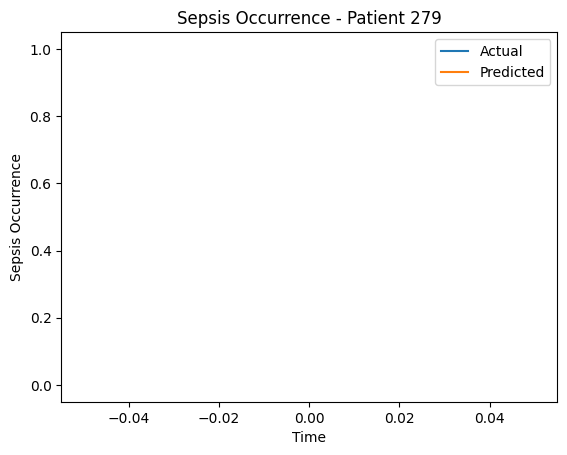

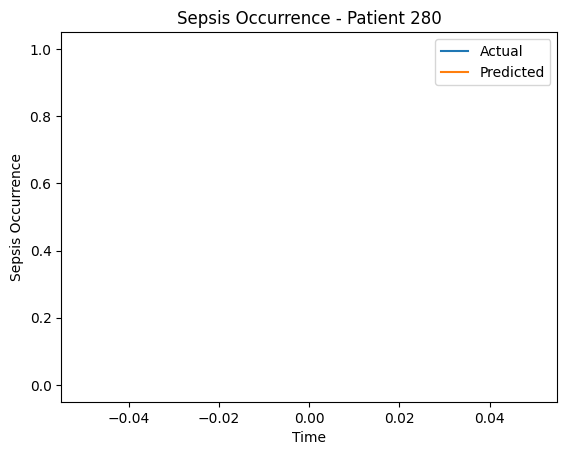

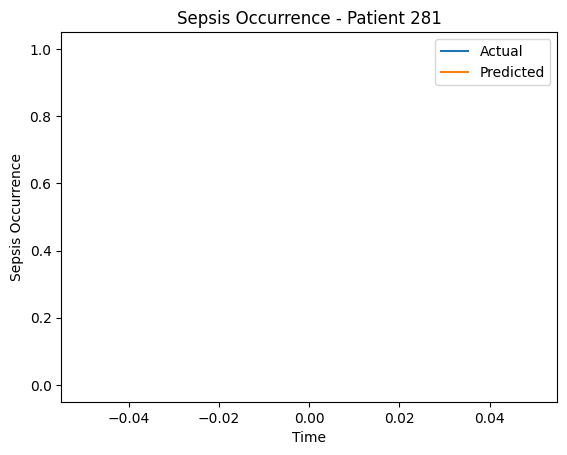

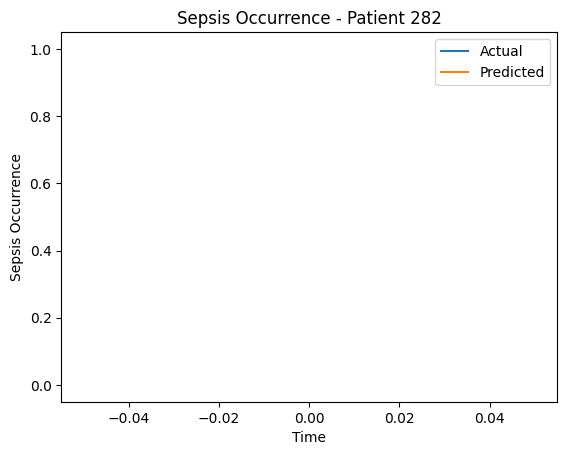

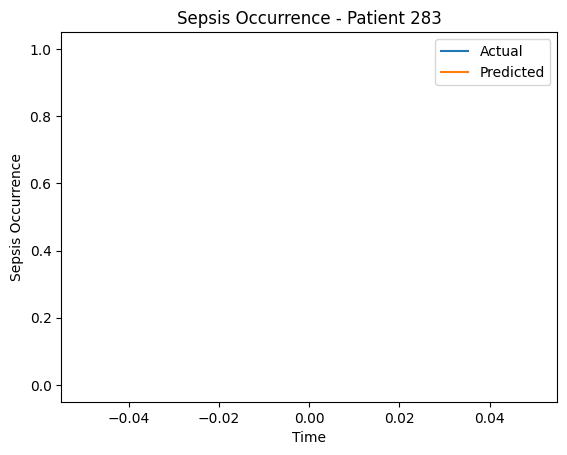

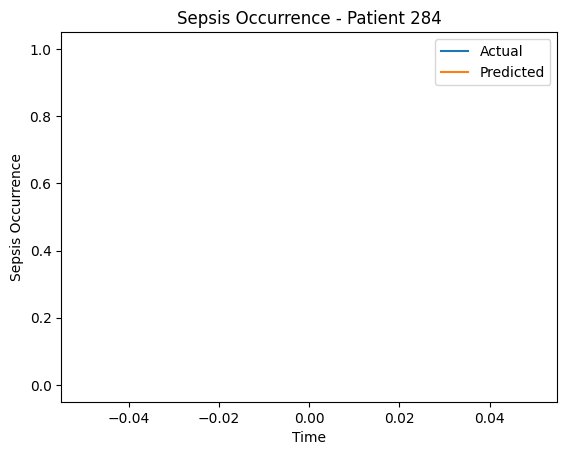

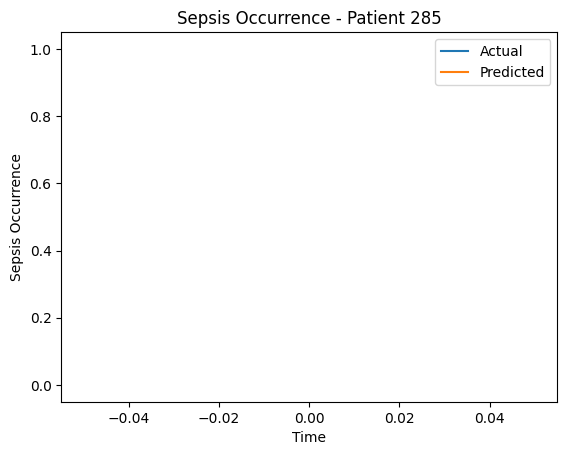

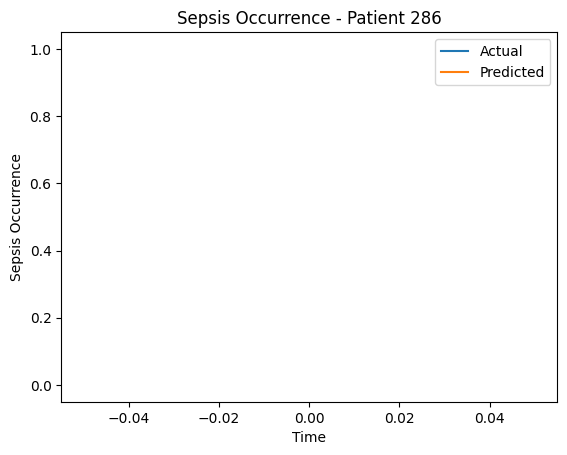

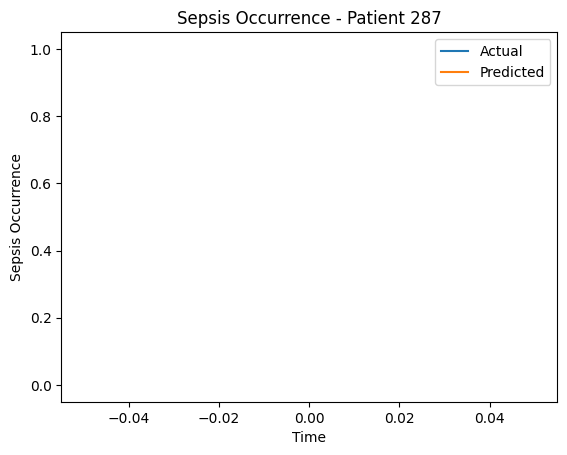

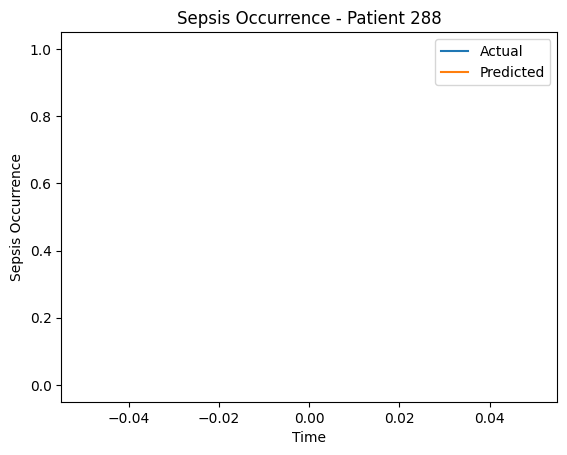

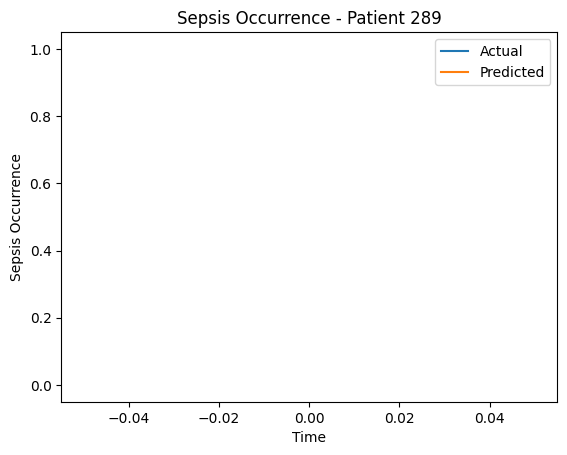

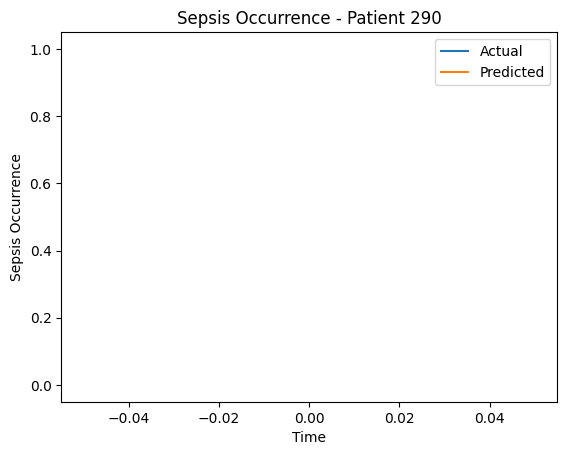

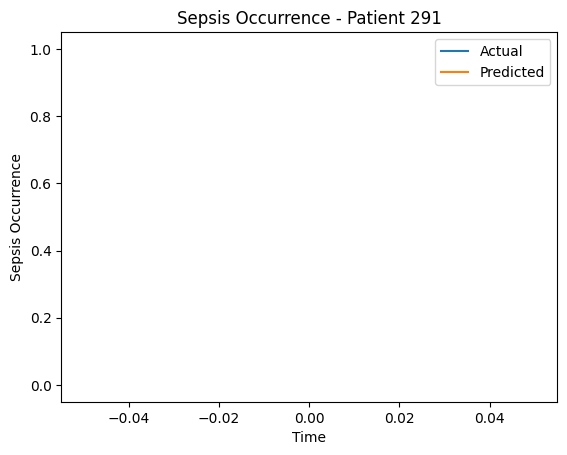

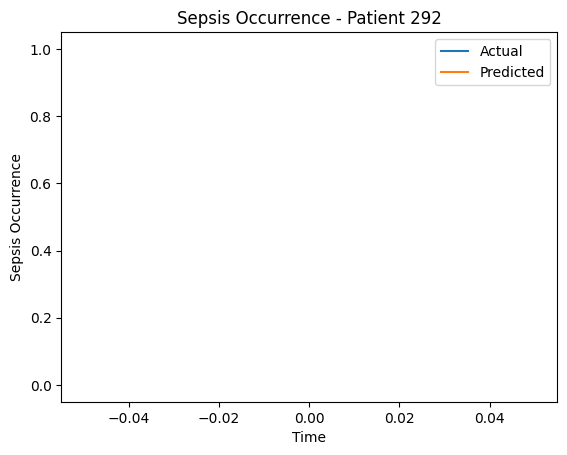

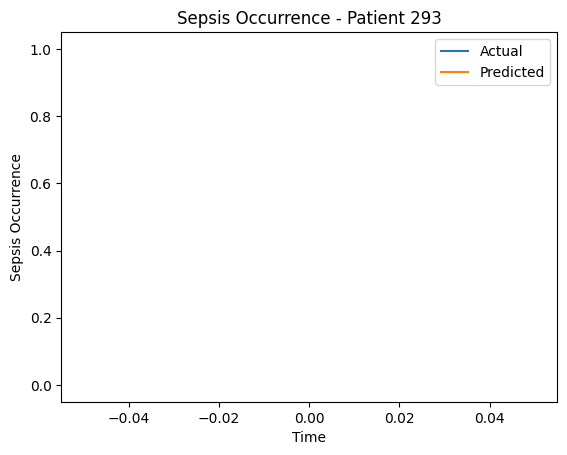

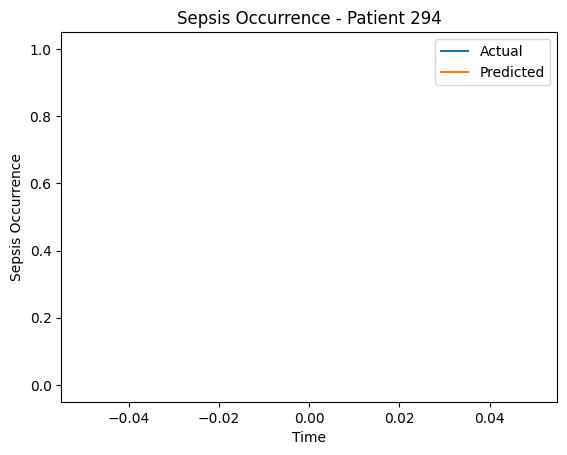

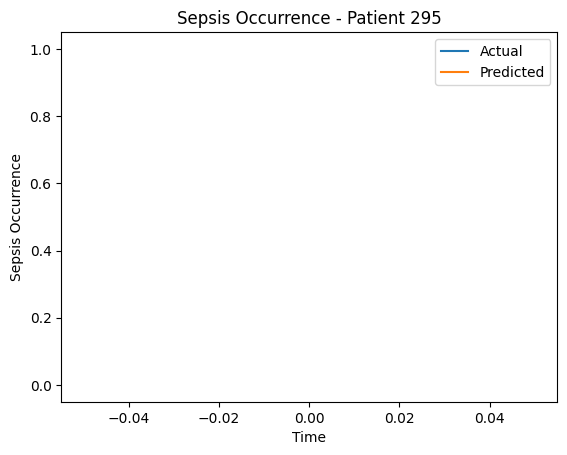

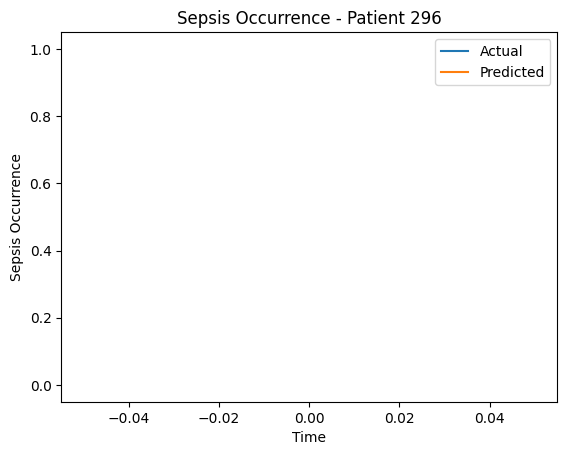

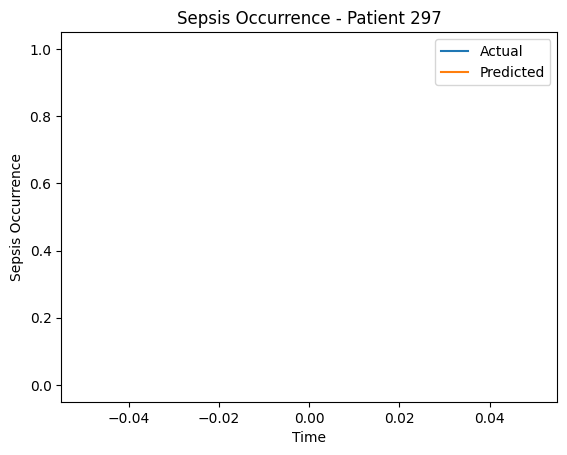

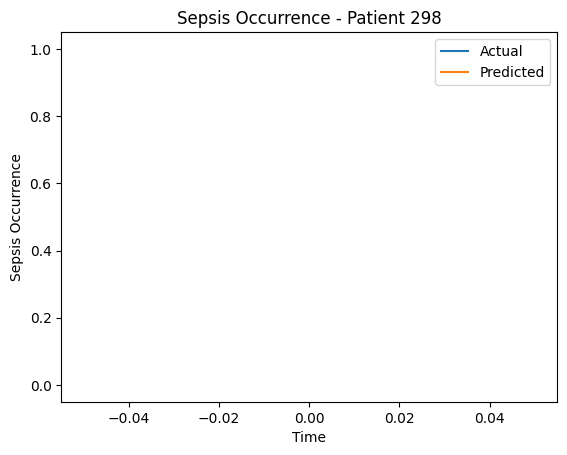

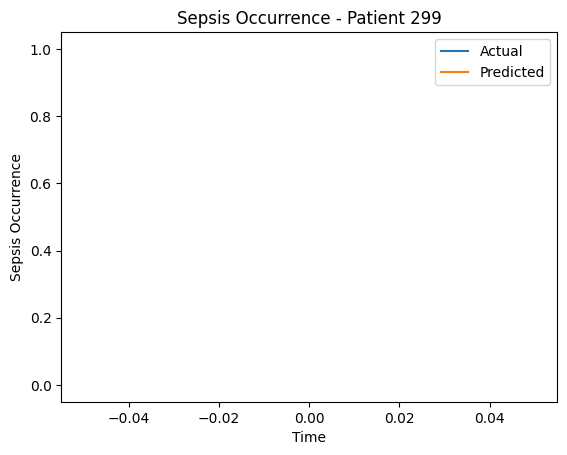

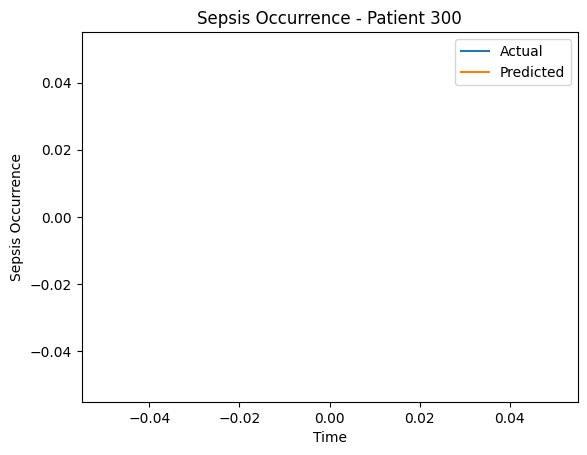

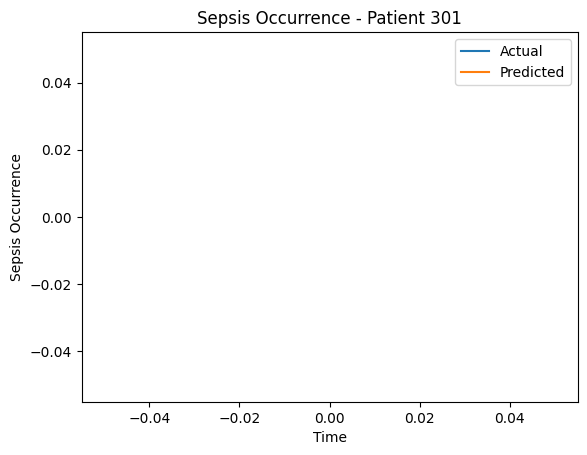

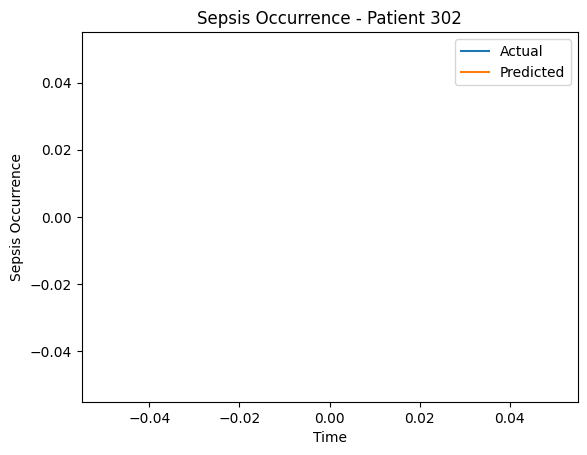

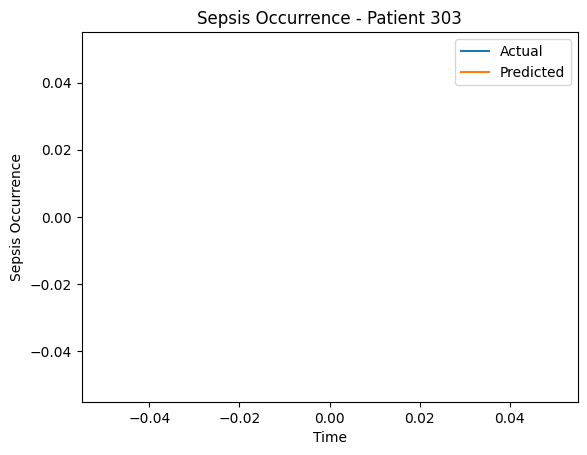

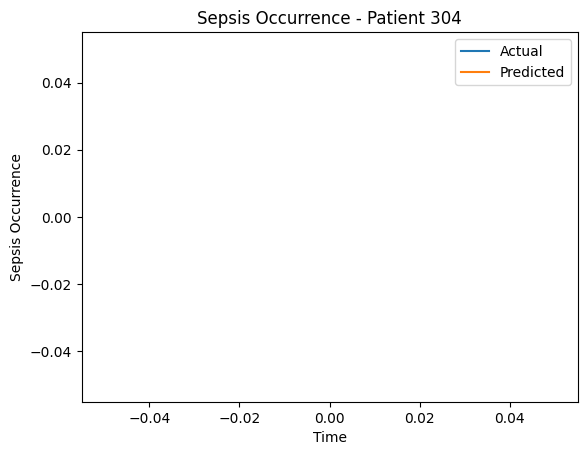

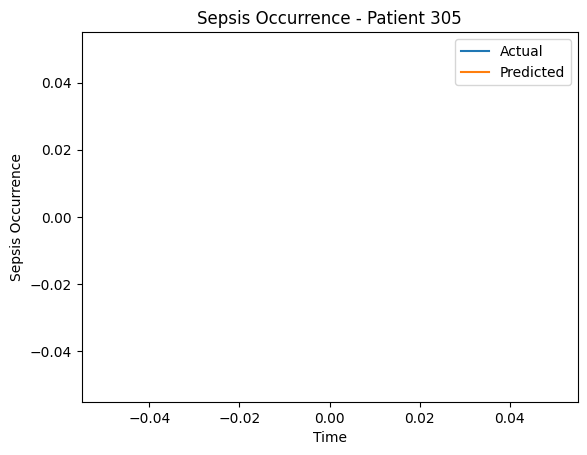

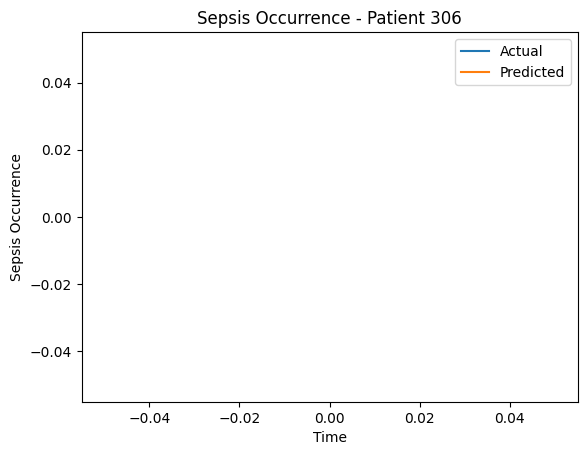

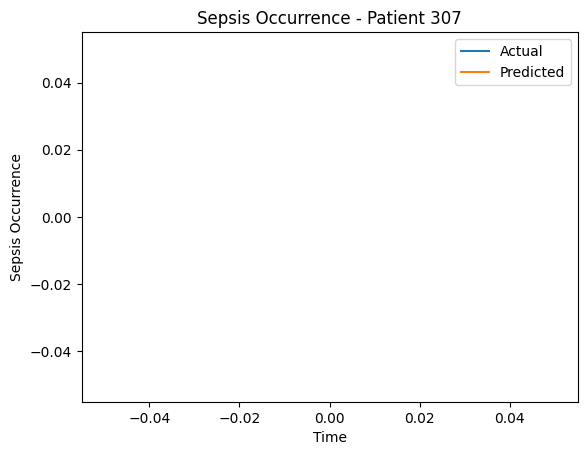

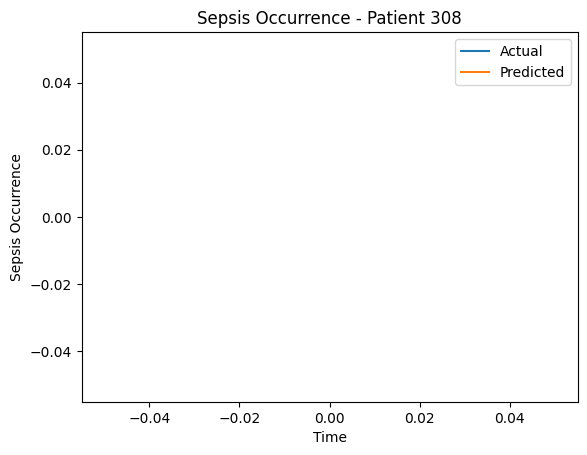

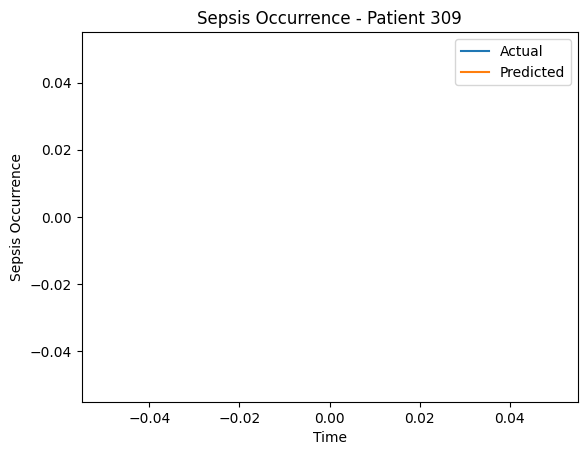

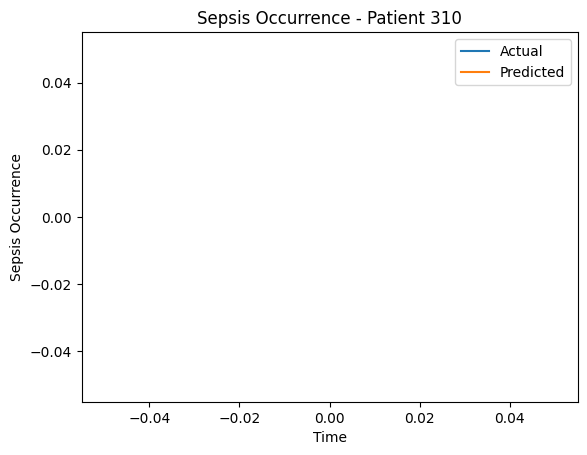

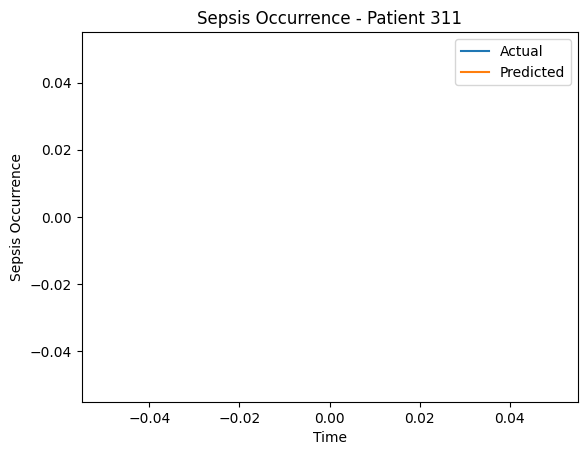

In [254]:

# Plot actual and predicted sepsis occurrences for each patient
# plt.figure(figsize=(12, 6))
# for i in range(len(test_y_true)):
#     plt.plot(test_y_true[i], label='Actual')
#     plt.plot(test_y_pred[i], label='Predicted')
#     plt.title(f"Sepsis Occurrence - Patient {i+1}")
#     plt.xlabel("Time")
#     plt.ylabel("Sepsis Occurrence")
#     plt.legend()
#     plt.show()